# Elo Merchant Categories
### Competition on Kaggle
## Catboost Regression to Analyse Outliers
### 2-2-2019

In [1]:
## Variables specific for competition

ID = 'card_id'                                            
TARGET = 'target'    

RAW_DIRECTORY = 'C:/Users/judit/Documents/learning/kaggle/Elo_201812/rawdata/'  
DIRECTORY = 'C:/Users/judit/Documents/learning/kaggle/Elo_201812/data/'
HIST_TRANS_FILE = RAW_DIRECTORY + 'historical_transactions.csv'
MERCHANTS_FILE = RAW_DIRECTORY + 'merchants.csv'
NEW_MERCH_TRANS_FILE = RAW_DIRECTORY + 'new_merchant_transactions.csv'
TRAIN_FILE = RAW_DIRECTORY + 'train.csv'    
TEST_FILE = RAW_DIRECTORY +'test.csv'
SAMPLE_SUBMISSION_FILE = RAW_DIRECTORY + 'sample_submission.csv'

SUBMISSION_DIRECTORY = 'C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/'

In [2]:
## Variables specific for notebook
NUM = 0
SUBMIT_FILENAME = SUBMISSION_DIRECTORY + 'submit_190202_'

X_TRAIN_Y_TRAIN_FILE = DIRECTORY + 'X_train_y_train_12_notebook.p'
LOCALTEST_FILE = DIRECTORY + 'localtest_set_12_notebook.p'

In [3]:
from catboost import CatBoostRegressor, CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import random
random.seed(1)

In [4]:
X_train, y_train = pickle.load(open(X_TRAIN_Y_TRAIN_FILE, 'rb'))
X_localtest, y_localtest, y_localtest_label = pickle.load(open(LOCALTEST_FILE, 'rb'))

In [5]:
X_train.shape, y_train.shape

((161533, 488), (161533,))

In [6]:
X_localtest.shape, y_localtest.shape, y_localtest_label.shape

((40384, 487), (40384,), (40384,))

In [7]:
X_train.head()

first_active_month  card_id  feature_1  feature_2  feature_3  \
88577                   69   132757          2          1          1   
91416                   70    81272          1          1          0   
187776                  72   101569          1          1          0   
31980                   69   134544          2          1          1   
179360                  66   195062          2          2          1   

        is_outlier  hist_authorized_flag_sum_auth_dom_lag2m  \
88577            0                                     12.0   
91416            0                                     14.0   
187776           0                                     11.0   
31980            0                                     17.0   
179360           0                                     23.0   

        hist_authorized_flag_mean_auth_dom_lag2m  \
88577                                        1.0   
91416                                        1.0   
187776                                       1.0   
31980                                        1.0   
179360                                       1.0   

        hist_city_id_nunique_auth_dom_lag2m  hist_city_id_mode_auth_dom_lag2m  \
88577                                   2.0                               291   
91416                                   1.0                               292   
187776                                  2.0                               303   
31980                                   3.0                                22   
179360                                  2.0                               260   

                           ...                      \
88577                      ...                       
91416                      ...                       
187776                     ...                       
31980                      ...                       
179360                     ...                       

        avg_sales_lag6_new_merchant_id_mode_nondom_all  \
88577                                              NaN   
91416                                              NaN   
187776                                             NaN   
31980                                              NaN   
179360                                             NaN   

        avg_purchases_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        active_months_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        avg_sales_lag12_new_merchant_id_mode_nondom_all  \
88577                                               NaN   
91416                                               NaN   
187776                                              NaN   
31980                                               NaN   
179360                                              NaN   

        avg_purchases_lag12_new_merchant_id_mode_nondom_all  \
88577                                                 NaN     
91416                                                 NaN     
187776                                                NaN     
31980                                                 NaN     
179360                                                NaN     

        active_months_lag12_new_merchant_id_mode_nondom_all  \
88577                                                 NaN     
91416                                                 NaN     
187776                                               

### Prepair data for Catboost  
Catboost can handle categorical features, but we have to input a string for nan values in categorical features.

In [8]:
categorical_features = ['first_active_month',
                        'card_id',
                        'feature_1',
                        'feature_2',
                        'feature_3',
                        'hist_city_id_mode_auth_dom_lag2m',
                        'hist_category_3_mode_auth_dom_lag2m',
                        'hist_merchant_category_id_mode_auth_dom_lag2m',
                        'hist_merchant_id_mode_auth_dom_lag2m',
                        'hist_category_2_mode_auth_dom_lag2m',
                        'hist_state_id_mode_auth_dom_lag2m',
                        'hist_subsector_id_mode_auth_dom_lag2m',
                        'hist_city_id_mode_auth_nondom_lag2m',
                        'hist_category_3_mode_auth_nondom_lag2m',
                        'hist_merchant_category_id_mode_auth_nondom_lag2m',
                        'hist_merchant_id_mode_auth_nondom_lag2m',
                        'hist_category_2_mode_auth_nondom_lag2m',
                        'hist_state_id_mode_auth_nondom_lag2m',
                        'hist_subsector_id_mode_auth_nondom_lag2m',
                        'new_city_id_mode_dom_all',
                        'new_category_3_mode_dom_all',
                        'new_merchant_category_id_mode_dom_all',
                        'new_merchant_id_mode_dom_all',
                        'new_category_2_mode_dom_all',
                        'new_state_id_mode_dom_all',
                        'new_subsector_id_mode_dom_all',
                        'new_city_id_mode_nondom_all',
                        'new_category_3_mode_nondom_all',
                        'new_merchant_category_id_mode_nondom_all',
                        'new_merchant_id_mode_nondom_all',
                        'new_category_2_mode_nondom_all',
                        'new_state_id_mode_nondom_all',
                        'new_subsector_id_mode_nondom_all',
                        'merchant_group_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'merchant_category_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'subsector_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'city_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'state_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'category_2_hist_merchant_id_mode_auth_dom_lag2m',
                        'merchant_group_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'merchant_category_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'subsector_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'city_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'state_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'category_2_hist_merchant_id_mode_auth_nondom_lag2m',
                        'merchant_group_id_new_merchant_id_mode_dom_all',
                        'merchant_category_id_new_merchant_id_mode_dom_all',
                        'subsector_id_new_merchant_id_mode_dom_all',
                        'city_id_new_merchant_id_mode_dom_all',
                        'state_id_new_merchant_id_mode_dom_all',
                        'category_2_new_merchant_id_mode_dom_all',
                        'merchant_group_id_new_merchant_id_mode_nondom_all',
                        'merchant_category_id_new_merchant_id_mode_nondom_all',
                        'subsector_id_new_merchant_id_mode_nondom_all',
                        'city_id_new_merchant_id_mode_nondom_all',
                        'state_id_new_merchant_id_mode_nondom_all',
                        'category_2_new_merchant_id_mode_nondom_all']

In [9]:
# Use only inliers to train the regressor
X_train_restricted = X_train[X_train['is_outlier'] == 0].copy()
X_train_restricted.drop('is_outlier', axis = 1, inplace = True)
y_train_restricted = y_train[X_train['is_outlier'] == 0].copy()

### Grid search to find regression hyperparameters

In [10]:
ignored_features = ['first_active_month', 'card_id']
for col in categorical_features:
    X_train_restricted[col] = X_train_restricted[col].astype('category').cat.codes
categorical_features_indices = [X_train_restricted.columns.get_loc(i) for i in categorical_features]
ignored_features_indices = [X_train_restricted.columns.get_loc(i) for i in ignored_features]

def grid_search(params =  {'learning_rate': .99, 'iterations' : 100},
                train_set = X_train_restricted,
                train_label = y_train_restricted,
                param_grid = {'border_count' : [16, 32]},
                cv_folds = 5,
                scoring = 'neg_mean_squared_error',
                n_jobs = -1,
                verbose = 10,
                seed = 1):
    cbr = CatBoostRegressor(**params, ignored_features = ignored_features_indices, random_seed = seed)
    gs = GridSearchCV(estimator = cbr, param_grid = param_grid, scoring = scoring, cv = cv_folds, n_jobs = n_jobs, 
                      verbose = verbose)
    gs.fit(train_set, train_label)
    best_parameters = gs.best_params_ 
    return gs, best_parameters

In [11]:
params =  {'learning_rate': .99, 
           'iterations' : 100}
params_grid = {'depth':[10, 8, 6, 4],            
               'l2_leaf_reg':[0, 0.01, 0.1, 1, 10, 100]}
# I also tried to train with depth=13 and depth=16, but they were too long to train (22 hours and 6.5 days, respectively)

In [12]:
def run_iterative_grid_search(order_of_tuning = [['depth'], ['l2_leaf_reg']],
                              train_set = X_train_restricted,
                              train_label = y_train_restricted,
                              categorical_features = categorical_features,
                              ignored_features = ignored_features,
                              params = params,
                              params_grid = params_grid,
                              cv_folds = 5,
                              scoring = 'neg_mean_squared_error',
                              n_jobs = -1,
                              verbose = 10,
                              seed = 1):
    for col in categorical_features:
        train_set[col] = train_set[col].astype('category').cat.codes
    categorical_features_indices = [train_set.columns.get_loc(i) for i in categorical_features]
    ignored_features_indices = [train_set.columns.get_loc(i) for i in ignored_features]
    
    cnt_grid_seaches = len(order_of_tuning)
    grid_searches = []
    
    for ls in order_of_tuning:
        print('Tuning hyperparameters', ls)
        param_grid = {}
        for param in ls:
            param_grid[param] = params_grid[param]
        gs, best_parameters = grid_search(params =  params,
                                          train_set = train_set,
                                          train_label = train_label,
                                          param_grid = param_grid,
                                          cv_folds = cv_folds,
                                          scoring = scoring,
                                          n_jobs = n_jobs,
                                          seed = seed,
                                          verbose = verbose)
        for parameter, val in best_parameters.items():
            params[parameter] = val
        grid_searches.append(gs)
    return grid_searches, params

In [13]:
grid_search_depth, param_depth = run_iterative_grid_search(order_of_tuning = [['depth']])
pickle.dump(grid_search_depth, open(DIRECTORY + 'grid_search_depth_15_notebook.p',   'wb'))
pickle.dump(param_depth, open(DIRECTORY + 'param_depth_15_notebook.p', 'wb'))

Tuning hyperparameters ['depth']
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  6.8min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  7.3min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  8.5min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  8.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.1min finished


0:	learn: 1.6372934	total: 284ms	remaining: 28.1s
1:	learn: 1.6231188	total: 413ms	remaining: 20.2s
2:	learn: 1.6154526	total: 531ms	remaining: 17.2s
3:	learn: 1.6109469	total: 659ms	remaining: 15.8s
4:	learn: 1.6066408	total: 784ms	remaining: 14.9s
5:	learn: 1.6028226	total: 925ms	remaining: 14.5s
6:	learn: 1.6008233	total: 1.02s	remaining: 13.5s
7:	learn: 1.5988446	total: 1.14s	remaining: 13.1s
8:	learn: 1.5963893	total: 1.27s	remaining: 12.9s
9:	learn: 1.5937558	total: 1.4s	remaining: 12.6s
10:	learn: 1.5928805	total: 1.48s	remaining: 12s
11:	learn: 1.5914679	total: 1.6s	remaining: 11.7s
12:	learn: 1.5890735	total: 1.72s	remaining: 11.5s
13:	learn: 1.5877046	total: 1.83s	remaining: 11.3s
14:	learn: 1.5859121	total: 1.95s	remaining: 11.1s
15:	learn: 1.5846695	total: 2.07s	remaining: 10.9s
16:	learn: 1.5839658	total: 2.15s	remaining: 10.5s
17:	learn: 1.5831660	total: 2.25s	remaining: 10.3s
18:	learn: 1.5820225	total: 2.35s	remaining: 10s
19:	learn: 1.5811195	total: 2.45s	remaining: 9.

In [14]:
grid_search_depth[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([334.81958561, 159.12554941,  68.72890024,  61.44183621]),
 'std_fit_time': array([14.21307217, 45.12552287,  7.08002908, 13.94967333]),
 'mean_score_time': array([12.5067112 , 15.02107577,  9.83831868,  6.22866216]),
 'std_score_time': array([1.94669072, 7.16474619, 3.44076997, 2.05052689]),
 'param_depth': masked_array(data=[10, 8, 6, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'depth': 10}, {'depth': 8}, {'depth': 6}, {'depth': 4}],
 'split0_test_score': array([-3.00288502, -2.70851552, -2.56769254, -2.51616686]),
 'split1_test_score': array([-3.02331985, -2.76826269, -2.63546905, -2.59532302]),
 'split2_test_score': array([-2.95306376, -2.69544035, -2.56112089, -2.49538283]),
 'split3_test_score': array([-3.02421447, -2.77887898, -2.62924625, -2.57197804]),
 'split4_test_score': array([-2.96242461, -2.68449337, -2.55097045, -2.50380139]),
 'mean_test_score': array([-2.99318154, -2.7271

In [15]:
params_grid['depth'] = [5, 3]
grid_search_depth, param_depth = run_iterative_grid_search(order_of_tuning = [['depth']])
pickle.dump(grid_search_depth, open(DIRECTORY + 'grid_search_depth_1_15_notebook.p',   'wb'))
pickle.dump(param_depth, open(DIRECTORY + 'param_depth_1_15_notebook.p', 'wb'))

Tuning hyperparameters ['depth']
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.7min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.8min remaining:   45.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.2min finished


0:	learn: 1.6450792	total: 89.2ms	remaining: 8.83s
1:	learn: 1.6318992	total: 170ms	remaining: 8.33s
2:	learn: 1.6214089	total: 251ms	remaining: 8.11s
3:	learn: 1.6167070	total: 335ms	remaining: 8.03s
4:	learn: 1.6110766	total: 421ms	remaining: 8s
5:	learn: 1.6081900	total: 487ms	remaining: 7.63s
6:	learn: 1.6061129	total: 561ms	remaining: 7.45s
7:	learn: 1.6039264	total: 650ms	remaining: 7.48s
8:	learn: 1.6025462	total: 719ms	remaining: 7.26s
9:	learn: 1.6009355	total: 800ms	remaining: 7.2s
10:	learn: 1.5998809	total: 870ms	remaining: 7.04s
11:	learn: 1.5993003	total: 947ms	remaining: 6.94s
12:	learn: 1.5979630	total: 1.01s	remaining: 6.78s
13:	learn: 1.5960213	total: 1.09s	remaining: 6.67s
14:	learn: 1.5949158	total: 1.16s	remaining: 6.55s
15:	learn: 1.5940578	total: 1.22s	remaining: 6.4s
16:	learn: 1.5931019	total: 1.29s	remaining: 6.29s
17:	learn: 1.5922841	total: 1.37s	remaining: 6.23s
18:	learn: 1.5912384	total: 1.45s	remaining: 6.16s
19:	learn: 1.5898891	total: 1.52s	remaining: 

In [16]:
grid_search_depth[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([56.45330877, 54.1288341 ]),
 'std_fit_time': array([12.66777711, 23.72657916]),
 'mean_score_time': array([12.85323057,  4.08966761]),
 'std_score_time': array([2.83406196, 1.80821955]),
 'param_depth': masked_array(data=[5, 3],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'depth': 5}, {'depth': 3}],
 'split0_test_score': array([-2.52092599, -2.48241875]),
 'split1_test_score': array([-2.61081466, -2.56689701]),
 'split2_test_score': array([-2.52137433, -2.49371927]),
 'split3_test_score': array([-2.58289062, -2.56477704]),
 'split4_test_score': array([-2.5318881 , -2.48805871]),
 'mean_test_score': array([-2.55357869, -2.51917407]),
 'std_test_score': array([0.03663056, 0.03827316]),
 'rank_test_score': array([2, 1]),
 'split0_train_score': array([-2.35057656, -2.44088172]),
 'split1_train_score': array([-2.33189675, -2.42089235]),
 'split2_train_score': array([-2.35154699, -2.44671396]),
 'split3_train_sc

In [17]:
params['depth'] = 3
grid_search_l2, param_l2 = run_iterative_grid_search(order_of_tuning = [['l2_leaf_reg']])
pickle.dump(grid_search_l2, open(DIRECTORY + 'grid_search_l2_15_notebook.p',   'wb'))
pickle.dump(param_l2, open(DIRECTORY + 'param_l2_15_notebook.p', 'wb'))

Tuning hyperparameters ['l2_leaf_reg']
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  4.5min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  4.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  5.6min remaining:   37.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.7min finished


0:	learn: 1.6450908	total: 88.7ms	remaining: 8.78s
1:	learn: 1.6319320	total: 169ms	remaining: 8.3s
2:	learn: 1.6214303	total: 251ms	remaining: 8.11s
3:	learn: 1.6167188	total: 338ms	remaining: 8.12s
4:	learn: 1.6110684	total: 423ms	remaining: 8.04s
5:	learn: 1.6081438	total: 491ms	remaining: 7.69s
6:	learn: 1.6060322	total: 565ms	remaining: 7.51s
7:	learn: 1.6033990	total: 645ms	remaining: 7.41s
8:	learn: 1.6014576	total: 728ms	remaining: 7.37s
9:	learn: 1.5996599	total: 819ms	remaining: 7.37s
10:	learn: 1.5995131	total: 889ms	remaining: 7.19s
11:	learn: 1.5981363	total: 955ms	remaining: 7s
12:	learn: 1.5959867	total: 1.03s	remaining: 6.89s
13:	learn: 1.5946936	total: 1.12s	remaining: 6.87s
14:	learn: 1.5936252	total: 1.18s	remaining: 6.69s
15:	learn: 1.5915141	total: 1.27s	remaining: 6.7s
16:	learn: 1.5902934	total: 1.35s	remaining: 6.58s
17:	learn: 1.5892195	total: 1.41s	remaining: 6.42s
18:	learn: 1.5876620	total: 1.5s	remaining: 6.39s
19:	learn: 1.5867156	total: 1.57s	remaining: 6

In [18]:
grid_search_l2[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([45.02939615, 55.54261212, 61.88021874, 51.1606401 , 60.25444636,
        45.43843246]),
 'std_fit_time': array([10.65425   , 11.29640897,  7.34473468, 11.13217145, 13.58092312,
         6.33203566]),
 'mean_score_time': array([12.26098499,  8.11059685,  8.78856053, 10.70373573,  5.88987007,
         6.77653322]),
 'std_score_time': array([1.15855556, 2.91193545, 4.33515563, 3.79373108, 2.43886764,
        3.20016009]),
 'param_l2_leaf_reg': masked_array(data=[0, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'l2_leaf_reg': 0},
  {'l2_leaf_reg': 0.01},
  {'l2_leaf_reg': 0.1},
  {'l2_leaf_reg': 1},
  {'l2_leaf_reg': 10},
  {'l2_leaf_reg': 100}],
 'split0_test_score': array([-2.51045506, -2.51004197, -2.50477443, -2.49781532, -2.4918688 ,
        -2.47832654]),
 'split1_test_score': array([-2.62855736, -2.6277106 , -2.60763375, -2.58758499, -2.58154158,
       

In [19]:
params_grid['l2_leaf_reg'] = [30, 300, 1000]
grid_search_l2_2, param_l2_2 = run_iterative_grid_search(order_of_tuning = [['l2_leaf_reg']])
pickle.dump(grid_search_l2_2, open(DIRECTORY + 'grid_search_l2_2_15_notebook.p',   'wb'))
pickle.dump(param_l2_2, open(DIRECTORY + 'param_l2_2_15_notebook.p', 'wb'))

Tuning hyperparameters ['l2_leaf_reg']
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.5min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.6min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.6min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.9min remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


0:	learn: 1.6454200	total: 92ms	remaining: 9.11s
1:	learn: 1.6329282	total: 174ms	remaining: 8.5s
2:	learn: 1.6226822	total: 246ms	remaining: 7.95s
3:	learn: 1.6176562	total: 322ms	remaining: 7.74s
4:	learn: 1.6116416	total: 400ms	remaining: 7.59s
5:	learn: 1.6086599	total: 485ms	remaining: 7.6s
6:	learn: 1.6047204	total: 566ms	remaining: 7.52s
7:	learn: 1.6019714	total: 641ms	remaining: 7.37s
8:	learn: 1.6005058	total: 705ms	remaining: 7.13s
9:	learn: 1.5992750	total: 773ms	remaining: 6.96s
10:	learn: 1.5982503	total: 847ms	remaining: 6.85s
11:	learn: 1.5975584	total: 910ms	remaining: 6.67s
12:	learn: 1.5960398	total: 985ms	remaining: 6.59s
13:	learn: 1.5947207	total: 1.05s	remaining: 6.47s
14:	learn: 1.5936506	total: 1.13s	remaining: 6.39s
15:	learn: 1.5925777	total: 1.2s	remaining: 6.31s
16:	learn: 1.5907254	total: 1.3s	remaining: 6.35s
17:	learn: 1.5902355	total: 1.36s	remaining: 6.2s
18:	learn: 1.5891369	total: 1.45s	remaining: 6.17s
19:	learn: 1.5879601	total: 1.53s	remaining: 6.

In [20]:
grid_search_l2_2[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([45.9573463 , 52.94279771, 56.66373115]),
 'std_fit_time': array([12.20822793, 15.30647444,  3.3768027 ]),
 'mean_score_time': array([10.45461864,  6.9773139 ,  8.15407305]),
 'std_score_time': array([1.76255262, 1.7730737 , 3.31857433]),
 'param_l2_leaf_reg': masked_array(data=[30, 300, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'l2_leaf_reg': 30}, {'l2_leaf_reg': 300}, {'l2_leaf_reg': 1000}],
 'split0_test_score': array([-2.48501907, -2.47367388, -2.4756989 ]),
 'split1_test_score': array([-2.56542539, -2.55113742, -2.54790063]),
 'split2_test_score': array([-2.48097387, -2.45739378, -2.46077001]),
 'split3_test_score': array([-2.55421569, -2.54588   , -2.54095204]),
 'split4_test_score': array([-2.47614703, -2.47093522, -2.46952214]),
 'mean_test_score': array([-2.51235618, -2.49980395, -2.49896867]),
 'std_test_score': array([0.03901751, 0.04018194, 0.03748243]),
 'rank_test_score': array

In [21]:
params_grid['l2_leaf_reg'] = [3000, 10000, 30000]
grid_search_l2_3, param_l2_3 = run_iterative_grid_search(order_of_tuning = [['l2_leaf_reg']])
pickle.dump(grid_search_l2_3, open(DIRECTORY + 'grid_search_l2_3_15_notebook.p',   'wb'))
pickle.dump(param_l2_3, open(DIRECTORY + 'param_l2_3_15_notebook.p', 'wb'))

Tuning hyperparameters ['l2_leaf_reg']
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.5min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.6min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.9min remaining:   43.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


0:	learn: 1.6469056	total: 89.6ms	remaining: 8.87s
1:	learn: 1.6336297	total: 169ms	remaining: 8.26s
2:	learn: 1.6243621	total: 240ms	remaining: 7.76s
3:	learn: 1.6180937	total: 327ms	remaining: 7.86s
4:	learn: 1.6157230	total: 400ms	remaining: 7.6s
5:	learn: 1.6126823	total: 467ms	remaining: 7.31s
6:	learn: 1.6082348	total: 545ms	remaining: 7.24s
7:	learn: 1.6059652	total: 622ms	remaining: 7.15s
8:	learn: 1.6033239	total: 716ms	remaining: 7.24s
9:	learn: 1.6018021	total: 805ms	remaining: 7.24s
10:	learn: 1.5999547	total: 893ms	remaining: 7.23s
11:	learn: 1.5987854	total: 958ms	remaining: 7.03s
12:	learn: 1.5976207	total: 1.03s	remaining: 6.87s
13:	learn: 1.5956187	total: 1.1s	remaining: 6.74s
14:	learn: 1.5950200	total: 1.16s	remaining: 6.56s
15:	learn: 1.5935783	total: 1.23s	remaining: 6.48s
16:	learn: 1.5916464	total: 1.32s	remaining: 6.44s
17:	learn: 1.5907539	total: 1.39s	remaining: 6.32s
18:	learn: 1.5893987	total: 1.49s	remaining: 6.33s
19:	learn: 1.5890544	total: 1.55s	remainin

In [22]:
grid_search_l2_3[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([45.47896843, 54.92481518, 56.87733955]),
 'std_fit_time': array([11.52210364, 14.18875   ,  6.67044384]),
 'mean_score_time': array([11.5401526 ,  6.39386215,  6.83962493]),
 'std_score_time': array([1.53766307, 2.60270752, 2.72759935]),
 'param_l2_leaf_reg': masked_array(data=[3000, 10000, 30000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'l2_leaf_reg': 3000},
  {'l2_leaf_reg': 10000},
  {'l2_leaf_reg': 30000}],
 'split0_test_score': array([-2.46410161, -2.4625664 , -2.49228994]),
 'split1_test_score': array([-2.551483  , -2.55354572, -2.57585086]),
 'split2_test_score': array([-2.45224793, -2.45841903, -2.48615859]),
 'split3_test_score': array([-2.53634414, -2.54350902, -2.56545114]),
 'split4_test_score': array([-2.4767566 , -2.47318187, -2.50186141]),
 'mean_test_score': array([-2.49618653, -2.49824428, -2.52432227]),
 'std_test_score': array([0.04001984, 0.04145903, 0.03829838]),
 'rank_test

In [23]:
params['l2_leaf_reg'] = 3000  
params['learning_rate'] = 0.1
params_grid['iterations'] = [3000, 1000, 300, 100]
grid_search_iterations, param_iterations = run_iterative_grid_search(order_of_tuning = [['iterations']])
pickle.dump(grid_search_iterations, open(DIRECTORY + 'grid_search_iterations_15_notebook.p',   'wb'))
pickle.dump(param_iterations, open(DIRECTORY + 'param_iterations_15_notebook.p', 'wb'))

Tuning hyperparameters ['iterations']
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 19.8min remaining: 29.7min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 21.5min remaining: 17.6min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed: 21.9min remaining:  9.4min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 22.2min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 22.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 22.4min finished


0:	learn: 1.7054084	total: 88.5ms	remaining: 4m 25s
1:	learn: 1.6955538	total: 170ms	remaining: 4m 14s
2:	learn: 1.6862978	total: 259ms	remaining: 4m 19s
3:	learn: 1.6786342	total: 351ms	remaining: 4m 22s
4:	learn: 1.6719467	total: 425ms	remaining: 4m 14s
5:	learn: 1.6661171	total: 513ms	remaining: 4m 16s
6:	learn: 1.6613364	total: 592ms	remaining: 4m 13s
7:	learn: 1.6571989	total: 678ms	remaining: 4m 13s
8:	learn: 1.6533899	total: 762ms	remaining: 4m 13s
9:	learn: 1.6500936	total: 846ms	remaining: 4m 12s
10:	learn: 1.6475268	total: 928ms	remaining: 4m 12s
11:	learn: 1.6448265	total: 1s	remaining: 4m 9s
12:	learn: 1.6421567	total: 1.09s	remaining: 4m 9s
13:	learn: 1.6402155	total: 1.18s	remaining: 4m 12s
14:	learn: 1.6381068	total: 1.28s	remaining: 4m 14s
15:	learn: 1.6363874	total: 1.38s	remaining: 4m 17s
16:	learn: 1.6345638	total: 1.46s	remaining: 4m 16s
17:	learn: 1.6331262	total: 1.53s	remaining: 4m 13s
18:	learn: 1.6317570	total: 1.61s	remaining: 4m 12s
19:	learn: 1.6302050	total

159:	learn: 1.5877065	total: 12s	remaining: 3m 33s
160:	learn: 1.5876729	total: 12.1s	remaining: 3m 33s
161:	learn: 1.5874681	total: 12.2s	remaining: 3m 33s
162:	learn: 1.5872576	total: 12.3s	remaining: 3m 33s
163:	learn: 1.5870303	total: 12.4s	remaining: 3m 33s
164:	learn: 1.5868759	total: 12.4s	remaining: 3m 33s
165:	learn: 1.5868737	total: 12.5s	remaining: 3m 33s
166:	learn: 1.5868725	total: 12.6s	remaining: 3m 33s
167:	learn: 1.5868280	total: 12.6s	remaining: 3m 32s
168:	learn: 1.5867130	total: 12.7s	remaining: 3m 32s
169:	learn: 1.5866644	total: 12.8s	remaining: 3m 32s
170:	learn: 1.5865868	total: 12.8s	remaining: 3m 32s
171:	learn: 1.5865615	total: 12.9s	remaining: 3m 32s
172:	learn: 1.5865338	total: 13s	remaining: 3m 31s
173:	learn: 1.5863560	total: 13.1s	remaining: 3m 32s
174:	learn: 1.5861402	total: 13.1s	remaining: 3m 32s
175:	learn: 1.5861361	total: 13.2s	remaining: 3m 32s
176:	learn: 1.5860171	total: 13.3s	remaining: 3m 32s
177:	learn: 1.5859850	total: 13.4s	remaining: 3m 3

316:	learn: 1.5764027	total: 26.8s	remaining: 3m 47s
317:	learn: 1.5763989	total: 26.9s	remaining: 3m 47s
318:	learn: 1.5763849	total: 27s	remaining: 3m 47s
319:	learn: 1.5763342	total: 27.1s	remaining: 3m 46s
320:	learn: 1.5763189	total: 27.2s	remaining: 3m 46s
321:	learn: 1.5763064	total: 27.3s	remaining: 3m 46s
322:	learn: 1.5762680	total: 27.3s	remaining: 3m 46s
323:	learn: 1.5762008	total: 27.4s	remaining: 3m 46s
324:	learn: 1.5761415	total: 27.5s	remaining: 3m 46s
325:	learn: 1.5760480	total: 27.7s	remaining: 3m 46s
326:	learn: 1.5760057	total: 27.8s	remaining: 3m 46s
327:	learn: 1.5759806	total: 27.8s	remaining: 3m 46s
328:	learn: 1.5759742	total: 27.9s	remaining: 3m 46s
329:	learn: 1.5759110	total: 28s	remaining: 3m 46s
330:	learn: 1.5758673	total: 28.1s	remaining: 3m 46s
331:	learn: 1.5758571	total: 28.2s	remaining: 3m 46s
332:	learn: 1.5758522	total: 28.3s	remaining: 3m 46s
333:	learn: 1.5758289	total: 28.3s	remaining: 3m 46s
334:	learn: 1.5758273	total: 28.4s	remaining: 3m 4

473:	learn: 1.5706889	total: 40.9s	remaining: 3m 38s
474:	learn: 1.5706578	total: 41s	remaining: 3m 38s
475:	learn: 1.5706360	total: 41.1s	remaining: 3m 37s
476:	learn: 1.5706083	total: 41.2s	remaining: 3m 37s
477:	learn: 1.5705554	total: 41.3s	remaining: 3m 37s
478:	learn: 1.5705546	total: 41.4s	remaining: 3m 37s
479:	learn: 1.5705293	total: 41.5s	remaining: 3m 37s
480:	learn: 1.5705148	total: 41.6s	remaining: 3m 37s
481:	learn: 1.5704889	total: 41.7s	remaining: 3m 37s
482:	learn: 1.5704340	total: 41.8s	remaining: 3m 37s
483:	learn: 1.5704283	total: 41.9s	remaining: 3m 37s
484:	learn: 1.5704091	total: 42s	remaining: 3m 37s
485:	learn: 1.5704061	total: 42.1s	remaining: 3m 37s
486:	learn: 1.5703859	total: 42.1s	remaining: 3m 37s
487:	learn: 1.5703825	total: 42.2s	remaining: 3m 37s
488:	learn: 1.5703512	total: 42.3s	remaining: 3m 37s
489:	learn: 1.5703458	total: 42.4s	remaining: 3m 37s
490:	learn: 1.5703368	total: 42.5s	remaining: 3m 37s
491:	learn: 1.5702983	total: 42.6s	remaining: 3m 3

629:	learn: 1.5672366	total: 54.8s	remaining: 3m 26s
630:	learn: 1.5672339	total: 54.9s	remaining: 3m 26s
631:	learn: 1.5672202	total: 55s	remaining: 3m 25s
632:	learn: 1.5671874	total: 55.1s	remaining: 3m 25s
633:	learn: 1.5671849	total: 55.2s	remaining: 3m 25s
634:	learn: 1.5671819	total: 55.2s	remaining: 3m 25s
635:	learn: 1.5671335	total: 55.3s	remaining: 3m 25s
636:	learn: 1.5671177	total: 55.4s	remaining: 3m 25s
637:	learn: 1.5671160	total: 55.5s	remaining: 3m 25s
638:	learn: 1.5670946	total: 55.6s	remaining: 3m 25s
639:	learn: 1.5670805	total: 55.7s	remaining: 3m 25s
640:	learn: 1.5670754	total: 55.8s	remaining: 3m 25s
641:	learn: 1.5670745	total: 55.8s	remaining: 3m 25s
642:	learn: 1.5670680	total: 55.9s	remaining: 3m 24s
643:	learn: 1.5670670	total: 56s	remaining: 3m 24s
644:	learn: 1.5670330	total: 56.1s	remaining: 3m 24s
645:	learn: 1.5670079	total: 56.2s	remaining: 3m 24s
646:	learn: 1.5670021	total: 56.3s	remaining: 3m 24s
647:	learn: 1.5669990	total: 56.4s	remaining: 3m 2

786:	learn: 1.5645525	total: 1m 8s	remaining: 3m 12s
787:	learn: 1.5645159	total: 1m 8s	remaining: 3m 12s
788:	learn: 1.5644670	total: 1m 8s	remaining: 3m 12s
789:	learn: 1.5644450	total: 1m 8s	remaining: 3m 12s
790:	learn: 1.5644178	total: 1m 8s	remaining: 3m 12s
791:	learn: 1.5644041	total: 1m 8s	remaining: 3m 12s
792:	learn: 1.5643996	total: 1m 9s	remaining: 3m 12s
793:	learn: 1.5643969	total: 1m 9s	remaining: 3m 11s
794:	learn: 1.5643783	total: 1m 9s	remaining: 3m 11s
795:	learn: 1.5643682	total: 1m 9s	remaining: 3m 11s
796:	learn: 1.5643608	total: 1m 9s	remaining: 3m 11s
797:	learn: 1.5643450	total: 1m 9s	remaining: 3m 11s
798:	learn: 1.5643389	total: 1m 9s	remaining: 3m 11s
799:	learn: 1.5643333	total: 1m 9s	remaining: 3m 11s
800:	learn: 1.5643074	total: 1m 9s	remaining: 3m 11s
801:	learn: 1.5642983	total: 1m 9s	remaining: 3m 11s
802:	learn: 1.5642801	total: 1m 9s	remaining: 3m 11s
803:	learn: 1.5642688	total: 1m 9s	remaining: 3m 11s
804:	learn: 1.5642409	total: 1m 10s	remaining:

941:	learn: 1.5623346	total: 1m 22s	remaining: 2m 59s
942:	learn: 1.5623326	total: 1m 22s	remaining: 2m 59s
943:	learn: 1.5623320	total: 1m 22s	remaining: 2m 59s
944:	learn: 1.5623303	total: 1m 22s	remaining: 2m 58s
945:	learn: 1.5623295	total: 1m 22s	remaining: 2m 58s
946:	learn: 1.5623217	total: 1m 22s	remaining: 2m 58s
947:	learn: 1.5622891	total: 1m 22s	remaining: 2m 58s
948:	learn: 1.5622873	total: 1m 22s	remaining: 2m 58s
949:	learn: 1.5622864	total: 1m 22s	remaining: 2m 58s
950:	learn: 1.5622791	total: 1m 22s	remaining: 2m 58s
951:	learn: 1.5622752	total: 1m 22s	remaining: 2m 58s
952:	learn: 1.5622641	total: 1m 22s	remaining: 2m 58s
953:	learn: 1.5622419	total: 1m 23s	remaining: 2m 58s
954:	learn: 1.5622406	total: 1m 23s	remaining: 2m 57s
955:	learn: 1.5622272	total: 1m 23s	remaining: 2m 57s
956:	learn: 1.5622263	total: 1m 23s	remaining: 2m 57s
957:	learn: 1.5622231	total: 1m 23s	remaining: 2m 57s
958:	learn: 1.5622160	total: 1m 23s	remaining: 2m 57s
959:	learn: 1.5622146	total:

1092:	learn: 1.5607382	total: 1m 35s	remaining: 2m 45s
1093:	learn: 1.5607204	total: 1m 35s	remaining: 2m 45s
1094:	learn: 1.5607024	total: 1m 35s	remaining: 2m 45s
1095:	learn: 1.5607014	total: 1m 35s	remaining: 2m 45s
1096:	learn: 1.5606949	total: 1m 35s	remaining: 2m 45s
1097:	learn: 1.5606799	total: 1m 35s	remaining: 2m 45s
1098:	learn: 1.5606691	total: 1m 35s	remaining: 2m 45s
1099:	learn: 1.5606554	total: 1m 35s	remaining: 2m 45s
1100:	learn: 1.5606435	total: 1m 35s	remaining: 2m 45s
1101:	learn: 1.5606231	total: 1m 35s	remaining: 2m 45s
1102:	learn: 1.5605997	total: 1m 35s	remaining: 2m 44s
1103:	learn: 1.5605887	total: 1m 36s	remaining: 2m 44s
1104:	learn: 1.5605603	total: 1m 36s	remaining: 2m 44s
1105:	learn: 1.5605527	total: 1m 36s	remaining: 2m 44s
1106:	learn: 1.5605519	total: 1m 36s	remaining: 2m 44s
1107:	learn: 1.5605288	total: 1m 36s	remaining: 2m 44s
1108:	learn: 1.5605208	total: 1m 36s	remaining: 2m 44s
1109:	learn: 1.5604956	total: 1m 36s	remaining: 2m 44s
1110:	lear

1243:	learn: 1.5591234	total: 1m 48s	remaining: 2m 32s
1244:	learn: 1.5591030	total: 1m 48s	remaining: 2m 32s
1245:	learn: 1.5590918	total: 1m 48s	remaining: 2m 32s
1246:	learn: 1.5590791	total: 1m 48s	remaining: 2m 32s
1247:	learn: 1.5590779	total: 1m 48s	remaining: 2m 32s
1248:	learn: 1.5590776	total: 1m 48s	remaining: 2m 32s
1249:	learn: 1.5590704	total: 1m 48s	remaining: 2m 32s
1250:	learn: 1.5590672	total: 1m 48s	remaining: 2m 32s
1251:	learn: 1.5590512	total: 1m 48s	remaining: 2m 32s
1252:	learn: 1.5590479	total: 1m 48s	remaining: 2m 31s
1253:	learn: 1.5590305	total: 1m 49s	remaining: 2m 31s
1254:	learn: 1.5590267	total: 1m 49s	remaining: 2m 31s
1255:	learn: 1.5590170	total: 1m 49s	remaining: 2m 31s
1256:	learn: 1.5590026	total: 1m 49s	remaining: 2m 31s
1257:	learn: 1.5590009	total: 1m 49s	remaining: 2m 31s
1258:	learn: 1.5589745	total: 1m 49s	remaining: 2m 31s
1259:	learn: 1.5589519	total: 1m 49s	remaining: 2m 31s
1260:	learn: 1.5589470	total: 1m 49s	remaining: 2m 31s
1261:	lear

1394:	learn: 1.5576929	total: 2m 1s	remaining: 2m 19s
1395:	learn: 1.5576914	total: 2m 1s	remaining: 2m 19s
1396:	learn: 1.5576650	total: 2m 1s	remaining: 2m 19s
1397:	learn: 1.5576585	total: 2m 1s	remaining: 2m 19s
1398:	learn: 1.5576558	total: 2m 1s	remaining: 2m 19s
1399:	learn: 1.5576418	total: 2m 1s	remaining: 2m 19s
1400:	learn: 1.5576380	total: 2m 1s	remaining: 2m 19s
1401:	learn: 1.5576369	total: 2m 1s	remaining: 2m 19s
1402:	learn: 1.5576221	total: 2m 2s	remaining: 2m 18s
1403:	learn: 1.5576170	total: 2m 2s	remaining: 2m 18s
1404:	learn: 1.5576134	total: 2m 2s	remaining: 2m 18s
1405:	learn: 1.5575925	total: 2m 2s	remaining: 2m 18s
1406:	learn: 1.5575684	total: 2m 2s	remaining: 2m 18s
1407:	learn: 1.5575380	total: 2m 2s	remaining: 2m 18s
1408:	learn: 1.5575361	total: 2m 2s	remaining: 2m 18s
1409:	learn: 1.5575346	total: 2m 2s	remaining: 2m 18s
1410:	learn: 1.5575230	total: 2m 2s	remaining: 2m 18s
1411:	learn: 1.5575026	total: 2m 2s	remaining: 2m 18s
1412:	learn: 1.5574836	total

1547:	learn: 1.5563644	total: 2m 14s	remaining: 2m 6s
1548:	learn: 1.5563547	total: 2m 14s	remaining: 2m 6s
1549:	learn: 1.5563480	total: 2m 14s	remaining: 2m 6s
1550:	learn: 1.5563371	total: 2m 15s	remaining: 2m 6s
1551:	learn: 1.5563294	total: 2m 15s	remaining: 2m 6s
1552:	learn: 1.5563185	total: 2m 15s	remaining: 2m 6s
1553:	learn: 1.5562959	total: 2m 15s	remaining: 2m 5s
1554:	learn: 1.5562923	total: 2m 15s	remaining: 2m 5s
1555:	learn: 1.5562858	total: 2m 15s	remaining: 2m 5s
1556:	learn: 1.5562767	total: 2m 15s	remaining: 2m 5s
1557:	learn: 1.5562718	total: 2m 15s	remaining: 2m 5s
1558:	learn: 1.5562534	total: 2m 15s	remaining: 2m 5s
1559:	learn: 1.5562351	total: 2m 15s	remaining: 2m 5s
1560:	learn: 1.5562332	total: 2m 15s	remaining: 2m 5s
1561:	learn: 1.5562245	total: 2m 16s	remaining: 2m 5s
1562:	learn: 1.5562148	total: 2m 16s	remaining: 2m 5s
1563:	learn: 1.5561952	total: 2m 16s	remaining: 2m 5s
1564:	learn: 1.5561933	total: 2m 16s	remaining: 2m 4s
1565:	learn: 1.5561737	total

1698:	learn: 1.5550890	total: 2m 28s	remaining: 1m 53s
1699:	learn: 1.5550755	total: 2m 28s	remaining: 1m 53s
1700:	learn: 1.5550711	total: 2m 28s	remaining: 1m 53s
1701:	learn: 1.5550707	total: 2m 28s	remaining: 1m 53s
1702:	learn: 1.5550694	total: 2m 28s	remaining: 1m 53s
1703:	learn: 1.5550632	total: 2m 28s	remaining: 1m 52s
1704:	learn: 1.5550616	total: 2m 28s	remaining: 1m 52s
1705:	learn: 1.5550413	total: 2m 28s	remaining: 1m 52s
1706:	learn: 1.5550316	total: 2m 28s	remaining: 1m 52s
1707:	learn: 1.5550278	total: 2m 28s	remaining: 1m 52s
1708:	learn: 1.5550147	total: 2m 28s	remaining: 1m 52s
1709:	learn: 1.5550082	total: 2m 29s	remaining: 1m 52s
1710:	learn: 1.5550066	total: 2m 29s	remaining: 1m 52s
1711:	learn: 1.5550057	total: 2m 29s	remaining: 1m 52s
1712:	learn: 1.5550045	total: 2m 29s	remaining: 1m 52s
1713:	learn: 1.5550015	total: 2m 29s	remaining: 1m 52s
1714:	learn: 1.5549930	total: 2m 29s	remaining: 1m 51s
1715:	learn: 1.5549658	total: 2m 29s	remaining: 1m 51s
1716:	lear

1848:	learn: 1.5539536	total: 2m 41s	remaining: 1m 40s
1849:	learn: 1.5539525	total: 2m 41s	remaining: 1m 40s
1850:	learn: 1.5539511	total: 2m 41s	remaining: 1m 40s
1851:	learn: 1.5539457	total: 2m 41s	remaining: 1m 40s
1852:	learn: 1.5539315	total: 2m 41s	remaining: 1m 40s
1853:	learn: 1.5539274	total: 2m 41s	remaining: 1m 40s
1854:	learn: 1.5539131	total: 2m 42s	remaining: 1m 40s
1855:	learn: 1.5539034	total: 2m 42s	remaining: 1m 39s
1856:	learn: 1.5538901	total: 2m 42s	remaining: 1m 39s
1857:	learn: 1.5538803	total: 2m 42s	remaining: 1m 39s
1858:	learn: 1.5538768	total: 2m 42s	remaining: 1m 39s
1859:	learn: 1.5538763	total: 2m 42s	remaining: 1m 39s
1860:	learn: 1.5538732	total: 2m 42s	remaining: 1m 39s
1861:	learn: 1.5538632	total: 2m 42s	remaining: 1m 39s
1862:	learn: 1.5538445	total: 2m 42s	remaining: 1m 39s
1863:	learn: 1.5538409	total: 2m 42s	remaining: 1m 39s
1864:	learn: 1.5538387	total: 2m 43s	remaining: 1m 39s
1865:	learn: 1.5538377	total: 2m 43s	remaining: 1m 39s
1866:	lear

1997:	learn: 1.5528200	total: 2m 55s	remaining: 1m 27s
1998:	learn: 1.5528162	total: 2m 55s	remaining: 1m 27s
1999:	learn: 1.5528066	total: 2m 55s	remaining: 1m 27s
2000:	learn: 1.5527902	total: 2m 55s	remaining: 1m 27s
2001:	learn: 1.5527844	total: 2m 55s	remaining: 1m 27s
2002:	learn: 1.5527765	total: 2m 55s	remaining: 1m 27s
2003:	learn: 1.5527672	total: 2m 55s	remaining: 1m 27s
2004:	learn: 1.5527652	total: 2m 55s	remaining: 1m 27s
2005:	learn: 1.5527556	total: 2m 55s	remaining: 1m 27s
2006:	learn: 1.5527527	total: 2m 55s	remaining: 1m 27s
2007:	learn: 1.5527524	total: 2m 55s	remaining: 1m 26s
2008:	learn: 1.5527422	total: 2m 56s	remaining: 1m 26s
2009:	learn: 1.5527351	total: 2m 56s	remaining: 1m 26s
2010:	learn: 1.5527338	total: 2m 56s	remaining: 1m 26s
2011:	learn: 1.5527093	total: 2m 56s	remaining: 1m 26s
2012:	learn: 1.5527085	total: 2m 56s	remaining: 1m 26s
2013:	learn: 1.5527028	total: 2m 56s	remaining: 1m 26s
2014:	learn: 1.5526973	total: 2m 56s	remaining: 1m 26s
2015:	lear

2151:	learn: 1.5518537	total: 3m 8s	remaining: 1m 14s
2152:	learn: 1.5518518	total: 3m 8s	remaining: 1m 14s
2153:	learn: 1.5518430	total: 3m 8s	remaining: 1m 14s
2154:	learn: 1.5518288	total: 3m 8s	remaining: 1m 14s
2155:	learn: 1.5518270	total: 3m 8s	remaining: 1m 13s
2156:	learn: 1.5518148	total: 3m 9s	remaining: 1m 13s
2157:	learn: 1.5518122	total: 3m 9s	remaining: 1m 13s
2158:	learn: 1.5517977	total: 3m 9s	remaining: 1m 13s
2159:	learn: 1.5517884	total: 3m 9s	remaining: 1m 13s
2160:	learn: 1.5517859	total: 3m 9s	remaining: 1m 13s
2161:	learn: 1.5517827	total: 3m 9s	remaining: 1m 13s
2162:	learn: 1.5517817	total: 3m 9s	remaining: 1m 13s
2163:	learn: 1.5517726	total: 3m 9s	remaining: 1m 13s
2164:	learn: 1.5517643	total: 3m 9s	remaining: 1m 13s
2165:	learn: 1.5517640	total: 3m 9s	remaining: 1m 13s
2166:	learn: 1.5517635	total: 3m 9s	remaining: 1m 13s
2167:	learn: 1.5517605	total: 3m 10s	remaining: 1m 12s
2168:	learn: 1.5517588	total: 3m 10s	remaining: 1m 12s
2169:	learn: 1.5517353	tot

2303:	learn: 1.5508696	total: 3m 21s	remaining: 1m 1s
2304:	learn: 1.5508676	total: 3m 22s	remaining: 1m
2305:	learn: 1.5508601	total: 3m 22s	remaining: 1m
2306:	learn: 1.5508589	total: 3m 22s	remaining: 1m
2307:	learn: 1.5508556	total: 3m 22s	remaining: 1m
2308:	learn: 1.5508508	total: 3m 22s	remaining: 1m
2309:	learn: 1.5508498	total: 3m 22s	remaining: 1m
2310:	learn: 1.5508418	total: 3m 22s	remaining: 1m
2311:	learn: 1.5508303	total: 3m 22s	remaining: 1m
2312:	learn: 1.5508212	total: 3m 22s	remaining: 1m
2313:	learn: 1.5508176	total: 3m 22s	remaining: 1m
2314:	learn: 1.5508130	total: 3m 22s	remaining: 1m
2315:	learn: 1.5508098	total: 3m 23s	remaining: 60s
2316:	learn: 1.5507967	total: 3m 23s	remaining: 59.9s
2317:	learn: 1.5507946	total: 3m 23s	remaining: 59.8s
2318:	learn: 1.5507857	total: 3m 23s	remaining: 59.7s
2319:	learn: 1.5507789	total: 3m 23s	remaining: 59.6s
2320:	learn: 1.5507781	total: 3m 23s	remaining: 59.5s
2321:	learn: 1.5507750	total: 3m 23s	remaining: 59.4s
2322:	lea

2456:	learn: 1.5498227	total: 3m 35s	remaining: 47.6s
2457:	learn: 1.5498159	total: 3m 35s	remaining: 47.5s
2458:	learn: 1.5498148	total: 3m 35s	remaining: 47.4s
2459:	learn: 1.5498093	total: 3m 35s	remaining: 47.4s
2460:	learn: 1.5498075	total: 3m 35s	remaining: 47.3s
2461:	learn: 1.5498023	total: 3m 35s	remaining: 47.2s
2462:	learn: 1.5497955	total: 3m 36s	remaining: 47.1s
2463:	learn: 1.5497948	total: 3m 36s	remaining: 47s
2464:	learn: 1.5497883	total: 3m 36s	remaining: 46.9s
2465:	learn: 1.5497716	total: 3m 36s	remaining: 46.8s
2466:	learn: 1.5497697	total: 3m 36s	remaining: 46.7s
2467:	learn: 1.5497557	total: 3m 36s	remaining: 46.7s
2468:	learn: 1.5497450	total: 3m 36s	remaining: 46.6s
2469:	learn: 1.5497447	total: 3m 36s	remaining: 46.5s
2470:	learn: 1.5497383	total: 3m 36s	remaining: 46.4s
2471:	learn: 1.5497325	total: 3m 36s	remaining: 46.3s
2472:	learn: 1.5497280	total: 3m 36s	remaining: 46.2s
2473:	learn: 1.5497240	total: 3m 36s	remaining: 46.1s
2474:	learn: 1.5497110	total: 

2610:	learn: 1.5488081	total: 3m 49s	remaining: 34.2s
2611:	learn: 1.5487995	total: 3m 49s	remaining: 34.1s
2612:	learn: 1.5487935	total: 3m 49s	remaining: 34s
2613:	learn: 1.5487927	total: 3m 49s	remaining: 33.9s
2614:	learn: 1.5487840	total: 3m 49s	remaining: 33.8s
2615:	learn: 1.5487822	total: 3m 49s	remaining: 33.7s
2616:	learn: 1.5487785	total: 3m 49s	remaining: 33.6s
2617:	learn: 1.5487708	total: 3m 49s	remaining: 33.6s
2618:	learn: 1.5487706	total: 3m 50s	remaining: 33.5s
2619:	learn: 1.5487694	total: 3m 50s	remaining: 33.4s
2620:	learn: 1.5487649	total: 3m 50s	remaining: 33.3s
2621:	learn: 1.5487507	total: 3m 50s	remaining: 33.2s
2622:	learn: 1.5487412	total: 3m 50s	remaining: 33.1s
2623:	learn: 1.5487392	total: 3m 50s	remaining: 33s
2624:	learn: 1.5487360	total: 3m 50s	remaining: 33s
2625:	learn: 1.5487272	total: 3m 50s	remaining: 32.9s
2626:	learn: 1.5487247	total: 3m 50s	remaining: 32.8s
2627:	learn: 1.5487231	total: 3m 50s	remaining: 32.7s
2628:	learn: 1.5487174	total: 3m 5

2766:	learn: 1.5478539	total: 4m 3s	remaining: 20.5s
2767:	learn: 1.5478525	total: 4m 4s	remaining: 20.5s
2768:	learn: 1.5478441	total: 4m 4s	remaining: 20.4s
2769:	learn: 1.5478250	total: 4m 4s	remaining: 20.3s
2770:	learn: 1.5478048	total: 4m 4s	remaining: 20.2s
2771:	learn: 1.5478020	total: 4m 4s	remaining: 20.1s
2772:	learn: 1.5477962	total: 4m 4s	remaining: 20s
2773:	learn: 1.5477939	total: 4m 4s	remaining: 19.9s
2774:	learn: 1.5477844	total: 4m 4s	remaining: 19.8s
2775:	learn: 1.5477835	total: 4m 4s	remaining: 19.8s
2776:	learn: 1.5477787	total: 4m 4s	remaining: 19.7s
2777:	learn: 1.5477772	total: 4m 4s	remaining: 19.6s
2778:	learn: 1.5477547	total: 4m 5s	remaining: 19.5s
2779:	learn: 1.5477522	total: 4m 5s	remaining: 19.4s
2780:	learn: 1.5477485	total: 4m 5s	remaining: 19.3s
2781:	learn: 1.5477450	total: 4m 5s	remaining: 19.2s
2782:	learn: 1.5477436	total: 4m 5s	remaining: 19.1s
2783:	learn: 1.5477407	total: 4m 5s	remaining: 19s
2784:	learn: 1.5477355	total: 4m 5s	remaining: 19s

2920:	learn: 1.5469700	total: 4m 17s	remaining: 6.97s
2921:	learn: 1.5469573	total: 4m 17s	remaining: 6.88s
2922:	learn: 1.5469464	total: 4m 17s	remaining: 6.79s
2923:	learn: 1.5469421	total: 4m 18s	remaining: 6.71s
2924:	learn: 1.5469316	total: 4m 18s	remaining: 6.62s
2925:	learn: 1.5469300	total: 4m 18s	remaining: 6.53s
2926:	learn: 1.5469297	total: 4m 18s	remaining: 6.44s
2927:	learn: 1.5469151	total: 4m 18s	remaining: 6.35s
2928:	learn: 1.5469095	total: 4m 18s	remaining: 6.26s
2929:	learn: 1.5468975	total: 4m 18s	remaining: 6.18s
2930:	learn: 1.5468962	total: 4m 18s	remaining: 6.09s
2931:	learn: 1.5468961	total: 4m 18s	remaining: 6s
2932:	learn: 1.5468928	total: 4m 18s	remaining: 5.91s
2933:	learn: 1.5468923	total: 4m 18s	remaining: 5.83s
2934:	learn: 1.5468847	total: 4m 19s	remaining: 5.74s
2935:	learn: 1.5468821	total: 4m 19s	remaining: 5.65s
2936:	learn: 1.5468745	total: 4m 19s	remaining: 5.56s
2937:	learn: 1.5468667	total: 4m 19s	remaining: 5.47s
2938:	learn: 1.5468582	total: 4

In [24]:
grid_search_iterations[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([1152.36391521,  497.0533978 ,  156.31826177,   61.31478925]),
 'std_fit_time': array([59.49033326, 55.15507174, 40.75638558, 21.5245048 ]),
 'mean_score_time': array([14.98085737, 19.99220209, 10.7318562 ,  6.39318652]),
 'std_score_time': array([3.64441217, 5.02735674, 8.47145304, 5.32656633]),
 'param_iterations': masked_array(data=[3000, 1000, 300, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'iterations': 3000},
  {'iterations': 1000},
  {'iterations': 300},
  {'iterations': 100}],
 'split0_test_score': array([-2.42630704, -2.43791773, -2.47631392, -2.53316394]),
 'split1_test_score': array([-2.5068073 , -2.52329099, -2.56189919, -2.61639633]),
 'split2_test_score': array([-2.41723535, -2.43093581, -2.46405494, -2.51920408]),
 'split3_test_score': array([-2.49642591, -2.51337156, -2.54832757, -2.60362244]),
 'split4_test_score': array([-2.42476226, -2.44279084, -2.47740719, -2.527583

In [25]:
params['l2_leaf_reg'] = 3000  
params['learning_rate'] = 0.1
params_grid['iterations'] = [30000, 10000]
grid_search_iterations, param_iterations = run_iterative_grid_search(order_of_tuning = [['iterations']])
pickle.dump(grid_search_iterations, open(DIRECTORY + 'grid_search_iterations_1_15_notebook.p',   'wb'))
pickle.dump(param_iterations, open(DIRECTORY + 'param_iterations_1_15_notebook.p', 'wb'))

Tuning hyperparameters ['iterations']
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 94.6min remaining: 220.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 169.5min remaining: 169.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 208.9min remaining: 89.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 211.5min finished


0:	learn: 1.7054084	total: 90.9ms	remaining: 15m 8s
1:	learn: 1.6955538	total: 172ms	remaining: 14m 22s
2:	learn: 1.6862978	total: 258ms	remaining: 14m 20s
3:	learn: 1.6786342	total: 344ms	remaining: 14m 20s
4:	learn: 1.6719467	total: 422ms	remaining: 14m 2s
5:	learn: 1.6661171	total: 509ms	remaining: 14m 7s
6:	learn: 1.6613364	total: 587ms	remaining: 13m 58s
7:	learn: 1.6571989	total: 673ms	remaining: 14m
8:	learn: 1.6533899	total: 758ms	remaining: 14m 1s
9:	learn: 1.6500936	total: 838ms	remaining: 13m 57s
10:	learn: 1.6475268	total: 921ms	remaining: 13m 56s
11:	learn: 1.6448265	total: 996ms	remaining: 13m 48s
12:	learn: 1.6421567	total: 1.09s	remaining: 13m 56s
13:	learn: 1.6402155	total: 1.18s	remaining: 14m 1s
14:	learn: 1.6381068	total: 1.27s	remaining: 14m 9s
15:	learn: 1.6363874	total: 1.37s	remaining: 14m 18s
16:	learn: 1.6345638	total: 1.46s	remaining: 14m 15s
17:	learn: 1.6331262	total: 1.52s	remaining: 14m 3s
18:	learn: 1.6317570	total: 1.6s	remaining: 14m 1s
19:	learn: 1.63

155:	learn: 1.5881859	total: 11.7s	remaining: 12m 16s
156:	learn: 1.5880575	total: 11.8s	remaining: 12m 17s
157:	learn: 1.5878609	total: 11.8s	remaining: 12m 17s
158:	learn: 1.5878332	total: 11.9s	remaining: 12m 17s
159:	learn: 1.5877065	total: 12s	remaining: 12m 17s
160:	learn: 1.5876729	total: 12.1s	remaining: 12m 16s
161:	learn: 1.5874681	total: 12.1s	remaining: 12m 17s
162:	learn: 1.5872576	total: 12.2s	remaining: 12m 17s
163:	learn: 1.5870303	total: 12.3s	remaining: 12m 17s
164:	learn: 1.5868759	total: 12.4s	remaining: 12m 17s
165:	learn: 1.5868737	total: 12.4s	remaining: 12m 16s
166:	learn: 1.5868725	total: 12.5s	remaining: 12m 16s
167:	learn: 1.5868280	total: 12.6s	remaining: 12m 15s
168:	learn: 1.5867130	total: 12.7s	remaining: 12m 16s
169:	learn: 1.5866644	total: 12.7s	remaining: 12m 15s
170:	learn: 1.5865868	total: 12.8s	remaining: 12m 14s
171:	learn: 1.5865615	total: 12.8s	remaining: 12m 13s
172:	learn: 1.5865338	total: 12.9s	remaining: 12m 13s
173:	learn: 1.5863560	total: 1

310:	learn: 1.5768497	total: 23.3s	remaining: 12m 5s
311:	learn: 1.5768343	total: 23.3s	remaining: 12m 4s
312:	learn: 1.5767778	total: 23.4s	remaining: 12m 4s
313:	learn: 1.5766847	total: 23.5s	remaining: 12m 5s
314:	learn: 1.5765943	total: 23.6s	remaining: 12m 5s
315:	learn: 1.5765177	total: 23.7s	remaining: 12m 5s
316:	learn: 1.5764027	total: 23.8s	remaining: 12m 6s
317:	learn: 1.5763989	total: 23.9s	remaining: 12m 6s
318:	learn: 1.5763849	total: 23.9s	remaining: 12m 6s
319:	learn: 1.5763342	total: 24s	remaining: 12m 5s
320:	learn: 1.5763189	total: 24.1s	remaining: 12m 5s
321:	learn: 1.5763064	total: 24.1s	remaining: 12m 5s
322:	learn: 1.5762680	total: 24.2s	remaining: 12m 4s
323:	learn: 1.5762008	total: 24.3s	remaining: 12m 5s
324:	learn: 1.5761415	total: 24.4s	remaining: 12m 5s
325:	learn: 1.5760480	total: 24.5s	remaining: 12m 5s
326:	learn: 1.5760057	total: 24.5s	remaining: 12m 5s
327:	learn: 1.5759806	total: 24.6s	remaining: 12m 5s
328:	learn: 1.5759742	total: 24.7s	remaining: 12

466:	learn: 1.5708514	total: 34.8s	remaining: 11m 51s
467:	learn: 1.5708339	total: 34.9s	remaining: 11m 51s
468:	learn: 1.5708055	total: 35s	remaining: 11m 51s
469:	learn: 1.5707731	total: 35.1s	remaining: 11m 51s
470:	learn: 1.5707419	total: 35.1s	remaining: 11m 51s
471:	learn: 1.5707310	total: 35.2s	remaining: 11m 50s
472:	learn: 1.5707260	total: 35.3s	remaining: 11m 50s
473:	learn: 1.5706889	total: 35.3s	remaining: 11m 50s
474:	learn: 1.5706578	total: 35.4s	remaining: 11m 49s
475:	learn: 1.5706360	total: 35.5s	remaining: 11m 49s
476:	learn: 1.5706083	total: 35.6s	remaining: 11m 49s
477:	learn: 1.5705554	total: 35.6s	remaining: 11m 49s
478:	learn: 1.5705546	total: 35.7s	remaining: 11m 49s
479:	learn: 1.5705293	total: 35.8s	remaining: 11m 49s
480:	learn: 1.5705148	total: 35.8s	remaining: 11m 49s
481:	learn: 1.5704889	total: 35.9s	remaining: 11m 49s
482:	learn: 1.5704340	total: 36s	remaining: 11m 49s
483:	learn: 1.5704283	total: 36.1s	remaining: 11m 49s
484:	learn: 1.5704091	total: 36.

621:	learn: 1.5674830	total: 46.1s	remaining: 11m 35s
622:	learn: 1.5674598	total: 46.2s	remaining: 11m 35s
623:	learn: 1.5674247	total: 46.3s	remaining: 11m 35s
624:	learn: 1.5673778	total: 46.3s	remaining: 11m 35s
625:	learn: 1.5673582	total: 46.4s	remaining: 11m 34s
626:	learn: 1.5672924	total: 46.5s	remaining: 11m 35s
627:	learn: 1.5672591	total: 46.6s	remaining: 11m 35s
628:	learn: 1.5672561	total: 46.7s	remaining: 11m 35s
629:	learn: 1.5672366	total: 46.7s	remaining: 11m 34s
630:	learn: 1.5672339	total: 46.8s	remaining: 11m 34s
631:	learn: 1.5672202	total: 46.9s	remaining: 11m 34s
632:	learn: 1.5671874	total: 46.9s	remaining: 11m 34s
633:	learn: 1.5671849	total: 47s	remaining: 11m 34s
634:	learn: 1.5671819	total: 47.1s	remaining: 11m 34s
635:	learn: 1.5671335	total: 47.2s	remaining: 11m 34s
636:	learn: 1.5671177	total: 47.2s	remaining: 11m 34s
637:	learn: 1.5671160	total: 47.3s	remaining: 11m 33s
638:	learn: 1.5670946	total: 47.3s	remaining: 11m 33s
639:	learn: 1.5670805	total: 4

775:	learn: 1.5647526	total: 57.5s	remaining: 11m 23s
776:	learn: 1.5647384	total: 57.5s	remaining: 11m 23s
777:	learn: 1.5647352	total: 57.6s	remaining: 11m 22s
778:	learn: 1.5647286	total: 57.7s	remaining: 11m 22s
779:	learn: 1.5647108	total: 57.7s	remaining: 11m 22s
780:	learn: 1.5647065	total: 57.8s	remaining: 11m 22s
781:	learn: 1.5647039	total: 57.9s	remaining: 11m 22s
782:	learn: 1.5646726	total: 57.9s	remaining: 11m 21s
783:	learn: 1.5646592	total: 58s	remaining: 11m 21s
784:	learn: 1.5646142	total: 58.1s	remaining: 11m 21s
785:	learn: 1.5645945	total: 58.2s	remaining: 11m 21s
786:	learn: 1.5645525	total: 58.2s	remaining: 11m 21s
787:	learn: 1.5645159	total: 58.3s	remaining: 11m 21s
788:	learn: 1.5644670	total: 58.4s	remaining: 11m 21s
789:	learn: 1.5644450	total: 58.5s	remaining: 11m 21s
790:	learn: 1.5644178	total: 58.6s	remaining: 11m 21s
791:	learn: 1.5644041	total: 58.6s	remaining: 11m 21s
792:	learn: 1.5643996	total: 58.7s	remaining: 11m 21s
793:	learn: 1.5643969	total: 5

930:	learn: 1.5625323	total: 1m 8s	remaining: 11m 9s
931:	learn: 1.5625104	total: 1m 8s	remaining: 11m 9s
932:	learn: 1.5624932	total: 1m 8s	remaining: 11m 9s
933:	learn: 1.5624875	total: 1m 8s	remaining: 11m 9s
934:	learn: 1.5624551	total: 1m 9s	remaining: 11m 9s
935:	learn: 1.5624369	total: 1m 9s	remaining: 11m 9s
936:	learn: 1.5624199	total: 1m 9s	remaining: 11m 9s
937:	learn: 1.5624178	total: 1m 9s	remaining: 11m 9s
938:	learn: 1.5624168	total: 1m 9s	remaining: 11m 8s
939:	learn: 1.5624157	total: 1m 9s	remaining: 11m 8s
940:	learn: 1.5623748	total: 1m 9s	remaining: 11m 8s
941:	learn: 1.5623346	total: 1m 9s	remaining: 11m 8s
942:	learn: 1.5623326	total: 1m 9s	remaining: 11m 8s
943:	learn: 1.5623320	total: 1m 9s	remaining: 11m 8s
944:	learn: 1.5623303	total: 1m 9s	remaining: 11m 8s
945:	learn: 1.5623295	total: 1m 9s	remaining: 11m 8s
946:	learn: 1.5623217	total: 1m 9s	remaining: 11m 8s
947:	learn: 1.5622891	total: 1m 9s	remaining: 11m 8s
948:	learn: 1.5622873	total: 1m 10s	remaining:

1082:	learn: 1.5608260	total: 1m 19s	remaining: 10m 56s
1083:	learn: 1.5608124	total: 1m 19s	remaining: 10m 56s
1084:	learn: 1.5608094	total: 1m 19s	remaining: 10m 56s
1085:	learn: 1.5608021	total: 1m 19s	remaining: 10m 56s
1086:	learn: 1.5608016	total: 1m 20s	remaining: 10m 56s
1087:	learn: 1.5608011	total: 1m 20s	remaining: 10m 55s
1088:	learn: 1.5607720	total: 1m 20s	remaining: 10m 55s
1089:	learn: 1.5607634	total: 1m 20s	remaining: 10m 55s
1090:	learn: 1.5607528	total: 1m 20s	remaining: 10m 55s
1091:	learn: 1.5607445	total: 1m 20s	remaining: 10m 55s
1092:	learn: 1.5607382	total: 1m 20s	remaining: 10m 55s
1093:	learn: 1.5607204	total: 1m 20s	remaining: 10m 55s
1094:	learn: 1.5607024	total: 1m 20s	remaining: 10m 55s
1095:	learn: 1.5607014	total: 1m 20s	remaining: 10m 55s
1096:	learn: 1.5606949	total: 1m 20s	remaining: 10m 55s
1097:	learn: 1.5606799	total: 1m 20s	remaining: 10m 55s
1098:	learn: 1.5606691	total: 1m 20s	remaining: 10m 55s
1099:	learn: 1.5606554	total: 1m 20s	remaining: 

1231:	learn: 1.5592981	total: 1m 30s	remaining: 10m 45s
1232:	learn: 1.5592927	total: 1m 30s	remaining: 10m 45s
1233:	learn: 1.5592692	total: 1m 30s	remaining: 10m 45s
1234:	learn: 1.5592417	total: 1m 31s	remaining: 10m 45s
1235:	learn: 1.5592410	total: 1m 31s	remaining: 10m 45s
1236:	learn: 1.5592289	total: 1m 31s	remaining: 10m 45s
1237:	learn: 1.5591988	total: 1m 31s	remaining: 10m 45s
1238:	learn: 1.5591867	total: 1m 31s	remaining: 10m 45s
1239:	learn: 1.5591584	total: 1m 31s	remaining: 10m 45s
1240:	learn: 1.5591544	total: 1m 31s	remaining: 10m 45s
1241:	learn: 1.5591432	total: 1m 31s	remaining: 10m 45s
1242:	learn: 1.5591364	total: 1m 31s	remaining: 10m 45s
1243:	learn: 1.5591234	total: 1m 31s	remaining: 10m 45s
1244:	learn: 1.5591030	total: 1m 31s	remaining: 10m 45s
1245:	learn: 1.5590918	total: 1m 31s	remaining: 10m 45s
1246:	learn: 1.5590791	total: 1m 31s	remaining: 10m 45s
1247:	learn: 1.5590779	total: 1m 31s	remaining: 10m 44s
1248:	learn: 1.5590776	total: 1m 32s	remaining: 

1379:	learn: 1.5578030	total: 1m 41s	remaining: 10m 34s
1380:	learn: 1.5578008	total: 1m 41s	remaining: 10m 34s
1381:	learn: 1.5577835	total: 1m 41s	remaining: 10m 34s
1382:	learn: 1.5577778	total: 1m 41s	remaining: 10m 34s
1383:	learn: 1.5577623	total: 1m 41s	remaining: 10m 34s
1384:	learn: 1.5577439	total: 1m 41s	remaining: 10m 34s
1385:	learn: 1.5577391	total: 1m 42s	remaining: 10m 34s
1386:	learn: 1.5577324	total: 1m 42s	remaining: 10m 34s
1387:	learn: 1.5577267	total: 1m 42s	remaining: 10m 34s
1388:	learn: 1.5577135	total: 1m 42s	remaining: 10m 34s
1389:	learn: 1.5577080	total: 1m 42s	remaining: 10m 33s
1390:	learn: 1.5577031	total: 1m 42s	remaining: 10m 33s
1391:	learn: 1.5577023	total: 1m 42s	remaining: 10m 33s
1392:	learn: 1.5576971	total: 1m 42s	remaining: 10m 33s
1393:	learn: 1.5576941	total: 1m 42s	remaining: 10m 33s
1394:	learn: 1.5576929	total: 1m 42s	remaining: 10m 33s
1395:	learn: 1.5576914	total: 1m 42s	remaining: 10m 33s
1396:	learn: 1.5576650	total: 1m 42s	remaining: 

1528:	learn: 1.5565379	total: 1m 52s	remaining: 10m 22s
1529:	learn: 1.5565354	total: 1m 52s	remaining: 10m 22s
1530:	learn: 1.5565336	total: 1m 52s	remaining: 10m 22s
1531:	learn: 1.5565269	total: 1m 52s	remaining: 10m 22s
1532:	learn: 1.5565211	total: 1m 52s	remaining: 10m 22s
1533:	learn: 1.5565071	total: 1m 52s	remaining: 10m 22s
1534:	learn: 1.5565055	total: 1m 52s	remaining: 10m 22s
1535:	learn: 1.5564865	total: 1m 52s	remaining: 10m 22s
1536:	learn: 1.5564817	total: 1m 53s	remaining: 10m 22s
1537:	learn: 1.5564721	total: 1m 53s	remaining: 10m 22s
1538:	learn: 1.5564663	total: 1m 53s	remaining: 10m 22s
1539:	learn: 1.5564548	total: 1m 53s	remaining: 10m 22s
1540:	learn: 1.5564340	total: 1m 53s	remaining: 10m 22s
1541:	learn: 1.5564283	total: 1m 53s	remaining: 10m 22s
1542:	learn: 1.5564161	total: 1m 53s	remaining: 10m 22s
1543:	learn: 1.5564066	total: 1m 53s	remaining: 10m 22s
1544:	learn: 1.5563902	total: 1m 53s	remaining: 10m 22s
1545:	learn: 1.5563755	total: 1m 53s	remaining: 

1676:	learn: 1.5552944	total: 2m 3s	remaining: 10m 11s
1677:	learn: 1.5552816	total: 2m 3s	remaining: 10m 11s
1678:	learn: 1.5552721	total: 2m 3s	remaining: 10m 11s
1679:	learn: 1.5552704	total: 2m 3s	remaining: 10m 11s
1680:	learn: 1.5552608	total: 2m 3s	remaining: 10m 11s
1681:	learn: 1.5552516	total: 2m 3s	remaining: 10m 11s
1682:	learn: 1.5552396	total: 2m 3s	remaining: 10m 11s
1683:	learn: 1.5552349	total: 2m 3s	remaining: 10m 11s
1684:	learn: 1.5552337	total: 2m 3s	remaining: 10m 11s
1685:	learn: 1.5552224	total: 2m 3s	remaining: 10m 11s
1686:	learn: 1.5552125	total: 2m 4s	remaining: 10m 11s
1687:	learn: 1.5552026	total: 2m 4s	remaining: 10m 11s
1688:	learn: 1.5551668	total: 2m 4s	remaining: 10m 11s
1689:	learn: 1.5551651	total: 2m 4s	remaining: 10m 10s
1690:	learn: 1.5551496	total: 2m 4s	remaining: 10m 10s
1691:	learn: 1.5551382	total: 2m 4s	remaining: 10m 10s
1692:	learn: 1.5551374	total: 2m 4s	remaining: 10m 10s
1693:	learn: 1.5551214	total: 2m 4s	remaining: 10m 10s
1694:	lear

1828:	learn: 1.5541279	total: 2m 14s	remaining: 10m
1829:	learn: 1.5541257	total: 2m 14s	remaining: 10m
1830:	learn: 1.5541193	total: 2m 14s	remaining: 10m
1831:	learn: 1.5540988	total: 2m 14s	remaining: 10m
1832:	learn: 1.5540967	total: 2m 14s	remaining: 10m
1833:	learn: 1.5540884	total: 2m 14s	remaining: 10m
1834:	learn: 1.5540844	total: 2m 14s	remaining: 9m 59s
1835:	learn: 1.5540771	total: 2m 14s	remaining: 9m 59s
1836:	learn: 1.5540668	total: 2m 14s	remaining: 9m 59s
1837:	learn: 1.5540468	total: 2m 15s	remaining: 9m 59s
1838:	learn: 1.5540431	total: 2m 15s	remaining: 9m 59s
1839:	learn: 1.5540350	total: 2m 15s	remaining: 9m 59s
1840:	learn: 1.5540274	total: 2m 15s	remaining: 9m 59s
1841:	learn: 1.5540184	total: 2m 15s	remaining: 9m 59s
1842:	learn: 1.5540064	total: 2m 15s	remaining: 9m 59s
1843:	learn: 1.5539974	total: 2m 15s	remaining: 9m 59s
1844:	learn: 1.5539957	total: 2m 15s	remaining: 9m 59s
1845:	learn: 1.5539941	total: 2m 15s	remaining: 9m 59s
1846:	learn: 1.5539687	total

1979:	learn: 1.5529285	total: 2m 25s	remaining: 9m 49s
1980:	learn: 1.5529272	total: 2m 25s	remaining: 9m 49s
1981:	learn: 1.5529208	total: 2m 25s	remaining: 9m 48s
1982:	learn: 1.5529192	total: 2m 25s	remaining: 9m 48s
1983:	learn: 1.5529115	total: 2m 25s	remaining: 9m 48s
1984:	learn: 1.5528975	total: 2m 25s	remaining: 9m 48s
1985:	learn: 1.5528893	total: 2m 25s	remaining: 9m 48s
1986:	learn: 1.5528863	total: 2m 25s	remaining: 9m 48s
1987:	learn: 1.5528825	total: 2m 26s	remaining: 9m 48s
1988:	learn: 1.5528740	total: 2m 26s	remaining: 9m 48s
1989:	learn: 1.5528674	total: 2m 26s	remaining: 9m 48s
1990:	learn: 1.5528641	total: 2m 26s	remaining: 9m 48s
1991:	learn: 1.5528617	total: 2m 26s	remaining: 9m 48s
1992:	learn: 1.5528562	total: 2m 26s	remaining: 9m 48s
1993:	learn: 1.5528430	total: 2m 26s	remaining: 9m 48s
1994:	learn: 1.5528391	total: 2m 26s	remaining: 9m 48s
1995:	learn: 1.5528351	total: 2m 26s	remaining: 9m 47s
1996:	learn: 1.5528335	total: 2m 26s	remaining: 9m 47s
1997:	lear

2130:	learn: 1.5519796	total: 2m 36s	remaining: 9m 37s
2131:	learn: 1.5519793	total: 2m 36s	remaining: 9m 37s
2132:	learn: 1.5519773	total: 2m 36s	remaining: 9m 37s
2133:	learn: 1.5519758	total: 2m 36s	remaining: 9m 37s
2134:	learn: 1.5519749	total: 2m 36s	remaining: 9m 37s
2135:	learn: 1.5519689	total: 2m 36s	remaining: 9m 37s
2136:	learn: 1.5519578	total: 2m 36s	remaining: 9m 36s
2137:	learn: 1.5519321	total: 2m 36s	remaining: 9m 36s
2138:	learn: 1.5519213	total: 2m 36s	remaining: 9m 36s
2139:	learn: 1.5519138	total: 2m 37s	remaining: 9m 36s
2140:	learn: 1.5518988	total: 2m 37s	remaining: 9m 36s
2141:	learn: 1.5518981	total: 2m 37s	remaining: 9m 36s
2142:	learn: 1.5518921	total: 2m 37s	remaining: 9m 36s
2143:	learn: 1.5518907	total: 2m 37s	remaining: 9m 36s
2144:	learn: 1.5518899	total: 2m 37s	remaining: 9m 36s
2145:	learn: 1.5518890	total: 2m 37s	remaining: 9m 36s
2146:	learn: 1.5518859	total: 2m 37s	remaining: 9m 36s
2147:	learn: 1.5518794	total: 2m 37s	remaining: 9m 36s
2148:	lear

2279:	learn: 1.5510189	total: 2m 49s	remaining: 9m 34s
2280:	learn: 1.5510103	total: 2m 49s	remaining: 9m 35s
2281:	learn: 1.5509947	total: 2m 50s	remaining: 9m 35s
2282:	learn: 1.5509842	total: 2m 50s	remaining: 9m 35s
2283:	learn: 1.5509803	total: 2m 50s	remaining: 9m 35s
2284:	learn: 1.5509791	total: 2m 50s	remaining: 9m 35s
2285:	learn: 1.5509784	total: 2m 50s	remaining: 9m 34s
2286:	learn: 1.5509600	total: 2m 50s	remaining: 9m 35s
2287:	learn: 1.5509561	total: 2m 50s	remaining: 9m 35s
2288:	learn: 1.5509546	total: 2m 50s	remaining: 9m 35s
2289:	learn: 1.5509488	total: 2m 50s	remaining: 9m 35s
2290:	learn: 1.5509465	total: 2m 50s	remaining: 9m 34s
2291:	learn: 1.5509339	total: 2m 50s	remaining: 9m 35s
2292:	learn: 1.5509231	total: 2m 51s	remaining: 9m 34s
2293:	learn: 1.5509139	total: 2m 51s	remaining: 9m 34s
2294:	learn: 1.5509088	total: 2m 51s	remaining: 9m 34s
2295:	learn: 1.5509036	total: 2m 51s	remaining: 9m 34s
2296:	learn: 1.5509012	total: 2m 51s	remaining: 9m 34s
2297:	lear

2430:	learn: 1.5500754	total: 3m 3s	remaining: 9m 30s
2431:	learn: 1.5500595	total: 3m 3s	remaining: 9m 30s
2432:	learn: 1.5500589	total: 3m 3s	remaining: 9m 30s
2433:	learn: 1.5500539	total: 3m 3s	remaining: 9m 30s
2434:	learn: 1.5500393	total: 3m 3s	remaining: 9m 30s
2435:	learn: 1.5500233	total: 3m 3s	remaining: 9m 30s
2436:	learn: 1.5500199	total: 3m 3s	remaining: 9m 30s
2437:	learn: 1.5499985	total: 3m 3s	remaining: 9m 30s
2438:	learn: 1.5499840	total: 3m 4s	remaining: 9m 30s
2439:	learn: 1.5499697	total: 3m 4s	remaining: 9m 30s
2440:	learn: 1.5499547	total: 3m 4s	remaining: 9m 30s
2441:	learn: 1.5499432	total: 3m 4s	remaining: 9m 30s
2442:	learn: 1.5499342	total: 3m 4s	remaining: 9m 30s
2443:	learn: 1.5499259	total: 3m 4s	remaining: 9m 30s
2444:	learn: 1.5499252	total: 3m 4s	remaining: 9m 30s
2445:	learn: 1.5499153	total: 3m 4s	remaining: 9m 30s
2446:	learn: 1.5499093	total: 3m 4s	remaining: 9m 30s
2447:	learn: 1.5499058	total: 3m 4s	remaining: 9m 30s
2448:	learn: 1.5498964	total

2581:	learn: 1.5489585	total: 3m 16s	remaining: 9m 25s
2582:	learn: 1.5489521	total: 3m 16s	remaining: 9m 25s
2583:	learn: 1.5489516	total: 3m 16s	remaining: 9m 25s
2584:	learn: 1.5489446	total: 3m 17s	remaining: 9m 25s
2585:	learn: 1.5489430	total: 3m 17s	remaining: 9m 25s
2586:	learn: 1.5489367	total: 3m 17s	remaining: 9m 25s
2587:	learn: 1.5489303	total: 3m 17s	remaining: 9m 24s
2588:	learn: 1.5489233	total: 3m 17s	remaining: 9m 24s
2589:	learn: 1.5489227	total: 3m 17s	remaining: 9m 24s
2590:	learn: 1.5489147	total: 3m 17s	remaining: 9m 24s
2591:	learn: 1.5489067	total: 3m 17s	remaining: 9m 24s
2592:	learn: 1.5489057	total: 3m 17s	remaining: 9m 24s
2593:	learn: 1.5489011	total: 3m 17s	remaining: 9m 24s
2594:	learn: 1.5488871	total: 3m 17s	remaining: 9m 24s
2595:	learn: 1.5488715	total: 3m 17s	remaining: 9m 24s
2596:	learn: 1.5488665	total: 3m 18s	remaining: 9m 24s
2597:	learn: 1.5488620	total: 3m 18s	remaining: 9m 24s
2598:	learn: 1.5488612	total: 3m 18s	remaining: 9m 24s
2599:	lear

2731:	learn: 1.5480427	total: 3m 29s	remaining: 9m 18s
2732:	learn: 1.5480370	total: 3m 29s	remaining: 9m 18s
2733:	learn: 1.5480354	total: 3m 30s	remaining: 9m 18s
2734:	learn: 1.5480255	total: 3m 30s	remaining: 9m 18s
2735:	learn: 1.5480240	total: 3m 30s	remaining: 9m 18s
2736:	learn: 1.5480228	total: 3m 30s	remaining: 9m 18s
2737:	learn: 1.5480177	total: 3m 30s	remaining: 9m 18s
2738:	learn: 1.5480047	total: 3m 30s	remaining: 9m 18s
2739:	learn: 1.5480021	total: 3m 30s	remaining: 9m 18s
2740:	learn: 1.5479944	total: 3m 30s	remaining: 9m 17s
2741:	learn: 1.5479903	total: 3m 30s	remaining: 9m 17s
2742:	learn: 1.5479879	total: 3m 30s	remaining: 9m 17s
2743:	learn: 1.5479865	total: 3m 30s	remaining: 9m 17s
2744:	learn: 1.5479806	total: 3m 31s	remaining: 9m 17s
2745:	learn: 1.5479735	total: 3m 31s	remaining: 9m 17s
2746:	learn: 1.5479704	total: 3m 31s	remaining: 9m 17s
2747:	learn: 1.5479646	total: 3m 31s	remaining: 9m 17s
2748:	learn: 1.5479544	total: 3m 31s	remaining: 9m 17s
2749:	lear

2882:	learn: 1.5471888	total: 3m 42s	remaining: 9m 10s
2883:	learn: 1.5471807	total: 3m 43s	remaining: 9m 10s
2884:	learn: 1.5471786	total: 3m 43s	remaining: 9m 10s
2885:	learn: 1.5471697	total: 3m 43s	remaining: 9m 10s
2886:	learn: 1.5471682	total: 3m 43s	remaining: 9m 10s
2887:	learn: 1.5471652	total: 3m 43s	remaining: 9m 10s
2888:	learn: 1.5471495	total: 3m 43s	remaining: 9m 10s
2889:	learn: 1.5471462	total: 3m 43s	remaining: 9m 10s
2890:	learn: 1.5471360	total: 3m 43s	remaining: 9m 10s
2891:	learn: 1.5471340	total: 3m 43s	remaining: 9m 10s
2892:	learn: 1.5471315	total: 3m 43s	remaining: 9m 9s
2893:	learn: 1.5471230	total: 3m 43s	remaining: 9m 10s
2894:	learn: 1.5471222	total: 3m 44s	remaining: 9m 9s
2895:	learn: 1.5471113	total: 3m 44s	remaining: 9m 9s
2896:	learn: 1.5471067	total: 3m 44s	remaining: 9m 9s
2897:	learn: 1.5470997	total: 3m 44s	remaining: 9m 9s
2898:	learn: 1.5470856	total: 3m 44s	remaining: 9m 9s
2899:	learn: 1.5470819	total: 3m 44s	remaining: 9m 9s
2900:	learn: 1.54

3036:	learn: 1.5462985	total: 3m 56s	remaining: 9m 3s
3037:	learn: 1.5462939	total: 3m 57s	remaining: 9m 3s
3038:	learn: 1.5462898	total: 3m 57s	remaining: 9m 3s
3039:	learn: 1.5462813	total: 3m 57s	remaining: 9m 3s
3040:	learn: 1.5462742	total: 3m 57s	remaining: 9m 3s
3041:	learn: 1.5462637	total: 3m 57s	remaining: 9m 3s
3042:	learn: 1.5462607	total: 3m 57s	remaining: 9m 3s
3043:	learn: 1.5462598	total: 3m 57s	remaining: 9m 2s
3044:	learn: 1.5462550	total: 3m 57s	remaining: 9m 2s
3045:	learn: 1.5462536	total: 3m 57s	remaining: 9m 2s
3046:	learn: 1.5462527	total: 3m 57s	remaining: 9m 2s
3047:	learn: 1.5462436	total: 3m 57s	remaining: 9m 2s
3048:	learn: 1.5462379	total: 3m 58s	remaining: 9m 2s
3049:	learn: 1.5462302	total: 3m 58s	remaining: 9m 2s
3050:	learn: 1.5462189	total: 3m 58s	remaining: 9m 2s
3051:	learn: 1.5462169	total: 3m 58s	remaining: 9m 2s
3052:	learn: 1.5462160	total: 3m 58s	remaining: 9m 2s
3053:	learn: 1.5462133	total: 3m 58s	remaining: 9m 2s
3054:	learn: 1.5462031	total

3191:	learn: 1.5454229	total: 4m 10s	remaining: 8m 54s
3192:	learn: 1.5454151	total: 4m 10s	remaining: 8m 54s
3193:	learn: 1.5454143	total: 4m 10s	remaining: 8m 54s
3194:	learn: 1.5454124	total: 4m 10s	remaining: 8m 54s
3195:	learn: 1.5454046	total: 4m 10s	remaining: 8m 54s
3196:	learn: 1.5454020	total: 4m 10s	remaining: 8m 54s
3197:	learn: 1.5453912	total: 4m 11s	remaining: 8m 54s
3198:	learn: 1.5453888	total: 4m 11s	remaining: 8m 53s
3199:	learn: 1.5453862	total: 4m 11s	remaining: 8m 53s
3200:	learn: 1.5453854	total: 4m 11s	remaining: 8m 53s
3201:	learn: 1.5453787	total: 4m 11s	remaining: 8m 53s
3202:	learn: 1.5453638	total: 4m 11s	remaining: 8m 53s
3203:	learn: 1.5453625	total: 4m 11s	remaining: 8m 53s
3204:	learn: 1.5453613	total: 4m 11s	remaining: 8m 53s
3205:	learn: 1.5453593	total: 4m 11s	remaining: 8m 53s
3206:	learn: 1.5453521	total: 4m 11s	remaining: 8m 53s
3207:	learn: 1.5453476	total: 4m 11s	remaining: 8m 53s
3208:	learn: 1.5453430	total: 4m 12s	remaining: 8m 53s
3209:	lear

3342:	learn: 1.5445470	total: 4m 24s	remaining: 8m 46s
3343:	learn: 1.5445324	total: 4m 24s	remaining: 8m 46s
3344:	learn: 1.5445272	total: 4m 24s	remaining: 8m 46s
3345:	learn: 1.5445204	total: 4m 24s	remaining: 8m 46s
3346:	learn: 1.5445195	total: 4m 24s	remaining: 8m 46s
3347:	learn: 1.5445191	total: 4m 24s	remaining: 8m 46s
3348:	learn: 1.5445123	total: 4m 24s	remaining: 8m 46s
3349:	learn: 1.5445118	total: 4m 25s	remaining: 8m 46s
3350:	learn: 1.5444992	total: 4m 25s	remaining: 8m 46s
3351:	learn: 1.5444957	total: 4m 25s	remaining: 8m 46s
3352:	learn: 1.5444931	total: 4m 25s	remaining: 8m 45s
3353:	learn: 1.5444926	total: 4m 25s	remaining: 8m 45s
3354:	learn: 1.5444890	total: 4m 25s	remaining: 8m 45s
3355:	learn: 1.5444844	total: 4m 25s	remaining: 8m 45s
3356:	learn: 1.5444830	total: 4m 25s	remaining: 8m 45s
3357:	learn: 1.5444818	total: 4m 25s	remaining: 8m 45s
3358:	learn: 1.5444732	total: 4m 25s	remaining: 8m 45s
3359:	learn: 1.5444664	total: 4m 25s	remaining: 8m 45s
3360:	lear

3492:	learn: 1.5436476	total: 4m 37s	remaining: 8m 37s
3493:	learn: 1.5436384	total: 4m 37s	remaining: 8m 37s
3494:	learn: 1.5436332	total: 4m 37s	remaining: 8m 37s
3495:	learn: 1.5436178	total: 4m 37s	remaining: 8m 37s
3496:	learn: 1.5436111	total: 4m 38s	remaining: 8m 37s
3497:	learn: 1.5436032	total: 4m 38s	remaining: 8m 36s
3498:	learn: 1.5435979	total: 4m 38s	remaining: 8m 36s
3499:	learn: 1.5435951	total: 4m 38s	remaining: 8m 36s
3500:	learn: 1.5435946	total: 4m 38s	remaining: 8m 36s
3501:	learn: 1.5435938	total: 4m 38s	remaining: 8m 36s
3502:	learn: 1.5435876	total: 4m 38s	remaining: 8m 36s
3503:	learn: 1.5435828	total: 4m 38s	remaining: 8m 36s
3504:	learn: 1.5435768	total: 4m 38s	remaining: 8m 36s
3505:	learn: 1.5435706	total: 4m 38s	remaining: 8m 36s
3506:	learn: 1.5435649	total: 4m 38s	remaining: 8m 36s
3507:	learn: 1.5435644	total: 4m 38s	remaining: 8m 36s
3508:	learn: 1.5435637	total: 4m 39s	remaining: 8m 36s
3509:	learn: 1.5435621	total: 4m 39s	remaining: 8m 36s
3510:	lear

3642:	learn: 1.5428861	total: 4m 50s	remaining: 8m 27s
3643:	learn: 1.5428751	total: 4m 50s	remaining: 8m 27s
3644:	learn: 1.5428611	total: 4m 51s	remaining: 8m 27s
3645:	learn: 1.5428557	total: 4m 51s	remaining: 8m 27s
3646:	learn: 1.5428553	total: 4m 51s	remaining: 8m 27s
3647:	learn: 1.5428393	total: 4m 51s	remaining: 8m 27s
3648:	learn: 1.5428350	total: 4m 51s	remaining: 8m 27s
3649:	learn: 1.5428298	total: 4m 51s	remaining: 8m 27s
3650:	learn: 1.5428292	total: 4m 51s	remaining: 8m 27s
3651:	learn: 1.5428204	total: 4m 51s	remaining: 8m 27s
3652:	learn: 1.5428190	total: 4m 51s	remaining: 8m 26s
3653:	learn: 1.5428068	total: 4m 51s	remaining: 8m 26s
3654:	learn: 1.5428063	total: 4m 51s	remaining: 8m 26s
3655:	learn: 1.5427966	total: 4m 52s	remaining: 8m 26s
3656:	learn: 1.5427939	total: 4m 52s	remaining: 8m 26s
3657:	learn: 1.5427839	total: 4m 52s	remaining: 8m 26s
3658:	learn: 1.5427776	total: 4m 52s	remaining: 8m 26s
3659:	learn: 1.5427694	total: 4m 52s	remaining: 8m 26s
3660:	lear

3793:	learn: 1.5421145	total: 5m 4s	remaining: 8m 18s
3794:	learn: 1.5421020	total: 5m 4s	remaining: 8m 18s
3795:	learn: 1.5420996	total: 5m 5s	remaining: 8m 18s
3796:	learn: 1.5420893	total: 5m 5s	remaining: 8m 18s
3797:	learn: 1.5420732	total: 5m 5s	remaining: 8m 18s
3798:	learn: 1.5420728	total: 5m 5s	remaining: 8m 18s
3799:	learn: 1.5420658	total: 5m 5s	remaining: 8m 18s
3800:	learn: 1.5420520	total: 5m 5s	remaining: 8m 18s
3801:	learn: 1.5420473	total: 5m 5s	remaining: 8m 18s
3802:	learn: 1.5420457	total: 5m 5s	remaining: 8m 18s
3803:	learn: 1.5420453	total: 5m 5s	remaining: 8m 18s
3804:	learn: 1.5420343	total: 5m 5s	remaining: 8m 17s
3805:	learn: 1.5420292	total: 5m 5s	remaining: 8m 17s
3806:	learn: 1.5420268	total: 5m 6s	remaining: 8m 17s
3807:	learn: 1.5420265	total: 5m 6s	remaining: 8m 17s
3808:	learn: 1.5420149	total: 5m 6s	remaining: 8m 17s
3809:	learn: 1.5420142	total: 5m 6s	remaining: 8m 17s
3810:	learn: 1.5420108	total: 5m 6s	remaining: 8m 17s
3811:	learn: 1.5420097	total

3945:	learn: 1.5413043	total: 5m 18s	remaining: 8m 8s
3946:	learn: 1.5412960	total: 5m 18s	remaining: 8m 8s
3947:	learn: 1.5412882	total: 5m 18s	remaining: 8m 8s
3948:	learn: 1.5412855	total: 5m 18s	remaining: 8m 8s
3949:	learn: 1.5412848	total: 5m 18s	remaining: 8m 8s
3950:	learn: 1.5412819	total: 5m 18s	remaining: 8m 7s
3951:	learn: 1.5412705	total: 5m 18s	remaining: 8m 7s
3952:	learn: 1.5412659	total: 5m 18s	remaining: 8m 7s
3953:	learn: 1.5412557	total: 5m 19s	remaining: 8m 7s
3954:	learn: 1.5412461	total: 5m 19s	remaining: 8m 7s
3955:	learn: 1.5412380	total: 5m 19s	remaining: 8m 7s
3956:	learn: 1.5412309	total: 5m 19s	remaining: 8m 7s
3957:	learn: 1.5412263	total: 5m 19s	remaining: 8m 7s
3958:	learn: 1.5412226	total: 5m 19s	remaining: 8m 7s
3959:	learn: 1.5412160	total: 5m 19s	remaining: 8m 7s
3960:	learn: 1.5412011	total: 5m 19s	remaining: 8m 7s
3961:	learn: 1.5411965	total: 5m 19s	remaining: 8m 7s
3962:	learn: 1.5411918	total: 5m 19s	remaining: 8m 7s
3963:	learn: 1.5411876	total

4099:	learn: 1.5405482	total: 5m 31s	remaining: 7m 57s
4100:	learn: 1.5405454	total: 5m 31s	remaining: 7m 57s
4101:	learn: 1.5405392	total: 5m 31s	remaining: 7m 57s
4102:	learn: 1.5405371	total: 5m 32s	remaining: 7m 57s
4103:	learn: 1.5405318	total: 5m 32s	remaining: 7m 57s
4104:	learn: 1.5405266	total: 5m 32s	remaining: 7m 57s
4105:	learn: 1.5405152	total: 5m 32s	remaining: 7m 57s
4106:	learn: 1.5405105	total: 5m 32s	remaining: 7m 57s
4107:	learn: 1.5405014	total: 5m 32s	remaining: 7m 56s
4108:	learn: 1.5404978	total: 5m 32s	remaining: 7m 56s
4109:	learn: 1.5404957	total: 5m 32s	remaining: 7m 56s
4110:	learn: 1.5404936	total: 5m 32s	remaining: 7m 56s
4111:	learn: 1.5404880	total: 5m 32s	remaining: 7m 56s
4112:	learn: 1.5404815	total: 5m 32s	remaining: 7m 56s
4113:	learn: 1.5404795	total: 5m 33s	remaining: 7m 56s
4114:	learn: 1.5404732	total: 5m 33s	remaining: 7m 56s
4115:	learn: 1.5404729	total: 5m 33s	remaining: 7m 56s
4116:	learn: 1.5404663	total: 5m 33s	remaining: 7m 56s
4117:	lear

4250:	learn: 1.5397913	total: 5m 45s	remaining: 7m 46s
4251:	learn: 1.5397885	total: 5m 45s	remaining: 7m 46s
4252:	learn: 1.5397829	total: 5m 45s	remaining: 7m 46s
4253:	learn: 1.5397777	total: 5m 45s	remaining: 7m 46s
4254:	learn: 1.5397766	total: 5m 45s	remaining: 7m 46s
4255:	learn: 1.5397673	total: 5m 45s	remaining: 7m 46s
4256:	learn: 1.5397658	total: 5m 45s	remaining: 7m 46s
4257:	learn: 1.5397638	total: 5m 45s	remaining: 7m 46s
4258:	learn: 1.5397579	total: 5m 45s	remaining: 7m 46s
4259:	learn: 1.5397567	total: 5m 45s	remaining: 7m 46s
4260:	learn: 1.5397499	total: 5m 46s	remaining: 7m 46s
4261:	learn: 1.5397464	total: 5m 46s	remaining: 7m 46s
4262:	learn: 1.5397437	total: 5m 46s	remaining: 7m 46s
4263:	learn: 1.5397373	total: 5m 46s	remaining: 7m 45s
4264:	learn: 1.5397354	total: 5m 46s	remaining: 7m 45s
4265:	learn: 1.5397248	total: 5m 46s	remaining: 7m 45s
4266:	learn: 1.5397230	total: 5m 46s	remaining: 7m 45s
4267:	learn: 1.5397199	total: 5m 46s	remaining: 7m 45s
4268:	lear

4399:	learn: 1.5390556	total: 5m 58s	remaining: 7m 36s
4400:	learn: 1.5390415	total: 5m 58s	remaining: 7m 35s
4401:	learn: 1.5390409	total: 5m 58s	remaining: 7m 35s
4402:	learn: 1.5390388	total: 5m 58s	remaining: 7m 35s
4403:	learn: 1.5390341	total: 5m 58s	remaining: 7m 35s
4404:	learn: 1.5390264	total: 5m 58s	remaining: 7m 35s
4405:	learn: 1.5390134	total: 5m 58s	remaining: 7m 35s
4406:	learn: 1.5390064	total: 5m 58s	remaining: 7m 35s
4407:	learn: 1.5390015	total: 5m 59s	remaining: 7m 35s
4408:	learn: 1.5390012	total: 5m 59s	remaining: 7m 35s
4409:	learn: 1.5389991	total: 5m 59s	remaining: 7m 35s
4410:	learn: 1.5389938	total: 5m 59s	remaining: 7m 35s
4411:	learn: 1.5389925	total: 5m 59s	remaining: 7m 35s
4412:	learn: 1.5389873	total: 5m 59s	remaining: 7m 35s
4413:	learn: 1.5389820	total: 5m 59s	remaining: 7m 34s
4414:	learn: 1.5389749	total: 5m 59s	remaining: 7m 34s
4415:	learn: 1.5389744	total: 5m 59s	remaining: 7m 34s
4416:	learn: 1.5389740	total: 5m 59s	remaining: 7m 34s
4417:	lear

4552:	learn: 1.5383116	total: 6m 11s	remaining: 7m 24s
4553:	learn: 1.5383111	total: 6m 11s	remaining: 7m 24s
4554:	learn: 1.5383043	total: 6m 11s	remaining: 7m 24s
4555:	learn: 1.5383021	total: 6m 11s	remaining: 7m 24s
4556:	learn: 1.5382946	total: 6m 12s	remaining: 7m 24s
4557:	learn: 1.5382896	total: 6m 12s	remaining: 7m 24s
4558:	learn: 1.5382873	total: 6m 12s	remaining: 7m 24s
4559:	learn: 1.5382821	total: 6m 12s	remaining: 7m 24s
4560:	learn: 1.5382737	total: 6m 12s	remaining: 7m 24s
4561:	learn: 1.5382681	total: 6m 12s	remaining: 7m 23s
4562:	learn: 1.5382616	total: 6m 12s	remaining: 7m 23s
4563:	learn: 1.5382568	total: 6m 12s	remaining: 7m 23s
4564:	learn: 1.5382429	total: 6m 12s	remaining: 7m 23s
4565:	learn: 1.5382381	total: 6m 12s	remaining: 7m 23s
4566:	learn: 1.5382318	total: 6m 12s	remaining: 7m 23s
4567:	learn: 1.5382289	total: 6m 12s	remaining: 7m 23s
4568:	learn: 1.5382076	total: 6m 13s	remaining: 7m 23s
4569:	learn: 1.5382005	total: 6m 13s	remaining: 7m 23s
4570:	lear

4702:	learn: 1.5375397	total: 6m 24s	remaining: 7m 13s
4703:	learn: 1.5375389	total: 6m 24s	remaining: 7m 13s
4704:	learn: 1.5375371	total: 6m 25s	remaining: 7m 13s
4705:	learn: 1.5375284	total: 6m 25s	remaining: 7m 13s
4706:	learn: 1.5375273	total: 6m 25s	remaining: 7m 13s
4707:	learn: 1.5375247	total: 6m 25s	remaining: 7m 13s
4708:	learn: 1.5375177	total: 6m 25s	remaining: 7m 12s
4709:	learn: 1.5375136	total: 6m 25s	remaining: 7m 12s
4710:	learn: 1.5375084	total: 6m 25s	remaining: 7m 12s
4711:	learn: 1.5374993	total: 6m 25s	remaining: 7m 12s
4712:	learn: 1.5374897	total: 6m 25s	remaining: 7m 12s
4713:	learn: 1.5374870	total: 6m 25s	remaining: 7m 12s
4714:	learn: 1.5374828	total: 6m 25s	remaining: 7m 12s
4715:	learn: 1.5374732	total: 6m 26s	remaining: 7m 12s
4716:	learn: 1.5374653	total: 6m 26s	remaining: 7m 12s
4717:	learn: 1.5374626	total: 6m 26s	remaining: 7m 12s
4718:	learn: 1.5374606	total: 6m 26s	remaining: 7m 12s
4719:	learn: 1.5374545	total: 6m 26s	remaining: 7m 12s
4720:	lear

4853:	learn: 1.5367609	total: 6m 38s	remaining: 7m 2s
4854:	learn: 1.5367545	total: 6m 38s	remaining: 7m 2s
4855:	learn: 1.5367485	total: 6m 38s	remaining: 7m 1s
4856:	learn: 1.5367469	total: 6m 38s	remaining: 7m 1s
4857:	learn: 1.5367423	total: 6m 38s	remaining: 7m 1s
4858:	learn: 1.5367329	total: 6m 38s	remaining: 7m 1s
4859:	learn: 1.5367278	total: 6m 38s	remaining: 7m 1s
4860:	learn: 1.5367266	total: 6m 38s	remaining: 7m 1s
4861:	learn: 1.5367235	total: 6m 38s	remaining: 7m 1s
4862:	learn: 1.5367232	total: 6m 38s	remaining: 7m 1s
4863:	learn: 1.5367139	total: 6m 39s	remaining: 7m 1s
4864:	learn: 1.5367080	total: 6m 39s	remaining: 7m 1s
4865:	learn: 1.5367034	total: 6m 39s	remaining: 7m 1s
4866:	learn: 1.5367008	total: 6m 39s	remaining: 7m 1s
4867:	learn: 1.5367000	total: 6m 39s	remaining: 7m 1s
4868:	learn: 1.5366962	total: 6m 39s	remaining: 7m
4869:	learn: 1.5366830	total: 6m 39s	remaining: 7m
4870:	learn: 1.5366787	total: 6m 39s	remaining: 7m
4871:	learn: 1.5366747	total: 6m 39s	

5006:	learn: 1.5360373	total: 6m 52s	remaining: 6m 50s
5007:	learn: 1.5360361	total: 6m 52s	remaining: 6m 50s
5008:	learn: 1.5360307	total: 6m 52s	remaining: 6m 50s
5009:	learn: 1.5360261	total: 6m 52s	remaining: 6m 50s
5010:	learn: 1.5360163	total: 6m 52s	remaining: 6m 50s
5011:	learn: 1.5360134	total: 6m 52s	remaining: 6m 50s
5012:	learn: 1.5360070	total: 6m 52s	remaining: 6m 50s
5013:	learn: 1.5360035	total: 6m 52s	remaining: 6m 50s
5014:	learn: 1.5360028	total: 6m 52s	remaining: 6m 50s
5015:	learn: 1.5359984	total: 6m 52s	remaining: 6m 50s
5016:	learn: 1.5359904	total: 6m 52s	remaining: 6m 50s
5017:	learn: 1.5359845	total: 6m 53s	remaining: 6m 50s
5018:	learn: 1.5359765	total: 6m 53s	remaining: 6m 49s
5019:	learn: 1.5359679	total: 6m 53s	remaining: 6m 49s
5020:	learn: 1.5359564	total: 6m 53s	remaining: 6m 49s
5021:	learn: 1.5359559	total: 6m 53s	remaining: 6m 49s
5022:	learn: 1.5359460	total: 6m 53s	remaining: 6m 49s
5023:	learn: 1.5359443	total: 6m 53s	remaining: 6m 49s
5024:	lear

5158:	learn: 1.5353524	total: 7m 5s	remaining: 6m 39s
5159:	learn: 1.5353461	total: 7m 5s	remaining: 6m 39s
5160:	learn: 1.5353453	total: 7m 5s	remaining: 6m 38s
5161:	learn: 1.5353346	total: 7m 5s	remaining: 6m 38s
5162:	learn: 1.5353305	total: 7m 5s	remaining: 6m 38s
5163:	learn: 1.5353244	total: 7m 5s	remaining: 6m 38s
5164:	learn: 1.5353235	total: 7m 5s	remaining: 6m 38s
5165:	learn: 1.5353196	total: 7m 5s	remaining: 6m 38s
5166:	learn: 1.5353076	total: 7m 5s	remaining: 6m 38s
5167:	learn: 1.5353049	total: 7m 6s	remaining: 6m 38s
5168:	learn: 1.5353019	total: 7m 6s	remaining: 6m 38s
5169:	learn: 1.5353001	total: 7m 6s	remaining: 6m 38s
5170:	learn: 1.5352957	total: 7m 6s	remaining: 6m 38s
5171:	learn: 1.5352934	total: 7m 6s	remaining: 6m 38s
5172:	learn: 1.5352849	total: 7m 6s	remaining: 6m 38s
5173:	learn: 1.5352840	total: 7m 6s	remaining: 6m 37s
5174:	learn: 1.5352823	total: 7m 6s	remaining: 6m 37s
5175:	learn: 1.5352817	total: 7m 6s	remaining: 6m 37s
5176:	learn: 1.5352804	total

5309:	learn: 1.5346648	total: 7m 17s	remaining: 6m 26s
5310:	learn: 1.5346597	total: 7m 17s	remaining: 6m 26s
5311:	learn: 1.5346591	total: 7m 17s	remaining: 6m 26s
5312:	learn: 1.5346561	total: 7m 17s	remaining: 6m 26s
5313:	learn: 1.5346445	total: 7m 17s	remaining: 6m 26s
5314:	learn: 1.5346397	total: 7m 17s	remaining: 6m 26s
5315:	learn: 1.5346358	total: 7m 17s	remaining: 6m 25s
5316:	learn: 1.5346323	total: 7m 18s	remaining: 6m 25s
5317:	learn: 1.5346322	total: 7m 18s	remaining: 6m 25s
5318:	learn: 1.5346315	total: 7m 18s	remaining: 6m 25s
5319:	learn: 1.5346282	total: 7m 18s	remaining: 6m 25s
5320:	learn: 1.5346222	total: 7m 18s	remaining: 6m 25s
5321:	learn: 1.5346219	total: 7m 18s	remaining: 6m 25s
5322:	learn: 1.5346186	total: 7m 18s	remaining: 6m 25s
5323:	learn: 1.5346173	total: 7m 18s	remaining: 6m 25s
5324:	learn: 1.5346073	total: 7m 18s	remaining: 6m 25s
5325:	learn: 1.5346048	total: 7m 18s	remaining: 6m 25s
5326:	learn: 1.5345971	total: 7m 18s	remaining: 6m 24s
5327:	lear

5459:	learn: 1.5340559	total: 7m 29s	remaining: 6m 13s
5460:	learn: 1.5340512	total: 7m 29s	remaining: 6m 13s
5461:	learn: 1.5340448	total: 7m 29s	remaining: 6m 13s
5462:	learn: 1.5340436	total: 7m 29s	remaining: 6m 13s
5463:	learn: 1.5340402	total: 7m 29s	remaining: 6m 13s
5464:	learn: 1.5340340	total: 7m 29s	remaining: 6m 12s
5465:	learn: 1.5340246	total: 7m 29s	remaining: 6m 12s
5466:	learn: 1.5340243	total: 7m 29s	remaining: 6m 12s
5467:	learn: 1.5340173	total: 7m 29s	remaining: 6m 12s
5468:	learn: 1.5340097	total: 7m 29s	remaining: 6m 12s
5469:	learn: 1.5340074	total: 7m 29s	remaining: 6m 12s
5470:	learn: 1.5340012	total: 7m 29s	remaining: 6m 12s
5471:	learn: 1.5339940	total: 7m 29s	remaining: 6m 12s
5472:	learn: 1.5339911	total: 7m 29s	remaining: 6m 12s
5473:	learn: 1.5339857	total: 7m 30s	remaining: 6m 12s
5474:	learn: 1.5339754	total: 7m 30s	remaining: 6m 12s
5475:	learn: 1.5339715	total: 7m 30s	remaining: 6m 11s
5476:	learn: 1.5339707	total: 7m 30s	remaining: 6m 11s
5477:	lear

5613:	learn: 1.5333845	total: 7m 40s	remaining: 5m 59s
5614:	learn: 1.5333811	total: 7m 40s	remaining: 5m 59s
5615:	learn: 1.5333758	total: 7m 40s	remaining: 5m 59s
5616:	learn: 1.5333745	total: 7m 40s	remaining: 5m 59s
5617:	learn: 1.5333726	total: 7m 41s	remaining: 5m 59s
5618:	learn: 1.5333699	total: 7m 41s	remaining: 5m 59s
5619:	learn: 1.5333669	total: 7m 41s	remaining: 5m 59s
5620:	learn: 1.5333615	total: 7m 41s	remaining: 5m 59s
5621:	learn: 1.5333546	total: 7m 41s	remaining: 5m 59s
5622:	learn: 1.5333511	total: 7m 41s	remaining: 5m 59s
5623:	learn: 1.5333423	total: 7m 41s	remaining: 5m 59s
5624:	learn: 1.5333336	total: 7m 41s	remaining: 5m 58s
5625:	learn: 1.5333301	total: 7m 41s	remaining: 5m 58s
5626:	learn: 1.5333271	total: 7m 41s	remaining: 5m 58s
5627:	learn: 1.5333232	total: 7m 41s	remaining: 5m 58s
5628:	learn: 1.5333205	total: 7m 41s	remaining: 5m 58s
5629:	learn: 1.5333127	total: 7m 41s	remaining: 5m 58s
5630:	learn: 1.5333079	total: 7m 42s	remaining: 5m 58s
5631:	lear

5764:	learn: 1.5327177	total: 7m 52s	remaining: 5m 46s
5765:	learn: 1.5327162	total: 7m 52s	remaining: 5m 46s
5766:	learn: 1.5327076	total: 7m 52s	remaining: 5m 46s
5767:	learn: 1.5326958	total: 7m 52s	remaining: 5m 46s
5768:	learn: 1.5326946	total: 7m 52s	remaining: 5m 46s
5769:	learn: 1.5326830	total: 7m 52s	remaining: 5m 46s
5770:	learn: 1.5326729	total: 7m 52s	remaining: 5m 46s
5771:	learn: 1.5326676	total: 7m 52s	remaining: 5m 46s
5772:	learn: 1.5326666	total: 7m 52s	remaining: 5m 46s
5773:	learn: 1.5326653	total: 7m 52s	remaining: 5m 46s
5774:	learn: 1.5326642	total: 7m 52s	remaining: 5m 45s
5775:	learn: 1.5326506	total: 7m 52s	remaining: 5m 45s
5776:	learn: 1.5326490	total: 7m 52s	remaining: 5m 45s
5777:	learn: 1.5326400	total: 7m 53s	remaining: 5m 45s
5778:	learn: 1.5326333	total: 7m 53s	remaining: 5m 45s
5779:	learn: 1.5326300	total: 7m 53s	remaining: 5m 45s
5780:	learn: 1.5326254	total: 7m 53s	remaining: 5m 45s
5781:	learn: 1.5326206	total: 7m 53s	remaining: 5m 45s
5782:	lear

5915:	learn: 1.5320255	total: 8m 3s	remaining: 5m 33s
5916:	learn: 1.5320170	total: 8m 3s	remaining: 5m 33s
5917:	learn: 1.5320157	total: 8m 3s	remaining: 5m 33s
5918:	learn: 1.5320032	total: 8m 3s	remaining: 5m 33s
5919:	learn: 1.5319975	total: 8m 3s	remaining: 5m 33s
5920:	learn: 1.5319961	total: 8m 3s	remaining: 5m 33s
5921:	learn: 1.5319957	total: 8m 4s	remaining: 5m 33s
5922:	learn: 1.5319883	total: 8m 4s	remaining: 5m 33s
5923:	learn: 1.5319823	total: 8m 4s	remaining: 5m 33s
5924:	learn: 1.5319788	total: 8m 4s	remaining: 5m 33s
5925:	learn: 1.5319786	total: 8m 4s	remaining: 5m 32s
5926:	learn: 1.5319751	total: 8m 4s	remaining: 5m 32s
5927:	learn: 1.5319686	total: 8m 4s	remaining: 5m 32s
5928:	learn: 1.5319657	total: 8m 4s	remaining: 5m 32s
5929:	learn: 1.5319637	total: 8m 4s	remaining: 5m 32s
5930:	learn: 1.5319619	total: 8m 4s	remaining: 5m 32s
5931:	learn: 1.5319588	total: 8m 4s	remaining: 5m 32s
5932:	learn: 1.5319511	total: 8m 4s	remaining: 5m 32s
5933:	learn: 1.5319508	total

6067:	learn: 1.5313664	total: 8m 14s	remaining: 5m 20s
6068:	learn: 1.5313652	total: 8m 14s	remaining: 5m 20s
6069:	learn: 1.5313645	total: 8m 15s	remaining: 5m 20s
6070:	learn: 1.5313637	total: 8m 15s	remaining: 5m 20s
6071:	learn: 1.5313616	total: 8m 15s	remaining: 5m 20s
6072:	learn: 1.5313562	total: 8m 15s	remaining: 5m 20s
6073:	learn: 1.5313490	total: 8m 15s	remaining: 5m 20s
6074:	learn: 1.5313451	total: 8m 15s	remaining: 5m 20s
6075:	learn: 1.5313418	total: 8m 15s	remaining: 5m 20s
6076:	learn: 1.5313410	total: 8m 15s	remaining: 5m 19s
6077:	learn: 1.5313343	total: 8m 15s	remaining: 5m 19s
6078:	learn: 1.5313299	total: 8m 15s	remaining: 5m 19s
6079:	learn: 1.5313258	total: 8m 15s	remaining: 5m 19s
6080:	learn: 1.5313215	total: 8m 15s	remaining: 5m 19s
6081:	learn: 1.5313149	total: 8m 15s	remaining: 5m 19s
6082:	learn: 1.5313101	total: 8m 16s	remaining: 5m 19s
6083:	learn: 1.5313078	total: 8m 16s	remaining: 5m 19s
6084:	learn: 1.5312997	total: 8m 16s	remaining: 5m 19s
6085:	lear

6219:	learn: 1.5306542	total: 8m 26s	remaining: 5m 7s
6220:	learn: 1.5306501	total: 8m 26s	remaining: 5m 7s
6221:	learn: 1.5306449	total: 8m 26s	remaining: 5m 7s
6222:	learn: 1.5306447	total: 8m 26s	remaining: 5m 7s
6223:	learn: 1.5306398	total: 8m 26s	remaining: 5m 7s
6224:	learn: 1.5306398	total: 8m 26s	remaining: 5m 7s
6225:	learn: 1.5306303	total: 8m 26s	remaining: 5m 7s
6226:	learn: 1.5306184	total: 8m 26s	remaining: 5m 7s
6227:	learn: 1.5306136	total: 8m 26s	remaining: 5m 7s
6228:	learn: 1.5306090	total: 8m 27s	remaining: 5m 6s
6229:	learn: 1.5306050	total: 8m 27s	remaining: 5m 6s
6230:	learn: 1.5306043	total: 8m 27s	remaining: 5m 6s
6231:	learn: 1.5306023	total: 8m 27s	remaining: 5m 6s
6232:	learn: 1.5305998	total: 8m 27s	remaining: 5m 6s
6233:	learn: 1.5305936	total: 8m 27s	remaining: 5m 6s
6234:	learn: 1.5305905	total: 8m 27s	remaining: 5m 6s
6235:	learn: 1.5305872	total: 8m 27s	remaining: 5m 6s
6236:	learn: 1.5305825	total: 8m 27s	remaining: 5m 6s
6237:	learn: 1.5305822	total

6371:	learn: 1.5300525	total: 8m 37s	remaining: 4m 54s
6372:	learn: 1.5300524	total: 8m 37s	remaining: 4m 54s
6373:	learn: 1.5300516	total: 8m 37s	remaining: 4m 54s
6374:	learn: 1.5300514	total: 8m 37s	remaining: 4m 54s
6375:	learn: 1.5300507	total: 8m 37s	remaining: 4m 54s
6376:	learn: 1.5300467	total: 8m 37s	remaining: 4m 54s
6377:	learn: 1.5300419	total: 8m 37s	remaining: 4m 54s
6378:	learn: 1.5300397	total: 8m 37s	remaining: 4m 54s
6379:	learn: 1.5300310	total: 8m 38s	remaining: 4m 53s
6380:	learn: 1.5300240	total: 8m 38s	remaining: 4m 53s
6381:	learn: 1.5300223	total: 8m 38s	remaining: 4m 53s
6382:	learn: 1.5300153	total: 8m 38s	remaining: 4m 53s
6383:	learn: 1.5300138	total: 8m 38s	remaining: 4m 53s
6384:	learn: 1.5300071	total: 8m 38s	remaining: 4m 53s
6385:	learn: 1.5300016	total: 8m 38s	remaining: 4m 53s
6386:	learn: 1.5299956	total: 8m 38s	remaining: 4m 53s
6387:	learn: 1.5299872	total: 8m 38s	remaining: 4m 53s
6388:	learn: 1.5299829	total: 8m 38s	remaining: 4m 53s
6389:	lear

6521:	learn: 1.5293731	total: 8m 49s	remaining: 4m 42s
6522:	learn: 1.5293624	total: 8m 49s	remaining: 4m 42s
6523:	learn: 1.5293563	total: 8m 49s	remaining: 4m 42s
6524:	learn: 1.5293537	total: 8m 49s	remaining: 4m 42s
6525:	learn: 1.5293401	total: 8m 50s	remaining: 4m 42s
6526:	learn: 1.5293337	total: 8m 50s	remaining: 4m 42s
6527:	learn: 1.5293335	total: 8m 50s	remaining: 4m 42s
6528:	learn: 1.5293319	total: 8m 50s	remaining: 4m 41s
6529:	learn: 1.5293297	total: 8m 50s	remaining: 4m 41s
6530:	learn: 1.5293273	total: 8m 50s	remaining: 4m 41s
6531:	learn: 1.5293221	total: 8m 50s	remaining: 4m 41s
6532:	learn: 1.5293170	total: 8m 50s	remaining: 4m 41s
6533:	learn: 1.5293159	total: 8m 50s	remaining: 4m 41s
6534:	learn: 1.5293125	total: 8m 50s	remaining: 4m 41s
6535:	learn: 1.5293117	total: 8m 50s	remaining: 4m 41s
6536:	learn: 1.5293107	total: 8m 50s	remaining: 4m 41s
6537:	learn: 1.5293045	total: 8m 50s	remaining: 4m 41s
6538:	learn: 1.5292995	total: 8m 51s	remaining: 4m 41s
6539:	lear

6673:	learn: 1.5287590	total: 9m 1s	remaining: 4m 30s
6674:	learn: 1.5287539	total: 9m 1s	remaining: 4m 29s
6675:	learn: 1.5287537	total: 9m 2s	remaining: 4m 29s
6676:	learn: 1.5287508	total: 9m 2s	remaining: 4m 29s
6677:	learn: 1.5287444	total: 9m 2s	remaining: 4m 29s
6678:	learn: 1.5287393	total: 9m 2s	remaining: 4m 29s
6679:	learn: 1.5287357	total: 9m 2s	remaining: 4m 29s
6680:	learn: 1.5287310	total: 9m 2s	remaining: 4m 29s
6681:	learn: 1.5287300	total: 9m 2s	remaining: 4m 29s
6682:	learn: 1.5287207	total: 9m 2s	remaining: 4m 29s
6683:	learn: 1.5287186	total: 9m 2s	remaining: 4m 29s
6684:	learn: 1.5287136	total: 9m 2s	remaining: 4m 29s
6685:	learn: 1.5287107	total: 9m 2s	remaining: 4m 29s
6686:	learn: 1.5287075	total: 9m 2s	remaining: 4m 28s
6687:	learn: 1.5287067	total: 9m 2s	remaining: 4m 28s
6688:	learn: 1.5287037	total: 9m 3s	remaining: 4m 28s
6689:	learn: 1.5287010	total: 9m 3s	remaining: 4m 28s
6690:	learn: 1.5286961	total: 9m 3s	remaining: 4m 28s
6691:	learn: 1.5286885	total

6826:	learn: 1.5280906	total: 9m 13s	remaining: 4m 17s
6827:	learn: 1.5280861	total: 9m 13s	remaining: 4m 17s
6828:	learn: 1.5280794	total: 9m 13s	remaining: 4m 17s
6829:	learn: 1.5280723	total: 9m 13s	remaining: 4m 17s
6830:	learn: 1.5280698	total: 9m 13s	remaining: 4m 16s
6831:	learn: 1.5280640	total: 9m 13s	remaining: 4m 16s
6832:	learn: 1.5280614	total: 9m 13s	remaining: 4m 16s
6833:	learn: 1.5280588	total: 9m 14s	remaining: 4m 16s
6834:	learn: 1.5280528	total: 9m 14s	remaining: 4m 16s
6835:	learn: 1.5280513	total: 9m 14s	remaining: 4m 16s
6836:	learn: 1.5280446	total: 9m 14s	remaining: 4m 16s
6837:	learn: 1.5280390	total: 9m 14s	remaining: 4m 16s
6838:	learn: 1.5280346	total: 9m 14s	remaining: 4m 16s
6839:	learn: 1.5280323	total: 9m 14s	remaining: 4m 16s
6840:	learn: 1.5280244	total: 9m 14s	remaining: 4m 16s
6841:	learn: 1.5280184	total: 9m 14s	remaining: 4m 15s
6842:	learn: 1.5280139	total: 9m 14s	remaining: 4m 15s
6843:	learn: 1.5280071	total: 9m 14s	remaining: 4m 15s
6844:	lear

6977:	learn: 1.5274186	total: 9m 24s	remaining: 4m 4s
6978:	learn: 1.5274149	total: 9m 24s	remaining: 4m 4s
6979:	learn: 1.5274035	total: 9m 24s	remaining: 4m 4s
6980:	learn: 1.5274034	total: 9m 24s	remaining: 4m 4s
6981:	learn: 1.5274026	total: 9m 24s	remaining: 4m 4s
6982:	learn: 1.5273985	total: 9m 24s	remaining: 4m 4s
6983:	learn: 1.5273905	total: 9m 24s	remaining: 4m 3s
6984:	learn: 1.5273889	total: 9m 24s	remaining: 4m 3s
6985:	learn: 1.5273874	total: 9m 24s	remaining: 4m 3s
6986:	learn: 1.5273859	total: 9m 25s	remaining: 4m 3s
6987:	learn: 1.5273858	total: 9m 25s	remaining: 4m 3s
6988:	learn: 1.5273814	total: 9m 25s	remaining: 4m 3s
6989:	learn: 1.5273757	total: 9m 25s	remaining: 4m 3s
6990:	learn: 1.5273744	total: 9m 25s	remaining: 4m 3s
6991:	learn: 1.5273722	total: 9m 25s	remaining: 4m 3s
6992:	learn: 1.5273696	total: 9m 25s	remaining: 4m 3s
6993:	learn: 1.5273660	total: 9m 25s	remaining: 4m 3s
6994:	learn: 1.5273601	total: 9m 25s	remaining: 4m 2s
6995:	learn: 1.5273481	total

7128:	learn: 1.5268091	total: 9m 35s	remaining: 3m 51s
7129:	learn: 1.5267957	total: 9m 35s	remaining: 3m 51s
7130:	learn: 1.5267945	total: 9m 35s	remaining: 3m 51s
7131:	learn: 1.5267863	total: 9m 35s	remaining: 3m 51s
7132:	learn: 1.5267820	total: 9m 35s	remaining: 3m 51s
7133:	learn: 1.5267815	total: 9m 35s	remaining: 3m 51s
7134:	learn: 1.5267776	total: 9m 35s	remaining: 3m 51s
7135:	learn: 1.5267703	total: 9m 35s	remaining: 3m 51s
7136:	learn: 1.5267633	total: 9m 35s	remaining: 3m 50s
7137:	learn: 1.5267578	total: 9m 35s	remaining: 3m 50s
7138:	learn: 1.5267502	total: 9m 35s	remaining: 3m 50s
7139:	learn: 1.5267489	total: 9m 35s	remaining: 3m 50s
7140:	learn: 1.5267459	total: 9m 35s	remaining: 3m 50s
7141:	learn: 1.5267416	total: 9m 36s	remaining: 3m 50s
7142:	learn: 1.5267409	total: 9m 36s	remaining: 3m 50s
7143:	learn: 1.5267331	total: 9m 36s	remaining: 3m 50s
7144:	learn: 1.5267278	total: 9m 36s	remaining: 3m 50s
7145:	learn: 1.5267268	total: 9m 36s	remaining: 3m 50s
7146:	lear

7277:	learn: 1.5262322	total: 9m 45s	remaining: 3m 39s
7278:	learn: 1.5262316	total: 9m 45s	remaining: 3m 38s
7279:	learn: 1.5262222	total: 9m 45s	remaining: 3m 38s
7280:	learn: 1.5262218	total: 9m 45s	remaining: 3m 38s
7281:	learn: 1.5262209	total: 9m 46s	remaining: 3m 38s
7282:	learn: 1.5262126	total: 9m 46s	remaining: 3m 38s
7283:	learn: 1.5262099	total: 9m 46s	remaining: 3m 38s
7284:	learn: 1.5262070	total: 9m 46s	remaining: 3m 38s
7285:	learn: 1.5262002	total: 9m 46s	remaining: 3m 38s
7286:	learn: 1.5261996	total: 9m 46s	remaining: 3m 38s
7287:	learn: 1.5261975	total: 9m 46s	remaining: 3m 38s
7288:	learn: 1.5261957	total: 9m 46s	remaining: 3m 38s
7289:	learn: 1.5261924	total: 9m 46s	remaining: 3m 38s
7290:	learn: 1.5261880	total: 9m 46s	remaining: 3m 37s
7291:	learn: 1.5261856	total: 9m 46s	remaining: 3m 37s
7292:	learn: 1.5261852	total: 9m 46s	remaining: 3m 37s
7293:	learn: 1.5261848	total: 9m 46s	remaining: 3m 37s
7294:	learn: 1.5261835	total: 9m 46s	remaining: 3m 37s
7295:	lear

7427:	learn: 1.5256464	total: 9m 56s	remaining: 3m 26s
7428:	learn: 1.5256400	total: 9m 56s	remaining: 3m 26s
7429:	learn: 1.5256306	total: 9m 56s	remaining: 3m 26s
7430:	learn: 1.5256258	total: 9m 56s	remaining: 3m 26s
7431:	learn: 1.5256235	total: 9m 56s	remaining: 3m 26s
7432:	learn: 1.5256212	total: 9m 56s	remaining: 3m 26s
7433:	learn: 1.5256137	total: 9m 56s	remaining: 3m 26s
7434:	learn: 1.5256098	total: 9m 56s	remaining: 3m 25s
7435:	learn: 1.5256080	total: 9m 57s	remaining: 3m 25s
7436:	learn: 1.5256062	total: 9m 57s	remaining: 3m 25s
7437:	learn: 1.5256031	total: 9m 57s	remaining: 3m 25s
7438:	learn: 1.5255995	total: 9m 57s	remaining: 3m 25s
7439:	learn: 1.5255925	total: 9m 57s	remaining: 3m 25s
7440:	learn: 1.5255919	total: 9m 57s	remaining: 3m 25s
7441:	learn: 1.5255850	total: 9m 57s	remaining: 3m 25s
7442:	learn: 1.5255784	total: 9m 57s	remaining: 3m 25s
7443:	learn: 1.5255759	total: 9m 57s	remaining: 3m 25s
7444:	learn: 1.5255695	total: 9m 57s	remaining: 3m 25s
7445:	lear

7579:	learn: 1.5250257	total: 10m 7s	remaining: 3m 13s
7580:	learn: 1.5250176	total: 10m 7s	remaining: 3m 13s
7581:	learn: 1.5250150	total: 10m 7s	remaining: 3m 13s
7582:	learn: 1.5250092	total: 10m 7s	remaining: 3m 13s
7583:	learn: 1.5250070	total: 10m 7s	remaining: 3m 13s
7584:	learn: 1.5250066	total: 10m 7s	remaining: 3m 13s
7585:	learn: 1.5250045	total: 10m 7s	remaining: 3m 13s
7586:	learn: 1.5250002	total: 10m 7s	remaining: 3m 13s
7587:	learn: 1.5249965	total: 10m 7s	remaining: 3m 13s
7588:	learn: 1.5249881	total: 10m 7s	remaining: 3m 13s
7589:	learn: 1.5249850	total: 10m 7s	remaining: 3m 13s
7590:	learn: 1.5249820	total: 10m 8s	remaining: 3m 12s
7591:	learn: 1.5249799	total: 10m 8s	remaining: 3m 12s
7592:	learn: 1.5249795	total: 10m 8s	remaining: 3m 12s
7593:	learn: 1.5249754	total: 10m 8s	remaining: 3m 12s
7594:	learn: 1.5249738	total: 10m 8s	remaining: 3m 12s
7595:	learn: 1.5249693	total: 10m 8s	remaining: 3m 12s
7596:	learn: 1.5249663	total: 10m 8s	remaining: 3m 12s
7597:	lear

7729:	learn: 1.5244738	total: 10m 17s	remaining: 3m 1s
7730:	learn: 1.5244700	total: 10m 18s	remaining: 3m 1s
7731:	learn: 1.5244664	total: 10m 18s	remaining: 3m 1s
7732:	learn: 1.5244610	total: 10m 18s	remaining: 3m 1s
7733:	learn: 1.5244529	total: 10m 18s	remaining: 3m 1s
7734:	learn: 1.5244474	total: 10m 18s	remaining: 3m 1s
7735:	learn: 1.5244391	total: 10m 18s	remaining: 3m
7736:	learn: 1.5244358	total: 10m 18s	remaining: 3m
7737:	learn: 1.5244308	total: 10m 18s	remaining: 3m
7738:	learn: 1.5244300	total: 10m 18s	remaining: 3m
7739:	learn: 1.5244268	total: 10m 18s	remaining: 3m
7740:	learn: 1.5244223	total: 10m 18s	remaining: 3m
7741:	learn: 1.5244206	total: 10m 18s	remaining: 3m
7742:	learn: 1.5244116	total: 10m 18s	remaining: 3m
7743:	learn: 1.5244087	total: 10m 19s	remaining: 3m
7744:	learn: 1.5244023	total: 10m 19s	remaining: 3m
7745:	learn: 1.5243966	total: 10m 19s	remaining: 3m
7746:	learn: 1.5243943	total: 10m 19s	remaining: 3m
7747:	learn: 1.5243924	total: 10m 19s	remainin

7879:	learn: 1.5238491	total: 10m 28s	remaining: 2m 49s
7880:	learn: 1.5238474	total: 10m 28s	remaining: 2m 49s
7881:	learn: 1.5238354	total: 10m 28s	remaining: 2m 48s
7882:	learn: 1.5238344	total: 10m 28s	remaining: 2m 48s
7883:	learn: 1.5238308	total: 10m 28s	remaining: 2m 48s
7884:	learn: 1.5238201	total: 10m 29s	remaining: 2m 48s
7885:	learn: 1.5238143	total: 10m 29s	remaining: 2m 48s
7886:	learn: 1.5238133	total: 10m 29s	remaining: 2m 48s
7887:	learn: 1.5238095	total: 10m 29s	remaining: 2m 48s
7888:	learn: 1.5238026	total: 10m 29s	remaining: 2m 48s
7889:	learn: 1.5237989	total: 10m 29s	remaining: 2m 48s
7890:	learn: 1.5237943	total: 10m 29s	remaining: 2m 48s
7891:	learn: 1.5237916	total: 10m 29s	remaining: 2m 48s
7892:	learn: 1.5237890	total: 10m 29s	remaining: 2m 48s
7893:	learn: 1.5237845	total: 10m 29s	remaining: 2m 48s
7894:	learn: 1.5237807	total: 10m 29s	remaining: 2m 47s
7895:	learn: 1.5237772	total: 10m 29s	remaining: 2m 47s
7896:	learn: 1.5237687	total: 10m 29s	remaining:

8028:	learn: 1.5232690	total: 10m 39s	remaining: 2m 36s
8029:	learn: 1.5232657	total: 10m 39s	remaining: 2m 36s
8030:	learn: 1.5232586	total: 10m 39s	remaining: 2m 36s
8031:	learn: 1.5232530	total: 10m 39s	remaining: 2m 36s
8032:	learn: 1.5232516	total: 10m 39s	remaining: 2m 36s
8033:	learn: 1.5232463	total: 10m 39s	remaining: 2m 36s
8034:	learn: 1.5232371	total: 10m 39s	remaining: 2m 36s
8035:	learn: 1.5232347	total: 10m 39s	remaining: 2m 36s
8036:	learn: 1.5232273	total: 10m 39s	remaining: 2m 36s
8037:	learn: 1.5232272	total: 10m 39s	remaining: 2m 36s
8038:	learn: 1.5232249	total: 10m 40s	remaining: 2m 36s
8039:	learn: 1.5232245	total: 10m 40s	remaining: 2m 36s
8040:	learn: 1.5232168	total: 10m 40s	remaining: 2m 35s
8041:	learn: 1.5232077	total: 10m 40s	remaining: 2m 35s
8042:	learn: 1.5232073	total: 10m 40s	remaining: 2m 35s
8043:	learn: 1.5232058	total: 10m 40s	remaining: 2m 35s
8044:	learn: 1.5232040	total: 10m 40s	remaining: 2m 35s
8045:	learn: 1.5231991	total: 10m 40s	remaining:

8176:	learn: 1.5226696	total: 10m 50s	remaining: 2m 24s
8177:	learn: 1.5226666	total: 10m 50s	remaining: 2m 24s
8178:	learn: 1.5226626	total: 10m 50s	remaining: 2m 24s
8179:	learn: 1.5226578	total: 10m 50s	remaining: 2m 24s
8180:	learn: 1.5226538	total: 10m 50s	remaining: 2m 24s
8181:	learn: 1.5226475	total: 10m 50s	remaining: 2m 24s
8182:	learn: 1.5226453	total: 10m 50s	remaining: 2m 24s
8183:	learn: 1.5226400	total: 10m 50s	remaining: 2m 24s
8184:	learn: 1.5226366	total: 10m 50s	remaining: 2m 24s
8185:	learn: 1.5226321	total: 10m 50s	remaining: 2m 24s
8186:	learn: 1.5226280	total: 10m 50s	remaining: 2m 24s
8187:	learn: 1.5226239	total: 10m 50s	remaining: 2m 24s
8188:	learn: 1.5226164	total: 10m 50s	remaining: 2m 23s
8189:	learn: 1.5226107	total: 10m 51s	remaining: 2m 23s
8190:	learn: 1.5226042	total: 10m 51s	remaining: 2m 23s
8191:	learn: 1.5225973	total: 10m 51s	remaining: 2m 23s
8192:	learn: 1.5225969	total: 10m 51s	remaining: 2m 23s
8193:	learn: 1.5225960	total: 10m 51s	remaining:

8323:	learn: 1.5220913	total: 11m	remaining: 2m 12s
8324:	learn: 1.5220857	total: 11m	remaining: 2m 12s
8325:	learn: 1.5220813	total: 11m	remaining: 2m 12s
8326:	learn: 1.5220710	total: 11m	remaining: 2m 12s
8327:	learn: 1.5220637	total: 11m	remaining: 2m 12s
8328:	learn: 1.5220581	total: 11m	remaining: 2m 12s
8329:	learn: 1.5220575	total: 11m	remaining: 2m 12s
8330:	learn: 1.5220549	total: 11m 1s	remaining: 2m 12s
8331:	learn: 1.5220494	total: 11m 1s	remaining: 2m 12s
8332:	learn: 1.5220459	total: 11m 1s	remaining: 2m 12s
8333:	learn: 1.5220414	total: 11m 1s	remaining: 2m 12s
8334:	learn: 1.5220381	total: 11m 1s	remaining: 2m 12s
8335:	learn: 1.5220332	total: 11m 1s	remaining: 2m 12s
8336:	learn: 1.5220283	total: 11m 1s	remaining: 2m 11s
8337:	learn: 1.5220158	total: 11m 1s	remaining: 2m 11s
8338:	learn: 1.5220081	total: 11m 1s	remaining: 2m 11s
8339:	learn: 1.5220048	total: 11m 1s	remaining: 2m 11s
8340:	learn: 1.5220015	total: 11m 1s	remaining: 2m 11s
8341:	learn: 1.5220014	total: 1

8477:	learn: 1.5215146	total: 11m 11s	remaining: 2m
8478:	learn: 1.5215106	total: 11m 11s	remaining: 2m
8479:	learn: 1.5215087	total: 11m 11s	remaining: 2m
8480:	learn: 1.5215009	total: 11m 11s	remaining: 2m
8481:	learn: 1.5214931	total: 11m 11s	remaining: 2m
8482:	learn: 1.5214896	total: 11m 11s	remaining: 2m
8483:	learn: 1.5214839	total: 11m 11s	remaining: 2m
8484:	learn: 1.5214799	total: 11m 12s	remaining: 1m 59s
8485:	learn: 1.5214772	total: 11m 12s	remaining: 1m 59s
8486:	learn: 1.5214587	total: 11m 12s	remaining: 1m 59s
8487:	learn: 1.5214586	total: 11m 12s	remaining: 1m 59s
8488:	learn: 1.5214549	total: 11m 12s	remaining: 1m 59s
8489:	learn: 1.5214543	total: 11m 12s	remaining: 1m 59s
8490:	learn: 1.5214513	total: 11m 12s	remaining: 1m 59s
8491:	learn: 1.5214476	total: 11m 12s	remaining: 1m 59s
8492:	learn: 1.5214444	total: 11m 12s	remaining: 1m 59s
8493:	learn: 1.5214376	total: 11m 12s	remaining: 1m 59s
8494:	learn: 1.5214367	total: 11m 12s	remaining: 1m 59s
8495:	learn: 1.52143

8625:	learn: 1.5209394	total: 11m 22s	remaining: 1m 48s
8626:	learn: 1.5209365	total: 11m 22s	remaining: 1m 48s
8627:	learn: 1.5209359	total: 11m 22s	remaining: 1m 48s
8628:	learn: 1.5209347	total: 11m 23s	remaining: 1m 48s
8629:	learn: 1.5209271	total: 11m 23s	remaining: 1m 48s
8630:	learn: 1.5209268	total: 11m 23s	remaining: 1m 48s
8631:	learn: 1.5209237	total: 11m 23s	remaining: 1m 48s
8632:	learn: 1.5209217	total: 11m 23s	remaining: 1m 48s
8633:	learn: 1.5209185	total: 11m 23s	remaining: 1m 48s
8634:	learn: 1.5209135	total: 11m 23s	remaining: 1m 48s
8635:	learn: 1.5209108	total: 11m 23s	remaining: 1m 47s
8636:	learn: 1.5209045	total: 11m 23s	remaining: 1m 47s
8637:	learn: 1.5209038	total: 11m 23s	remaining: 1m 47s
8638:	learn: 1.5209015	total: 11m 23s	remaining: 1m 47s
8639:	learn: 1.5209009	total: 11m 23s	remaining: 1m 47s
8640:	learn: 1.5208968	total: 11m 23s	remaining: 1m 47s
8641:	learn: 1.5208945	total: 11m 24s	remaining: 1m 47s
8642:	learn: 1.5208925	total: 11m 24s	remaining:

8774:	learn: 1.5204466	total: 11m 33s	remaining: 1m 36s
8775:	learn: 1.5204451	total: 11m 33s	remaining: 1m 36s
8776:	learn: 1.5204429	total: 11m 33s	remaining: 1m 36s
8777:	learn: 1.5204418	total: 11m 33s	remaining: 1m 36s
8778:	learn: 1.5204378	total: 11m 34s	remaining: 1m 36s
8779:	learn: 1.5204312	total: 11m 34s	remaining: 1m 36s
8780:	learn: 1.5204273	total: 11m 34s	remaining: 1m 36s
8781:	learn: 1.5204269	total: 11m 34s	remaining: 1m 36s
8782:	learn: 1.5204229	total: 11m 34s	remaining: 1m 36s
8783:	learn: 1.5204144	total: 11m 34s	remaining: 1m 36s
8784:	learn: 1.5204057	total: 11m 34s	remaining: 1m 36s
8785:	learn: 1.5203990	total: 11m 34s	remaining: 1m 35s
8786:	learn: 1.5203949	total: 11m 34s	remaining: 1m 35s
8787:	learn: 1.5203890	total: 11m 34s	remaining: 1m 35s
8788:	learn: 1.5203870	total: 11m 34s	remaining: 1m 35s
8789:	learn: 1.5203843	total: 11m 34s	remaining: 1m 35s
8790:	learn: 1.5203803	total: 11m 34s	remaining: 1m 35s
8791:	learn: 1.5203790	total: 11m 35s	remaining:

8921:	learn: 1.5198525	total: 11m 44s	remaining: 1m 25s
8922:	learn: 1.5198459	total: 11m 44s	remaining: 1m 25s
8923:	learn: 1.5198387	total: 11m 44s	remaining: 1m 24s
8924:	learn: 1.5198372	total: 11m 44s	remaining: 1m 24s
8925:	learn: 1.5198305	total: 11m 44s	remaining: 1m 24s
8926:	learn: 1.5198257	total: 11m 44s	remaining: 1m 24s
8927:	learn: 1.5198243	total: 11m 45s	remaining: 1m 24s
8928:	learn: 1.5198184	total: 11m 45s	remaining: 1m 24s
8929:	learn: 1.5198173	total: 11m 45s	remaining: 1m 24s
8930:	learn: 1.5198133	total: 11m 45s	remaining: 1m 24s
8931:	learn: 1.5198088	total: 11m 45s	remaining: 1m 24s
8932:	learn: 1.5198062	total: 11m 45s	remaining: 1m 24s
8933:	learn: 1.5197976	total: 11m 45s	remaining: 1m 24s
8934:	learn: 1.5197949	total: 11m 45s	remaining: 1m 24s
8935:	learn: 1.5197944	total: 11m 45s	remaining: 1m 24s
8936:	learn: 1.5197882	total: 11m 45s	remaining: 1m 23s
8937:	learn: 1.5197818	total: 11m 45s	remaining: 1m 23s
8938:	learn: 1.5197710	total: 11m 45s	remaining:

9069:	learn: 1.5193057	total: 11m 55s	remaining: 1m 13s
9070:	learn: 1.5193030	total: 11m 55s	remaining: 1m 13s
9071:	learn: 1.5192984	total: 11m 55s	remaining: 1m 13s
9072:	learn: 1.5192980	total: 11m 55s	remaining: 1m 13s
9073:	learn: 1.5192935	total: 11m 55s	remaining: 1m 13s
9074:	learn: 1.5192902	total: 11m 55s	remaining: 1m 12s
9075:	learn: 1.5192835	total: 11m 55s	remaining: 1m 12s
9076:	learn: 1.5192817	total: 11m 55s	remaining: 1m 12s
9077:	learn: 1.5192803	total: 11m 56s	remaining: 1m 12s
9078:	learn: 1.5192767	total: 11m 56s	remaining: 1m 12s
9079:	learn: 1.5192759	total: 11m 56s	remaining: 1m 12s
9080:	learn: 1.5192671	total: 11m 56s	remaining: 1m 12s
9081:	learn: 1.5192623	total: 11m 56s	remaining: 1m 12s
9082:	learn: 1.5192561	total: 11m 56s	remaining: 1m 12s
9083:	learn: 1.5192529	total: 11m 56s	remaining: 1m 12s
9084:	learn: 1.5192501	total: 11m 56s	remaining: 1m 12s
9085:	learn: 1.5192482	total: 11m 56s	remaining: 1m 12s
9086:	learn: 1.5192448	total: 11m 56s	remaining:

9220:	learn: 1.5187820	total: 12m 6s	remaining: 1m 1s
9221:	learn: 1.5187791	total: 12m 6s	remaining: 1m 1s
9222:	learn: 1.5187757	total: 12m 6s	remaining: 1m 1s
9223:	learn: 1.5187698	total: 12m 6s	remaining: 1m 1s
9224:	learn: 1.5187688	total: 12m 6s	remaining: 1m 1s
9225:	learn: 1.5187680	total: 12m 7s	remaining: 1m
9226:	learn: 1.5187670	total: 12m 7s	remaining: 1m
9227:	learn: 1.5187662	total: 12m 7s	remaining: 1m
9228:	learn: 1.5187637	total: 12m 7s	remaining: 1m
9229:	learn: 1.5187633	total: 12m 7s	remaining: 1m
9230:	learn: 1.5187619	total: 12m 7s	remaining: 1m
9231:	learn: 1.5187608	total: 12m 7s	remaining: 1m
9232:	learn: 1.5187558	total: 12m 7s	remaining: 1m
9233:	learn: 1.5187539	total: 12m 7s	remaining: 1m
9234:	learn: 1.5187505	total: 12m 7s	remaining: 1m
9235:	learn: 1.5187494	total: 12m 7s	remaining: 1m
9236:	learn: 1.5187481	total: 12m 7s	remaining: 1m
9237:	learn: 1.5187447	total: 12m 7s	remaining: 1m
9238:	learn: 1.5187444	total: 12m 7s	remaining: 60s
9239:	learn: 1.

9371:	learn: 1.5182450	total: 12m 17s	remaining: 49.4s
9372:	learn: 1.5182398	total: 12m 17s	remaining: 49.4s
9373:	learn: 1.5182378	total: 12m 17s	remaining: 49.3s
9374:	learn: 1.5182344	total: 12m 17s	remaining: 49.2s
9375:	learn: 1.5182314	total: 12m 18s	remaining: 49.1s
9376:	learn: 1.5182276	total: 12m 18s	remaining: 49s
9377:	learn: 1.5182264	total: 12m 18s	remaining: 49s
9378:	learn: 1.5182201	total: 12m 18s	remaining: 48.9s
9379:	learn: 1.5182164	total: 12m 18s	remaining: 48.8s
9380:	learn: 1.5182135	total: 12m 18s	remaining: 48.7s
9381:	learn: 1.5182079	total: 12m 18s	remaining: 48.6s
9382:	learn: 1.5182077	total: 12m 18s	remaining: 48.6s
9383:	learn: 1.5182001	total: 12m 18s	remaining: 48.5s
9384:	learn: 1.5181975	total: 12m 18s	remaining: 48.4s
9385:	learn: 1.5181968	total: 12m 18s	remaining: 48.3s
9386:	learn: 1.5181862	total: 12m 18s	remaining: 48.2s
9387:	learn: 1.5181782	total: 12m 18s	remaining: 48.2s
9388:	learn: 1.5181736	total: 12m 19s	remaining: 48.1s
9389:	learn: 1

9523:	learn: 1.5176561	total: 12m 28s	remaining: 37.4s
9524:	learn: 1.5176481	total: 12m 28s	remaining: 37.3s
9525:	learn: 1.5176457	total: 12m 28s	remaining: 37.3s
9526:	learn: 1.5176431	total: 12m 29s	remaining: 37.2s
9527:	learn: 1.5176419	total: 12m 29s	remaining: 37.1s
9528:	learn: 1.5176357	total: 12m 29s	remaining: 37s
9529:	learn: 1.5176295	total: 12m 29s	remaining: 37s
9530:	learn: 1.5176287	total: 12m 29s	remaining: 36.9s
9531:	learn: 1.5176199	total: 12m 29s	remaining: 36.8s
9532:	learn: 1.5176163	total: 12m 29s	remaining: 36.7s
9533:	learn: 1.5176093	total: 12m 29s	remaining: 36.6s
9534:	learn: 1.5176078	total: 12m 29s	remaining: 36.6s
9535:	learn: 1.5176050	total: 12m 29s	remaining: 36.5s
9536:	learn: 1.5176003	total: 12m 29s	remaining: 36.4s
9537:	learn: 1.5175980	total: 12m 29s	remaining: 36.3s
9538:	learn: 1.5175977	total: 12m 29s	remaining: 36.2s
9539:	learn: 1.5175975	total: 12m 30s	remaining: 36.2s
9540:	learn: 1.5175962	total: 12m 30s	remaining: 36.1s
9541:	learn: 1

9675:	learn: 1.5171631	total: 12m 39s	remaining: 25.4s
9676:	learn: 1.5171584	total: 12m 39s	remaining: 25.4s
9677:	learn: 1.5171489	total: 12m 40s	remaining: 25.3s
9678:	learn: 1.5171440	total: 12m 40s	remaining: 25.2s
9679:	learn: 1.5171435	total: 12m 40s	remaining: 25.1s
9680:	learn: 1.5171427	total: 12m 40s	remaining: 25.1s
9681:	learn: 1.5171420	total: 12m 40s	remaining: 25s
9682:	learn: 1.5171365	total: 12m 40s	remaining: 24.9s
9683:	learn: 1.5171339	total: 12m 40s	remaining: 24.8s
9684:	learn: 1.5171309	total: 12m 40s	remaining: 24.7s
9685:	learn: 1.5171266	total: 12m 40s	remaining: 24.7s
9686:	learn: 1.5171233	total: 12m 40s	remaining: 24.6s
9687:	learn: 1.5171221	total: 12m 40s	remaining: 24.5s
9688:	learn: 1.5171212	total: 12m 40s	remaining: 24.4s
9689:	learn: 1.5171191	total: 12m 40s	remaining: 24.3s
9690:	learn: 1.5171131	total: 12m 40s	remaining: 24.3s
9691:	learn: 1.5171089	total: 12m 41s	remaining: 24.2s
9692:	learn: 1.5171058	total: 12m 41s	remaining: 24.1s
9693:	learn:

9825:	learn: 1.5166117	total: 12m 50s	remaining: 13.7s
9826:	learn: 1.5166091	total: 12m 50s	remaining: 13.6s
9827:	learn: 1.5166066	total: 12m 50s	remaining: 13.5s
9828:	learn: 1.5166023	total: 12m 51s	remaining: 13.4s
9829:	learn: 1.5165928	total: 12m 51s	remaining: 13.3s
9830:	learn: 1.5165882	total: 12m 51s	remaining: 13.3s
9831:	learn: 1.5165870	total: 12m 51s	remaining: 13.2s
9832:	learn: 1.5165854	total: 12m 51s	remaining: 13.1s
9833:	learn: 1.5165821	total: 12m 51s	remaining: 13s
9834:	learn: 1.5165810	total: 12m 51s	remaining: 12.9s
9835:	learn: 1.5165754	total: 12m 51s	remaining: 12.9s
9836:	learn: 1.5165711	total: 12m 51s	remaining: 12.8s
9837:	learn: 1.5165665	total: 12m 51s	remaining: 12.7s
9838:	learn: 1.5165637	total: 12m 51s	remaining: 12.6s
9839:	learn: 1.5165560	total: 12m 51s	remaining: 12.6s
9840:	learn: 1.5165499	total: 12m 51s	remaining: 12.5s
9841:	learn: 1.5165485	total: 12m 52s	remaining: 12.4s
9842:	learn: 1.5165424	total: 12m 52s	remaining: 12.3s
9843:	learn:

9978:	learn: 1.5160002	total: 13m 2s	remaining: 1.65s
9979:	learn: 1.5159988	total: 13m 2s	remaining: 1.57s
9980:	learn: 1.5159960	total: 13m 2s	remaining: 1.49s
9981:	learn: 1.5159938	total: 13m 2s	remaining: 1.41s
9982:	learn: 1.5159895	total: 13m 2s	remaining: 1.33s
9983:	learn: 1.5159841	total: 13m 2s	remaining: 1.25s
9984:	learn: 1.5159839	total: 13m 2s	remaining: 1.18s
9985:	learn: 1.5159814	total: 13m 2s	remaining: 1.1s
9986:	learn: 1.5159797	total: 13m 2s	remaining: 1.02s
9987:	learn: 1.5159731	total: 13m 2s	remaining: 940ms
9988:	learn: 1.5159722	total: 13m 2s	remaining: 862ms
9989:	learn: 1.5159689	total: 13m 2s	remaining: 784ms
9990:	learn: 1.5159660	total: 13m 2s	remaining: 705ms
9991:	learn: 1.5159570	total: 13m 3s	remaining: 627ms
9992:	learn: 1.5159533	total: 13m 3s	remaining: 549ms
9993:	learn: 1.5159517	total: 13m 3s	remaining: 470ms
9994:	learn: 1.5159464	total: 13m 3s	remaining: 392ms
9995:	learn: 1.5159418	total: 13m 3s	remaining: 313ms
9996:	learn: 1.5159371	total:

In [26]:
grid_search_iterations[0].cv_results_

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\

{'mean_fit_time': array([12546.74524879,  5028.72971745]),
 'std_fit_time': array([103.34297474, 446.32661973]),
 'mean_score_time': array([10.24135408, 32.88947606]),
 'std_score_time': array([6.40211815, 7.89324119]),
 'param_iterations': masked_array(data=[30000, 10000],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'iterations': 30000}, {'iterations': 10000}],
 'split0_test_score': array([-2.45471763, -2.4277558 ]),
 'split1_test_score': array([-2.51593185, -2.49984577]),
 'split2_test_score': array([-2.43494599, -2.41463708]),
 'split3_test_score': array([-2.51546619, -2.49302227]),
 'split4_test_score': array([-2.43710413, -2.42024476]),
 'mean_test_score': array([-2.4716331 , -2.45110107]),
 'std_test_score': array([0.03662795, 0.03730998]),
 'rank_test_score': array([2, 1]),
 'split0_train_score': array([-2.0809949 , -2.28412427]),
 'split1_train_score': array([-2.06774685, -2.26758718]),
 'split2_train_score': array([-2.084

In [27]:
params['iterations'] = 10000

X_train_full = X_train.drop('is_outlier', axis = 1)
X_train_full.shape

(161533, 487)

In [29]:
params['iterations'] = 10000

### Train and evaluate a regressor

In [30]:
seed = 1
n_jobs = 8
cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = ignored_features_indices, random_seed = seed,
                        thread_count = n_jobs)
cbr.fit(X_train_restricted, y_train_restricted, cat_features = categorical_features_indices, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7052768	total: 257ms	remaining: 42m 50s
1:	learn: 1.6953182	total: 550ms	remaining: 45m 51s
2:	learn: 1.6872646	total: 893ms	remaining: 49m 36s
3:	learn: 1.6796219	total: 1.14s	remaining: 47m 34s
4:	learn: 1.6726944	total: 1.39s	remaining: 46m 19s
5:	learn: 1.6671113	total: 1.64s	remaining: 45m 31s
6:	learn: 1.6619102	total: 1.94s	remaining: 46m 16s
7:	learn: 1.6576290	total: 2.21s	remaining: 45m 56s
8:	learn: 1.6538936	total: 2.42s	remaining: 44m 47s
9:	learn: 1.6508029	total: 2.72s	remaining: 45m 16s
10:	learn: 1.6478605	total: 2.96s	remaining: 44m 52s
11:	learn: 1.6449380	total: 3.22s	remaining: 44m 41s
12:	learn: 1.6425809	total: 3.46s	remaining: 44m 15s
13:	learn: 1.6400500	total: 3.72s	remaining: 44m 16s
14:	learn: 1.6378864	total: 3.95s	remaining: 43m 52s
15:	learn: 1.6359149	total: 4.22s	remaining: 43m 52s
16:	learn: 1.6343520	total: 4.47s	remaining: 43m 45s
17:	learn: 1.6327859	total: 4.72s	remaining: 43m 36s
18:	learn: 1.6314504	total: 4.93s	remaining: 43m 12s
19:

155:	learn: 1.5891880	total: 38.2s	remaining: 40m 7s
156:	learn: 1.5890358	total: 38.4s	remaining: 40m 6s
157:	learn: 1.5889114	total: 38.6s	remaining: 40m 6s
158:	learn: 1.5888919	total: 38.8s	remaining: 40m 4s
159:	learn: 1.5887893	total: 39.1s	remaining: 40m 4s
160:	learn: 1.5886296	total: 39.3s	remaining: 40m 2s
161:	learn: 1.5884068	total: 39.6s	remaining: 40m 3s
162:	learn: 1.5883082	total: 39.8s	remaining: 40m 1s
163:	learn: 1.5882665	total: 40s	remaining: 39m 59s
164:	learn: 1.5880401	total: 40.2s	remaining: 39m 58s
165:	learn: 1.5878123	total: 40.5s	remaining: 39m 57s
166:	learn: 1.5877429	total: 40.7s	remaining: 39m 57s
167:	learn: 1.5877413	total: 40.9s	remaining: 39m 56s
168:	learn: 1.5877403	total: 41.2s	remaining: 39m 55s
169:	learn: 1.5876985	total: 41.4s	remaining: 39m 55s
170:	learn: 1.5875618	total: 41.7s	remaining: 39m 55s
171:	learn: 1.5874892	total: 41.9s	remaining: 39m 56s
172:	learn: 1.5873765	total: 42.2s	remaining: 39m 55s
173:	learn: 1.5872902	total: 42.4s	rem

308:	learn: 1.5777316	total: 1m 14s	remaining: 39m 7s
309:	learn: 1.5777305	total: 1m 15s	remaining: 39m 6s
310:	learn: 1.5776710	total: 1m 15s	remaining: 39m 6s
311:	learn: 1.5776322	total: 1m 15s	remaining: 39m 5s
312:	learn: 1.5776241	total: 1m 15s	remaining: 39m 5s
313:	learn: 1.5775857	total: 1m 16s	remaining: 39m 5s
314:	learn: 1.5775654	total: 1m 16s	remaining: 39m 5s
315:	learn: 1.5775569	total: 1m 16s	remaining: 39m 4s
316:	learn: 1.5775541	total: 1m 16s	remaining: 39m 3s
317:	learn: 1.5774933	total: 1m 16s	remaining: 39m 3s
318:	learn: 1.5774237	total: 1m 17s	remaining: 39m 2s
319:	learn: 1.5774040	total: 1m 17s	remaining: 39m 2s
320:	learn: 1.5773994	total: 1m 17s	remaining: 39m 1s
321:	learn: 1.5773431	total: 1m 17s	remaining: 39m 1s
322:	learn: 1.5773006	total: 1m 18s	remaining: 38m 59s
323:	learn: 1.5772918	total: 1m 18s	remaining: 38m 58s
324:	learn: 1.5772847	total: 1m 18s	remaining: 38m 57s
325:	learn: 1.5772645	total: 1m 18s	remaining: 38m 57s
326:	learn: 1.5772508	to

458:	learn: 1.5725353	total: 1m 49s	remaining: 38m 2s
459:	learn: 1.5724547	total: 1m 50s	remaining: 38m 2s
460:	learn: 1.5724390	total: 1m 50s	remaining: 38m 1s
461:	learn: 1.5723857	total: 1m 50s	remaining: 38m 1s
462:	learn: 1.5723352	total: 1m 50s	remaining: 38m 1s
463:	learn: 1.5722804	total: 1m 50s	remaining: 38m
464:	learn: 1.5722795	total: 1m 51s	remaining: 37m 59s
465:	learn: 1.5722760	total: 1m 51s	remaining: 37m 59s
466:	learn: 1.5722592	total: 1m 51s	remaining: 37m 59s
467:	learn: 1.5722271	total: 1m 51s	remaining: 37m 59s
468:	learn: 1.5721652	total: 1m 52s	remaining: 37m 59s
469:	learn: 1.5721468	total: 1m 52s	remaining: 37m 58s
470:	learn: 1.5721025	total: 1m 52s	remaining: 37m 59s
471:	learn: 1.5720843	total: 1m 52s	remaining: 37m 58s
472:	learn: 1.5720578	total: 1m 53s	remaining: 37m 58s
473:	learn: 1.5720207	total: 1m 53s	remaining: 37m 57s
474:	learn: 1.5719652	total: 1m 53s	remaining: 37m 57s
475:	learn: 1.5719635	total: 1m 53s	remaining: 37m 57s
476:	learn: 1.57190

609:	learn: 1.5687986	total: 2m 25s	remaining: 37m 14s
610:	learn: 1.5687601	total: 2m 25s	remaining: 37m 14s
611:	learn: 1.5687258	total: 2m 25s	remaining: 37m 14s
612:	learn: 1.5686971	total: 2m 25s	remaining: 37m 14s
613:	learn: 1.5686665	total: 2m 26s	remaining: 37m 13s
614:	learn: 1.5686609	total: 2m 26s	remaining: 37m 13s
615:	learn: 1.5686585	total: 2m 26s	remaining: 37m 12s
616:	learn: 1.5686558	total: 2m 26s	remaining: 37m 12s
617:	learn: 1.5686270	total: 2m 27s	remaining: 37m 12s
618:	learn: 1.5686073	total: 2m 27s	remaining: 37m 11s
619:	learn: 1.5685568	total: 2m 27s	remaining: 37m 11s
620:	learn: 1.5685510	total: 2m 27s	remaining: 37m 11s
621:	learn: 1.5685260	total: 2m 27s	remaining: 37m 10s
622:	learn: 1.5685020	total: 2m 28s	remaining: 37m 10s
623:	learn: 1.5684921	total: 2m 28s	remaining: 37m 10s
624:	learn: 1.5684777	total: 2m 28s	remaining: 37m 10s
625:	learn: 1.5684630	total: 2m 28s	remaining: 37m 9s
626:	learn: 1.5684595	total: 2m 29s	remaining: 37m 9s
627:	learn: 

759:	learn: 1.5661443	total: 3m	remaining: 36m 34s
760:	learn: 1.5661413	total: 3m	remaining: 36m 34s
761:	learn: 1.5661034	total: 3m	remaining: 36m 33s
762:	learn: 1.5660784	total: 3m 1s	remaining: 36m 33s
763:	learn: 1.5660639	total: 3m 1s	remaining: 36m 33s
764:	learn: 1.5660580	total: 3m 1s	remaining: 36m 33s
765:	learn: 1.5660568	total: 3m 1s	remaining: 36m 32s
766:	learn: 1.5660565	total: 3m 2s	remaining: 36m 32s
767:	learn: 1.5660559	total: 3m 2s	remaining: 36m 32s
768:	learn: 1.5660513	total: 3m 2s	remaining: 36m 32s
769:	learn: 1.5660459	total: 3m 2s	remaining: 36m 31s
770:	learn: 1.5660161	total: 3m 3s	remaining: 36m 31s
771:	learn: 1.5659814	total: 3m 3s	remaining: 36m 31s
772:	learn: 1.5659516	total: 3m 3s	remaining: 36m 31s
773:	learn: 1.5659512	total: 3m 3s	remaining: 36m 31s
774:	learn: 1.5659466	total: 3m 4s	remaining: 36m 30s
775:	learn: 1.5659211	total: 3m 4s	remaining: 36m 30s
776:	learn: 1.5659198	total: 3m 4s	remaining: 36m 30s
777:	learn: 1.5659029	total: 3m 4s	re

909:	learn: 1.5638997	total: 3m 38s	remaining: 36m 22s
910:	learn: 1.5638943	total: 3m 38s	remaining: 36m 22s
911:	learn: 1.5638908	total: 3m 38s	remaining: 36m 21s
912:	learn: 1.5638833	total: 3m 39s	remaining: 36m 21s
913:	learn: 1.5638818	total: 3m 39s	remaining: 36m 20s
914:	learn: 1.5638434	total: 3m 39s	remaining: 36m 20s
915:	learn: 1.5638400	total: 3m 39s	remaining: 36m 20s
916:	learn: 1.5638368	total: 3m 40s	remaining: 36m 20s
917:	learn: 1.5638113	total: 3m 40s	remaining: 36m 19s
918:	learn: 1.5637965	total: 3m 40s	remaining: 36m 19s
919:	learn: 1.5637799	total: 3m 40s	remaining: 36m 19s
920:	learn: 1.5637708	total: 3m 41s	remaining: 36m 18s
921:	learn: 1.5637692	total: 3m 41s	remaining: 36m 18s
922:	learn: 1.5637311	total: 3m 41s	remaining: 36m 18s
923:	learn: 1.5637053	total: 3m 41s	remaining: 36m 18s
924:	learn: 1.5636899	total: 3m 42s	remaining: 36m 18s
925:	learn: 1.5636693	total: 3m 42s	remaining: 36m 18s
926:	learn: 1.5636675	total: 3m 42s	remaining: 36m 17s
927:	learn

1059:	learn: 1.5621144	total: 4m 14s	remaining: 35m 44s
1060:	learn: 1.5620919	total: 4m 14s	remaining: 35m 44s
1061:	learn: 1.5620741	total: 4m 14s	remaining: 35m 44s
1062:	learn: 1.5620712	total: 4m 14s	remaining: 35m 43s
1063:	learn: 1.5620564	total: 4m 15s	remaining: 35m 43s
1064:	learn: 1.5620443	total: 4m 15s	remaining: 35m 43s
1065:	learn: 1.5620413	total: 4m 15s	remaining: 35m 42s
1066:	learn: 1.5620204	total: 4m 15s	remaining: 35m 42s
1067:	learn: 1.5619942	total: 4m 16s	remaining: 35m 42s
1068:	learn: 1.5619823	total: 4m 16s	remaining: 35m 41s
1069:	learn: 1.5619767	total: 4m 16s	remaining: 35m 41s
1070:	learn: 1.5619721	total: 4m 16s	remaining: 35m 41s
1071:	learn: 1.5619699	total: 4m 17s	remaining: 35m 40s
1072:	learn: 1.5619499	total: 4m 17s	remaining: 35m 40s
1073:	learn: 1.5619488	total: 4m 17s	remaining: 35m 40s
1074:	learn: 1.5619478	total: 4m 17s	remaining: 35m 39s
1075:	learn: 1.5619380	total: 4m 17s	remaining: 35m 39s
1076:	learn: 1.5619331	total: 4m 18s	remaining: 

1206:	learn: 1.5606872	total: 4m 48s	remaining: 35m 4s
1207:	learn: 1.5606804	total: 4m 49s	remaining: 35m 4s
1208:	learn: 1.5606764	total: 4m 49s	remaining: 35m 4s
1209:	learn: 1.5606711	total: 4m 49s	remaining: 35m 3s
1210:	learn: 1.5606683	total: 4m 49s	remaining: 35m 3s
1211:	learn: 1.5606665	total: 4m 50s	remaining: 35m 3s
1212:	learn: 1.5606590	total: 4m 50s	remaining: 35m 3s
1213:	learn: 1.5606557	total: 4m 50s	remaining: 35m 2s
1214:	learn: 1.5606422	total: 4m 50s	remaining: 35m 2s
1215:	learn: 1.5606418	total: 4m 51s	remaining: 35m 2s
1216:	learn: 1.5606255	total: 4m 51s	remaining: 35m 2s
1217:	learn: 1.5606207	total: 4m 51s	remaining: 35m 2s
1218:	learn: 1.5606182	total: 4m 51s	remaining: 35m 1s
1219:	learn: 1.5606153	total: 4m 51s	remaining: 35m 1s
1220:	learn: 1.5606095	total: 4m 52s	remaining: 35m 1s
1221:	learn: 1.5605974	total: 4m 52s	remaining: 35m
1222:	learn: 1.5605952	total: 4m 52s	remaining: 35m
1223:	learn: 1.5605828	total: 4m 52s	remaining: 35m
1224:	learn: 1.5605

1354:	learn: 1.5592992	total: 5m 24s	remaining: 34m 28s
1355:	learn: 1.5592934	total: 5m 24s	remaining: 34m 28s
1356:	learn: 1.5592916	total: 5m 24s	remaining: 34m 28s
1357:	learn: 1.5592738	total: 5m 24s	remaining: 34m 28s
1358:	learn: 1.5592619	total: 5m 25s	remaining: 34m 27s
1359:	learn: 1.5592500	total: 5m 25s	remaining: 34m 27s
1360:	learn: 1.5592362	total: 5m 25s	remaining: 34m 27s
1361:	learn: 1.5592255	total: 5m 25s	remaining: 34m 26s
1362:	learn: 1.5592252	total: 5m 26s	remaining: 34m 26s
1363:	learn: 1.5592140	total: 5m 26s	remaining: 34m 26s
1364:	learn: 1.5592053	total: 5m 26s	remaining: 34m 26s
1365:	learn: 1.5591935	total: 5m 26s	remaining: 34m 26s
1366:	learn: 1.5591802	total: 5m 27s	remaining: 34m 25s
1367:	learn: 1.5591730	total: 5m 27s	remaining: 34m 25s
1368:	learn: 1.5591655	total: 5m 27s	remaining: 34m 25s
1369:	learn: 1.5591484	total: 5m 27s	remaining: 34m 24s
1370:	learn: 1.5591391	total: 5m 28s	remaining: 34m 24s
1371:	learn: 1.5591127	total: 5m 28s	remaining: 

1502:	learn: 1.5578981	total: 5m 59s	remaining: 33m 50s
1503:	learn: 1.5578735	total: 5m 59s	remaining: 33m 50s
1504:	learn: 1.5578728	total: 5m 59s	remaining: 33m 50s
1505:	learn: 1.5578353	total: 5m 59s	remaining: 33m 50s
1506:	learn: 1.5578351	total: 6m	remaining: 33m 50s
1507:	learn: 1.5578269	total: 6m	remaining: 33m 49s
1508:	learn: 1.5578218	total: 6m	remaining: 33m 49s
1509:	learn: 1.5578178	total: 6m	remaining: 33m 49s
1510:	learn: 1.5578109	total: 6m 1s	remaining: 33m 49s
1511:	learn: 1.5577881	total: 6m 1s	remaining: 33m 48s
1512:	learn: 1.5577826	total: 6m 1s	remaining: 33m 48s
1513:	learn: 1.5577575	total: 6m 1s	remaining: 33m 48s
1514:	learn: 1.5577567	total: 6m 2s	remaining: 33m 48s
1515:	learn: 1.5577301	total: 6m 2s	remaining: 33m 48s
1516:	learn: 1.5577230	total: 6m 2s	remaining: 33m 48s
1517:	learn: 1.5577196	total: 6m 2s	remaining: 33m 47s
1518:	learn: 1.5577151	total: 6m 3s	remaining: 33m 47s
1519:	learn: 1.5577078	total: 6m 3s	remaining: 33m 47s
1520:	learn: 1.557

1650:	learn: 1.5566155	total: 6m 41s	remaining: 33m 50s
1651:	learn: 1.5566077	total: 6m 41s	remaining: 33m 50s
1652:	learn: 1.5566074	total: 6m 42s	remaining: 33m 50s
1653:	learn: 1.5565953	total: 6m 42s	remaining: 33m 51s
1654:	learn: 1.5565889	total: 6m 42s	remaining: 33m 51s
1655:	learn: 1.5565871	total: 6m 43s	remaining: 33m 51s
1656:	learn: 1.5565733	total: 6m 43s	remaining: 33m 51s
1657:	learn: 1.5565622	total: 6m 43s	remaining: 33m 51s
1658:	learn: 1.5565575	total: 6m 44s	remaining: 33m 51s
1659:	learn: 1.5565363	total: 6m 44s	remaining: 33m 51s
1660:	learn: 1.5565032	total: 6m 44s	remaining: 33m 51s
1661:	learn: 1.5564939	total: 6m 45s	remaining: 33m 52s
1662:	learn: 1.5564932	total: 6m 45s	remaining: 33m 51s
1663:	learn: 1.5564929	total: 6m 45s	remaining: 33m 52s
1664:	learn: 1.5564927	total: 6m 45s	remaining: 33m 52s
1665:	learn: 1.5564918	total: 6m 46s	remaining: 33m 52s
1666:	learn: 1.5564728	total: 6m 46s	remaining: 33m 52s
1667:	learn: 1.5564727	total: 6m 46s	remaining: 

1798:	learn: 1.5555221	total: 7m 26s	remaining: 33m 57s
1799:	learn: 1.5555176	total: 7m 27s	remaining: 33m 57s
1800:	learn: 1.5555050	total: 7m 27s	remaining: 33m 57s
1801:	learn: 1.5555029	total: 7m 27s	remaining: 33m 57s
1802:	learn: 1.5555000	total: 7m 28s	remaining: 33m 57s
1803:	learn: 1.5554993	total: 7m 28s	remaining: 33m 57s
1804:	learn: 1.5554978	total: 7m 28s	remaining: 33m 57s
1805:	learn: 1.5554948	total: 7m 29s	remaining: 33m 57s
1806:	learn: 1.5554946	total: 7m 29s	remaining: 33m 57s
1807:	learn: 1.5554694	total: 7m 29s	remaining: 33m 57s
1808:	learn: 1.5554670	total: 7m 29s	remaining: 33m 57s
1809:	learn: 1.5554644	total: 7m 30s	remaining: 33m 57s
1810:	learn: 1.5554636	total: 7m 30s	remaining: 33m 57s
1811:	learn: 1.5554515	total: 7m 30s	remaining: 33m 57s
1812:	learn: 1.5554420	total: 7m 31s	remaining: 33m 57s
1813:	learn: 1.5554374	total: 7m 31s	remaining: 33m 57s
1814:	learn: 1.5554331	total: 7m 31s	remaining: 33m 57s
1815:	learn: 1.5554285	total: 7m 32s	remaining: 

1946:	learn: 1.5544008	total: 8m 11s	remaining: 33m 52s
1947:	learn: 1.5543976	total: 8m 11s	remaining: 33m 52s
1948:	learn: 1.5543792	total: 8m 12s	remaining: 33m 52s
1949:	learn: 1.5543789	total: 8m 12s	remaining: 33m 52s
1950:	learn: 1.5543728	total: 8m 12s	remaining: 33m 52s
1951:	learn: 1.5543703	total: 8m 12s	remaining: 33m 52s
1952:	learn: 1.5543562	total: 8m 13s	remaining: 33m 52s
1953:	learn: 1.5543431	total: 8m 13s	remaining: 33m 52s
1954:	learn: 1.5543239	total: 8m 13s	remaining: 33m 52s
1955:	learn: 1.5543094	total: 8m 14s	remaining: 33m 51s
1956:	learn: 1.5543092	total: 8m 14s	remaining: 33m 51s
1957:	learn: 1.5542969	total: 8m 14s	remaining: 33m 51s
1958:	learn: 1.5542837	total: 8m 14s	remaining: 33m 51s
1959:	learn: 1.5542755	total: 8m 15s	remaining: 33m 51s
1960:	learn: 1.5542743	total: 8m 15s	remaining: 33m 51s
1961:	learn: 1.5542641	total: 8m 15s	remaining: 33m 51s
1962:	learn: 1.5542540	total: 8m 16s	remaining: 33m 51s
1963:	learn: 1.5542526	total: 8m 16s	remaining: 

2093:	learn: 1.5534519	total: 8m 55s	remaining: 33m 42s
2094:	learn: 1.5534479	total: 8m 56s	remaining: 33m 42s
2095:	learn: 1.5534406	total: 8m 56s	remaining: 33m 42s
2096:	learn: 1.5534369	total: 8m 56s	remaining: 33m 42s
2097:	learn: 1.5534315	total: 8m 57s	remaining: 33m 42s
2098:	learn: 1.5534312	total: 8m 57s	remaining: 33m 42s
2099:	learn: 1.5534244	total: 8m 57s	remaining: 33m 42s
2100:	learn: 1.5533949	total: 8m 57s	remaining: 33m 42s
2101:	learn: 1.5533696	total: 8m 58s	remaining: 33m 42s
2102:	learn: 1.5533485	total: 8m 58s	remaining: 33m 42s
2103:	learn: 1.5533475	total: 8m 58s	remaining: 33m 42s
2104:	learn: 1.5533399	total: 8m 59s	remaining: 33m 42s
2105:	learn: 1.5533379	total: 8m 59s	remaining: 33m 42s
2106:	learn: 1.5533263	total: 8m 59s	remaining: 33m 42s
2107:	learn: 1.5533069	total: 9m	remaining: 33m 41s
2108:	learn: 1.5532966	total: 9m	remaining: 33m 41s
2109:	learn: 1.5532959	total: 9m	remaining: 33m 41s
2110:	learn: 1.5532846	total: 9m 1s	remaining: 33m 41s
2111:

2241:	learn: 1.5524404	total: 9m 40s	remaining: 33m 30s
2242:	learn: 1.5524380	total: 9m 41s	remaining: 33m 29s
2243:	learn: 1.5524372	total: 9m 41s	remaining: 33m 29s
2244:	learn: 1.5524368	total: 9m 41s	remaining: 33m 29s
2245:	learn: 1.5524339	total: 9m 42s	remaining: 33m 29s
2246:	learn: 1.5524335	total: 9m 42s	remaining: 33m 29s
2247:	learn: 1.5524255	total: 9m 42s	remaining: 33m 29s
2248:	learn: 1.5524243	total: 9m 42s	remaining: 33m 29s
2249:	learn: 1.5524208	total: 9m 43s	remaining: 33m 29s
2250:	learn: 1.5524124	total: 9m 43s	remaining: 33m 29s
2251:	learn: 1.5524033	total: 9m 43s	remaining: 33m 28s
2252:	learn: 1.5524012	total: 9m 44s	remaining: 33m 28s
2253:	learn: 1.5523997	total: 9m 44s	remaining: 33m 28s
2254:	learn: 1.5523928	total: 9m 44s	remaining: 33m 28s
2255:	learn: 1.5523698	total: 9m 45s	remaining: 33m 28s
2256:	learn: 1.5523697	total: 9m 45s	remaining: 33m 28s
2257:	learn: 1.5523695	total: 9m 45s	remaining: 33m 28s
2258:	learn: 1.5523681	total: 9m 46s	remaining: 

2387:	learn: 1.5516035	total: 10m 25s	remaining: 33m 12s
2388:	learn: 1.5516013	total: 10m 25s	remaining: 33m 12s
2389:	learn: 1.5515966	total: 10m 25s	remaining: 33m 12s
2390:	learn: 1.5515782	total: 10m 25s	remaining: 33m 12s
2391:	learn: 1.5515621	total: 10m 26s	remaining: 33m 11s
2392:	learn: 1.5515568	total: 10m 26s	remaining: 33m 11s
2393:	learn: 1.5515526	total: 10m 26s	remaining: 33m 11s
2394:	learn: 1.5515485	total: 10m 27s	remaining: 33m 11s
2395:	learn: 1.5515479	total: 10m 27s	remaining: 33m 11s
2396:	learn: 1.5515477	total: 10m 27s	remaining: 33m 11s
2397:	learn: 1.5515467	total: 10m 28s	remaining: 33m 11s
2398:	learn: 1.5515457	total: 10m 28s	remaining: 33m 11s
2399:	learn: 1.5515359	total: 10m 28s	remaining: 33m 11s
2400:	learn: 1.5515287	total: 10m 29s	remaining: 33m 10s
2401:	learn: 1.5515263	total: 10m 29s	remaining: 33m 10s
2402:	learn: 1.5515117	total: 10m 29s	remaining: 33m 10s
2403:	learn: 1.5515097	total: 10m 30s	remaining: 33m 10s
2404:	learn: 1.5515074	total: 1

2534:	learn: 1.5506995	total: 11m 10s	remaining: 32m 53s
2535:	learn: 1.5506981	total: 11m 10s	remaining: 32m 53s
2536:	learn: 1.5506953	total: 11m 10s	remaining: 32m 52s
2537:	learn: 1.5506925	total: 11m 11s	remaining: 32m 52s
2538:	learn: 1.5506826	total: 11m 11s	remaining: 32m 52s
2539:	learn: 1.5506766	total: 11m 11s	remaining: 32m 52s
2540:	learn: 1.5506762	total: 11m 11s	remaining: 32m 52s
2541:	learn: 1.5506741	total: 11m 12s	remaining: 32m 52s
2542:	learn: 1.5506631	total: 11m 12s	remaining: 32m 51s
2543:	learn: 1.5506547	total: 11m 12s	remaining: 32m 51s
2544:	learn: 1.5506451	total: 11m 13s	remaining: 32m 51s
2545:	learn: 1.5506433	total: 11m 13s	remaining: 32m 51s
2546:	learn: 1.5506431	total: 11m 13s	remaining: 32m 51s
2547:	learn: 1.5506407	total: 11m 13s	remaining: 32m 51s
2548:	learn: 1.5506325	total: 11m 14s	remaining: 32m 51s
2549:	learn: 1.5506304	total: 11m 14s	remaining: 32m 50s
2550:	learn: 1.5506199	total: 11m 14s	remaining: 32m 50s
2551:	learn: 1.5506168	total: 1

2678:	learn: 1.5499617	total: 11m 54s	remaining: 32m 32s
2679:	learn: 1.5499603	total: 11m 54s	remaining: 32m 32s
2680:	learn: 1.5499587	total: 11m 55s	remaining: 32m 32s
2681:	learn: 1.5499576	total: 11m 55s	remaining: 32m 31s
2682:	learn: 1.5499566	total: 11m 55s	remaining: 32m 31s
2683:	learn: 1.5499532	total: 11m 55s	remaining: 32m 31s
2684:	learn: 1.5499532	total: 11m 56s	remaining: 32m 31s
2685:	learn: 1.5499525	total: 11m 56s	remaining: 32m 31s
2686:	learn: 1.5499517	total: 11m 56s	remaining: 32m 30s
2687:	learn: 1.5499491	total: 11m 57s	remaining: 32m 30s
2688:	learn: 1.5499404	total: 11m 57s	remaining: 32m 30s
2689:	learn: 1.5499302	total: 11m 57s	remaining: 32m 30s
2690:	learn: 1.5499297	total: 11m 58s	remaining: 32m 30s
2691:	learn: 1.5499293	total: 11m 58s	remaining: 32m 30s
2692:	learn: 1.5499253	total: 11m 58s	remaining: 32m 30s
2693:	learn: 1.5499151	total: 11m 58s	remaining: 32m 29s
2694:	learn: 1.5499108	total: 11m 59s	remaining: 32m 29s
2695:	learn: 1.5499097	total: 1

2823:	learn: 1.5493048	total: 12m 38s	remaining: 32m 7s
2824:	learn: 1.5493043	total: 12m 38s	remaining: 32m 7s
2825:	learn: 1.5492985	total: 12m 39s	remaining: 32m 7s
2826:	learn: 1.5492972	total: 12m 39s	remaining: 32m 7s
2827:	learn: 1.5492918	total: 12m 39s	remaining: 32m 7s
2828:	learn: 1.5492894	total: 12m 40s	remaining: 32m 7s
2829:	learn: 1.5492743	total: 12m 40s	remaining: 32m 6s
2830:	learn: 1.5492605	total: 12m 40s	remaining: 32m 6s
2831:	learn: 1.5492560	total: 12m 41s	remaining: 32m 6s
2832:	learn: 1.5492497	total: 12m 41s	remaining: 32m 6s
2833:	learn: 1.5492444	total: 12m 41s	remaining: 32m 6s
2834:	learn: 1.5492276	total: 12m 42s	remaining: 32m 6s
2835:	learn: 1.5492244	total: 12m 42s	remaining: 32m 5s
2836:	learn: 1.5492236	total: 12m 42s	remaining: 32m 5s
2837:	learn: 1.5492102	total: 12m 43s	remaining: 32m 5s
2838:	learn: 1.5491999	total: 12m 43s	remaining: 32m 5s
2839:	learn: 1.5491924	total: 12m 43s	remaining: 32m 5s
2840:	learn: 1.5491886	total: 12m 44s	remaining:

2969:	learn: 1.5484819	total: 13m 23s	remaining: 31m 41s
2970:	learn: 1.5484774	total: 13m 23s	remaining: 31m 41s
2971:	learn: 1.5484772	total: 13m 24s	remaining: 31m 41s
2972:	learn: 1.5484768	total: 13m 24s	remaining: 31m 41s
2973:	learn: 1.5484687	total: 13m 24s	remaining: 31m 40s
2974:	learn: 1.5484640	total: 13m 24s	remaining: 31m 40s
2975:	learn: 1.5484610	total: 13m 25s	remaining: 31m 40s
2976:	learn: 1.5484513	total: 13m 25s	remaining: 31m 40s
2977:	learn: 1.5484496	total: 13m 25s	remaining: 31m 40s
2978:	learn: 1.5484415	total: 13m 26s	remaining: 31m 40s
2979:	learn: 1.5484408	total: 13m 26s	remaining: 31m 39s
2980:	learn: 1.5484386	total: 13m 26s	remaining: 31m 39s
2981:	learn: 1.5484258	total: 13m 27s	remaining: 31m 39s
2982:	learn: 1.5484220	total: 13m 27s	remaining: 31m 39s
2983:	learn: 1.5484209	total: 13m 27s	remaining: 31m 39s
2984:	learn: 1.5484201	total: 13m 28s	remaining: 31m 38s
2985:	learn: 1.5484121	total: 13m 28s	remaining: 31m 38s
2986:	learn: 1.5484035	total: 1

3114:	learn: 1.5478345	total: 14m 7s	remaining: 31m 13s
3115:	learn: 1.5478210	total: 14m 8s	remaining: 31m 13s
3116:	learn: 1.5478080	total: 14m 8s	remaining: 31m 13s
3117:	learn: 1.5478068	total: 14m 8s	remaining: 31m 13s
3118:	learn: 1.5477974	total: 14m 9s	remaining: 31m 13s
3119:	learn: 1.5477817	total: 14m 9s	remaining: 31m 12s
3120:	learn: 1.5477800	total: 14m 9s	remaining: 31m 12s
3121:	learn: 1.5477696	total: 14m 9s	remaining: 31m 12s
3122:	learn: 1.5477638	total: 14m 10s	remaining: 31m 12s
3123:	learn: 1.5477565	total: 14m 10s	remaining: 31m 12s
3124:	learn: 1.5477503	total: 14m 10s	remaining: 31m 11s
3125:	learn: 1.5477427	total: 14m 11s	remaining: 31m 11s
3126:	learn: 1.5477410	total: 14m 11s	remaining: 31m 11s
3127:	learn: 1.5477397	total: 14m 11s	remaining: 31m 11s
3128:	learn: 1.5477281	total: 14m 12s	remaining: 31m 11s
3129:	learn: 1.5477195	total: 14m 12s	remaining: 31m 11s
3130:	learn: 1.5477188	total: 14m 12s	remaining: 31m 11s
3131:	learn: 1.5477157	total: 14m 13s	r

3260:	learn: 1.5471271	total: 14m 52s	remaining: 30m 45s
3261:	learn: 1.5471265	total: 14m 53s	remaining: 30m 45s
3262:	learn: 1.5471175	total: 14m 53s	remaining: 30m 44s
3263:	learn: 1.5471168	total: 14m 53s	remaining: 30m 44s
3264:	learn: 1.5471160	total: 14m 54s	remaining: 30m 44s
3265:	learn: 1.5471079	total: 14m 54s	remaining: 30m 44s
3266:	learn: 1.5471075	total: 14m 54s	remaining: 30m 44s
3267:	learn: 1.5471038	total: 14m 55s	remaining: 30m 43s
3268:	learn: 1.5471035	total: 14m 55s	remaining: 30m 43s
3269:	learn: 1.5470988	total: 14m 55s	remaining: 30m 43s
3270:	learn: 1.5470979	total: 14m 56s	remaining: 30m 43s
3271:	learn: 1.5470921	total: 14m 56s	remaining: 30m 43s
3272:	learn: 1.5470900	total: 14m 56s	remaining: 30m 42s
3273:	learn: 1.5470897	total: 14m 56s	remaining: 30m 42s
3274:	learn: 1.5470896	total: 14m 57s	remaining: 30m 42s
3275:	learn: 1.5470886	total: 14m 57s	remaining: 30m 42s
3276:	learn: 1.5470840	total: 14m 57s	remaining: 30m 42s
3277:	learn: 1.5470755	total: 1

3405:	learn: 1.5464640	total: 15m 37s	remaining: 30m 15s
3406:	learn: 1.5464608	total: 15m 38s	remaining: 30m 15s
3407:	learn: 1.5464600	total: 15m 38s	remaining: 30m 14s
3408:	learn: 1.5464583	total: 15m 38s	remaining: 30m 14s
3409:	learn: 1.5464574	total: 15m 38s	remaining: 30m 14s
3410:	learn: 1.5464440	total: 15m 39s	remaining: 30m 14s
3411:	learn: 1.5464370	total: 15m 39s	remaining: 30m 14s
3412:	learn: 1.5464368	total: 15m 39s	remaining: 30m 13s
3413:	learn: 1.5464286	total: 15m 40s	remaining: 30m 13s
3414:	learn: 1.5464088	total: 15m 40s	remaining: 30m 13s
3415:	learn: 1.5463999	total: 15m 40s	remaining: 30m 13s
3416:	learn: 1.5463994	total: 15m 41s	remaining: 30m 12s
3417:	learn: 1.5463969	total: 15m 41s	remaining: 30m 12s
3418:	learn: 1.5463871	total: 15m 41s	remaining: 30m 12s
3419:	learn: 1.5463781	total: 15m 41s	remaining: 30m 12s
3420:	learn: 1.5463769	total: 15m 42s	remaining: 30m 12s
3421:	learn: 1.5463672	total: 15m 42s	remaining: 30m 11s
3422:	learn: 1.5463644	total: 1

3551:	learn: 1.5458552	total: 16m 22s	remaining: 29m 43s
3552:	learn: 1.5458545	total: 16m 22s	remaining: 29m 43s
3553:	learn: 1.5458542	total: 16m 23s	remaining: 29m 43s
3554:	learn: 1.5458516	total: 16m 23s	remaining: 29m 42s
3555:	learn: 1.5458508	total: 16m 23s	remaining: 29m 42s
3556:	learn: 1.5458416	total: 16m 24s	remaining: 29m 42s
3557:	learn: 1.5458340	total: 16m 24s	remaining: 29m 42s
3558:	learn: 1.5458334	total: 16m 24s	remaining: 29m 42s
3559:	learn: 1.5458301	total: 16m 24s	remaining: 29m 41s
3560:	learn: 1.5458272	total: 16m 25s	remaining: 29m 41s
3561:	learn: 1.5458244	total: 16m 25s	remaining: 29m 41s
3562:	learn: 1.5458085	total: 16m 25s	remaining: 29m 41s
3563:	learn: 1.5458044	total: 16m 26s	remaining: 29m 40s
3564:	learn: 1.5458034	total: 16m 26s	remaining: 29m 40s
3565:	learn: 1.5457937	total: 16m 26s	remaining: 29m 40s
3566:	learn: 1.5457887	total: 16m 27s	remaining: 29m 40s
3567:	learn: 1.5457884	total: 16m 27s	remaining: 29m 40s
3568:	learn: 1.5457828	total: 1

3696:	learn: 1.5451625	total: 17m 7s	remaining: 29m 11s
3697:	learn: 1.5451489	total: 17m 7s	remaining: 29m 11s
3698:	learn: 1.5451453	total: 17m 8s	remaining: 29m 11s
3699:	learn: 1.5451421	total: 17m 8s	remaining: 29m 11s
3700:	learn: 1.5451400	total: 17m 8s	remaining: 29m 10s
3701:	learn: 1.5451391	total: 17m 9s	remaining: 29m 10s
3702:	learn: 1.5451310	total: 17m 9s	remaining: 29m 10s
3703:	learn: 1.5451260	total: 17m 9s	remaining: 29m 10s
3704:	learn: 1.5451166	total: 17m 10s	remaining: 29m 10s
3705:	learn: 1.5451058	total: 17m 10s	remaining: 29m 9s
3706:	learn: 1.5450872	total: 17m 10s	remaining: 29m 9s
3707:	learn: 1.5450797	total: 17m 11s	remaining: 29m 9s
3708:	learn: 1.5450740	total: 17m 11s	remaining: 29m 9s
3709:	learn: 1.5450738	total: 17m 11s	remaining: 29m 9s
3710:	learn: 1.5450648	total: 17m 12s	remaining: 29m 8s
3711:	learn: 1.5450538	total: 17m 12s	remaining: 29m 8s
3712:	learn: 1.5450534	total: 17m 12s	remaining: 29m 8s
3713:	learn: 1.5450509	total: 17m 12s	remaining

3841:	learn: 1.5444845	total: 17m 52s	remaining: 28m 39s
3842:	learn: 1.5444815	total: 17m 53s	remaining: 28m 39s
3843:	learn: 1.5444707	total: 17m 53s	remaining: 28m 38s
3844:	learn: 1.5444666	total: 17m 53s	remaining: 28m 38s
3845:	learn: 1.5444664	total: 17m 53s	remaining: 28m 38s
3846:	learn: 1.5444620	total: 17m 54s	remaining: 28m 38s
3847:	learn: 1.5444549	total: 17m 54s	remaining: 28m 38s
3848:	learn: 1.5444428	total: 17m 54s	remaining: 28m 37s
3849:	learn: 1.5444379	total: 17m 55s	remaining: 28m 37s
3850:	learn: 1.5444265	total: 17m 55s	remaining: 28m 37s
3851:	learn: 1.5444226	total: 17m 55s	remaining: 28m 37s
3852:	learn: 1.5444106	total: 17m 56s	remaining: 28m 36s
3853:	learn: 1.5444056	total: 17m 56s	remaining: 28m 36s
3854:	learn: 1.5443987	total: 17m 56s	remaining: 28m 36s
3855:	learn: 1.5443954	total: 17m 57s	remaining: 28m 36s
3856:	learn: 1.5443941	total: 17m 57s	remaining: 28m 36s
3857:	learn: 1.5443840	total: 17m 57s	remaining: 28m 35s
3858:	learn: 1.5443666	total: 1

3986:	learn: 1.5437872	total: 18m 37s	remaining: 28m 5s
3987:	learn: 1.5437869	total: 18m 38s	remaining: 28m 5s
3988:	learn: 1.5437830	total: 18m 38s	remaining: 28m 5s
3989:	learn: 1.5437829	total: 18m 38s	remaining: 28m 5s
3990:	learn: 1.5437821	total: 18m 39s	remaining: 28m 5s
3991:	learn: 1.5437815	total: 18m 39s	remaining: 28m 4s
3992:	learn: 1.5437814	total: 18m 39s	remaining: 28m 4s
3993:	learn: 1.5437677	total: 18m 40s	remaining: 28m 4s
3994:	learn: 1.5437674	total: 18m 40s	remaining: 28m 4s
3995:	learn: 1.5437620	total: 18m 40s	remaining: 28m 3s
3996:	learn: 1.5437489	total: 18m 41s	remaining: 28m 3s
3997:	learn: 1.5437424	total: 18m 41s	remaining: 28m 3s
3998:	learn: 1.5437321	total: 18m 41s	remaining: 28m 3s
3999:	learn: 1.5437281	total: 18m 41s	remaining: 28m 2s
4000:	learn: 1.5437207	total: 18m 42s	remaining: 28m 2s
4001:	learn: 1.5437186	total: 18m 42s	remaining: 28m 2s
4002:	learn: 1.5437091	total: 18m 42s	remaining: 28m 2s
4003:	learn: 1.5437061	total: 18m 43s	remaining:

4132:	learn: 1.5431533	total: 19m 23s	remaining: 27m 31s
4133:	learn: 1.5431383	total: 19m 23s	remaining: 27m 31s
4134:	learn: 1.5431349	total: 19m 23s	remaining: 27m 30s
4135:	learn: 1.5431244	total: 19m 24s	remaining: 27m 30s
4136:	learn: 1.5431231	total: 19m 24s	remaining: 27m 30s
4137:	learn: 1.5431219	total: 19m 24s	remaining: 27m 30s
4138:	learn: 1.5431050	total: 19m 25s	remaining: 27m 29s
4139:	learn: 1.5430975	total: 19m 25s	remaining: 27m 29s
4140:	learn: 1.5430973	total: 19m 25s	remaining: 27m 29s
4141:	learn: 1.5430963	total: 19m 26s	remaining: 27m 29s
4142:	learn: 1.5430892	total: 19m 26s	remaining: 27m 29s
4143:	learn: 1.5430829	total: 19m 26s	remaining: 27m 28s
4144:	learn: 1.5430810	total: 19m 27s	remaining: 27m 28s
4145:	learn: 1.5430779	total: 19m 27s	remaining: 27m 28s
4146:	learn: 1.5430721	total: 19m 27s	remaining: 27m 28s
4147:	learn: 1.5430687	total: 19m 27s	remaining: 27m 27s
4148:	learn: 1.5430638	total: 19m 28s	remaining: 27m 27s
4149:	learn: 1.5430620	total: 1

4278:	learn: 1.5424671	total: 20m 8s	remaining: 26m 56s
4279:	learn: 1.5424670	total: 20m 9s	remaining: 26m 56s
4280:	learn: 1.5424632	total: 20m 9s	remaining: 26m 55s
4281:	learn: 1.5424577	total: 20m 9s	remaining: 26m 55s
4282:	learn: 1.5424566	total: 20m 10s	remaining: 26m 55s
4283:	learn: 1.5424545	total: 20m 10s	remaining: 26m 55s
4284:	learn: 1.5424490	total: 20m 10s	remaining: 26m 54s
4285:	learn: 1.5424482	total: 20m 11s	remaining: 26m 54s
4286:	learn: 1.5424463	total: 20m 11s	remaining: 26m 54s
4287:	learn: 1.5424407	total: 20m 11s	remaining: 26m 54s
4288:	learn: 1.5424333	total: 20m 12s	remaining: 26m 53s
4289:	learn: 1.5424316	total: 20m 12s	remaining: 26m 53s
4290:	learn: 1.5424265	total: 20m 12s	remaining: 26m 53s
4291:	learn: 1.5424223	total: 20m 13s	remaining: 26m 53s
4292:	learn: 1.5424220	total: 20m 13s	remaining: 26m 52s
4293:	learn: 1.5424191	total: 20m 13s	remaining: 26m 52s
4294:	learn: 1.5424173	total: 20m 14s	remaining: 26m 52s
4295:	learn: 1.5424166	total: 20m 1

4422:	learn: 1.5418192	total: 20m 54s	remaining: 26m 21s
4423:	learn: 1.5418190	total: 20m 54s	remaining: 26m 21s
4424:	learn: 1.5418165	total: 20m 54s	remaining: 26m 20s
4425:	learn: 1.5418163	total: 20m 55s	remaining: 26m 20s
4426:	learn: 1.5418069	total: 20m 55s	remaining: 26m 20s
4427:	learn: 1.5417975	total: 20m 55s	remaining: 26m 20s
4428:	learn: 1.5417949	total: 20m 56s	remaining: 26m 19s
4429:	learn: 1.5417929	total: 20m 56s	remaining: 26m 19s
4430:	learn: 1.5417915	total: 20m 56s	remaining: 26m 19s
4431:	learn: 1.5417887	total: 20m 57s	remaining: 26m 19s
4432:	learn: 1.5417768	total: 20m 57s	remaining: 26m 18s
4433:	learn: 1.5417712	total: 20m 57s	remaining: 26m 18s
4434:	learn: 1.5417709	total: 20m 57s	remaining: 26m 18s
4435:	learn: 1.5417702	total: 20m 58s	remaining: 26m 18s
4436:	learn: 1.5417681	total: 20m 58s	remaining: 26m 17s
4437:	learn: 1.5417639	total: 20m 58s	remaining: 26m 17s
4438:	learn: 1.5417569	total: 20m 59s	remaining: 26m 17s
4439:	learn: 1.5417510	total: 2

4568:	learn: 1.5411892	total: 21m 39s	remaining: 25m 45s
4569:	learn: 1.5411803	total: 21m 40s	remaining: 25m 45s
4570:	learn: 1.5411768	total: 21m 40s	remaining: 25m 44s
4571:	learn: 1.5411764	total: 21m 40s	remaining: 25m 44s
4572:	learn: 1.5411736	total: 21m 41s	remaining: 25m 44s
4573:	learn: 1.5411724	total: 21m 41s	remaining: 25m 43s
4574:	learn: 1.5411659	total: 21m 41s	remaining: 25m 43s
4575:	learn: 1.5411630	total: 21m 42s	remaining: 25m 43s
4576:	learn: 1.5411604	total: 21m 42s	remaining: 25m 43s
4577:	learn: 1.5411483	total: 21m 42s	remaining: 25m 42s
4578:	learn: 1.5411452	total: 21m 43s	remaining: 25m 42s
4579:	learn: 1.5411366	total: 21m 43s	remaining: 25m 42s
4580:	learn: 1.5411344	total: 21m 43s	remaining: 25m 42s
4581:	learn: 1.5411240	total: 21m 44s	remaining: 25m 42s
4582:	learn: 1.5411220	total: 21m 44s	remaining: 25m 41s
4583:	learn: 1.5411150	total: 21m 44s	remaining: 25m 41s
4584:	learn: 1.5411129	total: 21m 44s	remaining: 25m 41s
4585:	learn: 1.5411061	total: 2

4713:	learn: 1.5405497	total: 22m 20s	remaining: 25m 3s
4714:	learn: 1.5405497	total: 22m 21s	remaining: 25m 3s
4715:	learn: 1.5405494	total: 22m 21s	remaining: 25m 2s
4716:	learn: 1.5405483	total: 22m 21s	remaining: 25m 2s
4717:	learn: 1.5405473	total: 22m 21s	remaining: 25m 2s
4718:	learn: 1.5405355	total: 22m 22s	remaining: 25m 1s
4719:	learn: 1.5405243	total: 22m 22s	remaining: 25m 1s
4720:	learn: 1.5405221	total: 22m 22s	remaining: 25m 1s
4721:	learn: 1.5405212	total: 22m 22s	remaining: 25m
4722:	learn: 1.5405143	total: 22m 23s	remaining: 25m
4723:	learn: 1.5405117	total: 22m 23s	remaining: 25m
4724:	learn: 1.5405109	total: 22m 23s	remaining: 25m
4725:	learn: 1.5405052	total: 22m 23s	remaining: 24m 59s
4726:	learn: 1.5405035	total: 22m 24s	remaining: 24m 59s
4727:	learn: 1.5405029	total: 22m 24s	remaining: 24m 58s
4728:	learn: 1.5404991	total: 22m 24s	remaining: 24m 58s
4729:	learn: 1.5404971	total: 22m 24s	remaining: 24m 58s
4730:	learn: 1.5404961	total: 22m 25s	remaining: 24m 58

4858:	learn: 1.5399025	total: 22m 57s	remaining: 24m 17s
4859:	learn: 1.5398862	total: 22m 57s	remaining: 24m 16s
4860:	learn: 1.5398831	total: 22m 57s	remaining: 24m 16s
4861:	learn: 1.5398792	total: 22m 57s	remaining: 24m 16s
4862:	learn: 1.5398790	total: 22m 58s	remaining: 24m 15s
4863:	learn: 1.5398775	total: 22m 58s	remaining: 24m 15s
4864:	learn: 1.5398765	total: 22m 58s	remaining: 24m 15s
4865:	learn: 1.5398753	total: 22m 58s	remaining: 24m 14s
4866:	learn: 1.5398735	total: 22m 59s	remaining: 24m 14s
4867:	learn: 1.5398701	total: 22m 59s	remaining: 24m 14s
4868:	learn: 1.5398693	total: 22m 59s	remaining: 24m 13s
4869:	learn: 1.5398652	total: 22m 59s	remaining: 24m 13s
4870:	learn: 1.5398650	total: 23m	remaining: 24m 13s
4871:	learn: 1.5398635	total: 23m	remaining: 24m 12s
4872:	learn: 1.5398623	total: 23m	remaining: 24m 12s
4873:	learn: 1.5398583	total: 23m	remaining: 24m 12s
4874:	learn: 1.5398557	total: 23m 1s	remaining: 24m 12s
4875:	learn: 1.5398470	total: 23m 1s	remaining: 

5004:	learn: 1.5393149	total: 23m 33s	remaining: 23m 31s
5005:	learn: 1.5393138	total: 23m 34s	remaining: 23m 30s
5006:	learn: 1.5393095	total: 23m 34s	remaining: 23m 30s
5007:	learn: 1.5392993	total: 23m 34s	remaining: 23m 30s
5008:	learn: 1.5392972	total: 23m 34s	remaining: 23m 29s
5009:	learn: 1.5392929	total: 23m 35s	remaining: 23m 29s
5010:	learn: 1.5392863	total: 23m 35s	remaining: 23m 29s
5011:	learn: 1.5392795	total: 23m 35s	remaining: 23m 28s
5012:	learn: 1.5392694	total: 23m 35s	remaining: 23m 28s
5013:	learn: 1.5392634	total: 23m 36s	remaining: 23m 28s
5014:	learn: 1.5392615	total: 23m 36s	remaining: 23m 27s
5015:	learn: 1.5392561	total: 23m 36s	remaining: 23m 27s
5016:	learn: 1.5392486	total: 23m 36s	remaining: 23m 27s
5017:	learn: 1.5392480	total: 23m 37s	remaining: 23m 27s
5018:	learn: 1.5392428	total: 23m 37s	remaining: 23m 26s
5019:	learn: 1.5392383	total: 23m 37s	remaining: 23m 26s
5020:	learn: 1.5392304	total: 23m 37s	remaining: 23m 26s
5021:	learn: 1.5392253	total: 2

5150:	learn: 1.5386974	total: 24m 10s	remaining: 22m 45s
5151:	learn: 1.5386943	total: 24m 10s	remaining: 22m 45s
5152:	learn: 1.5386940	total: 24m 11s	remaining: 22m 44s
5153:	learn: 1.5386782	total: 24m 11s	remaining: 22m 44s
5154:	learn: 1.5386627	total: 24m 11s	remaining: 22m 44s
5155:	learn: 1.5386613	total: 24m 11s	remaining: 22m 43s
5156:	learn: 1.5386546	total: 24m 12s	remaining: 22m 43s
5157:	learn: 1.5386501	total: 24m 12s	remaining: 22m 43s
5158:	learn: 1.5386431	total: 24m 12s	remaining: 22m 42s
5159:	learn: 1.5386429	total: 24m 12s	remaining: 22m 42s
5160:	learn: 1.5386341	total: 24m 13s	remaining: 22m 42s
5161:	learn: 1.5386279	total: 24m 13s	remaining: 22m 42s
5162:	learn: 1.5386246	total: 24m 13s	remaining: 22m 41s
5163:	learn: 1.5386206	total: 24m 13s	remaining: 22m 41s
5164:	learn: 1.5386134	total: 24m 14s	remaining: 22m 41s
5165:	learn: 1.5385976	total: 24m 14s	remaining: 22m 40s
5166:	learn: 1.5385967	total: 24m 14s	remaining: 22m 40s
5167:	learn: 1.5385943	total: 2

5295:	learn: 1.5381443	total: 24m 47s	remaining: 22m
5296:	learn: 1.5381438	total: 24m 47s	remaining: 22m
5297:	learn: 1.5381382	total: 24m 47s	remaining: 22m
5298:	learn: 1.5381373	total: 24m 47s	remaining: 22m
5299:	learn: 1.5381373	total: 24m 48s	remaining: 21m 59s
5300:	learn: 1.5381365	total: 24m 48s	remaining: 21m 59s
5301:	learn: 1.5381349	total: 24m 48s	remaining: 21m 59s
5302:	learn: 1.5381339	total: 24m 48s	remaining: 21m 58s
5303:	learn: 1.5381230	total: 24m 49s	remaining: 21m 58s
5304:	learn: 1.5381225	total: 24m 49s	remaining: 21m 58s
5305:	learn: 1.5381197	total: 24m 49s	remaining: 21m 57s
5306:	learn: 1.5381185	total: 24m 49s	remaining: 21m 57s
5307:	learn: 1.5381099	total: 24m 50s	remaining: 21m 57s
5308:	learn: 1.5381068	total: 24m 50s	remaining: 21m 56s
5309:	learn: 1.5380963	total: 24m 50s	remaining: 21m 56s
5310:	learn: 1.5380944	total: 24m 50s	remaining: 21m 56s
5311:	learn: 1.5380827	total: 24m 51s	remaining: 21m 56s
5312:	learn: 1.5380747	total: 24m 51s	remaining

5440:	learn: 1.5376008	total: 25m 23s	remaining: 21m 16s
5441:	learn: 1.5376003	total: 25m 23s	remaining: 21m 16s
5442:	learn: 1.5375977	total: 25m 23s	remaining: 21m 15s
5443:	learn: 1.5375934	total: 25m 24s	remaining: 21m 15s
5444:	learn: 1.5375891	total: 25m 24s	remaining: 21m 15s
5445:	learn: 1.5375875	total: 25m 24s	remaining: 21m 15s
5446:	learn: 1.5375829	total: 25m 24s	remaining: 21m 14s
5447:	learn: 1.5375785	total: 25m 25s	remaining: 21m 14s
5448:	learn: 1.5375783	total: 25m 25s	remaining: 21m 14s
5449:	learn: 1.5375686	total: 25m 25s	remaining: 21m 13s
5450:	learn: 1.5375639	total: 25m 25s	remaining: 21m 13s
5451:	learn: 1.5375627	total: 25m 26s	remaining: 21m 13s
5452:	learn: 1.5375622	total: 25m 26s	remaining: 21m 12s
5453:	learn: 1.5375578	total: 25m 26s	remaining: 21m 12s
5454:	learn: 1.5375576	total: 25m 27s	remaining: 21m 12s
5455:	learn: 1.5375489	total: 25m 27s	remaining: 21m 11s
5456:	learn: 1.5375411	total: 25m 27s	remaining: 21m 11s
5457:	learn: 1.5375394	total: 2

5585:	learn: 1.5369968	total: 26m	remaining: 20m 32s
5586:	learn: 1.5369927	total: 26m	remaining: 20m 32s
5587:	learn: 1.5369871	total: 26m	remaining: 20m 32s
5588:	learn: 1.5369793	total: 26m	remaining: 20m 31s
5589:	learn: 1.5369734	total: 26m 1s	remaining: 20m 31s
5590:	learn: 1.5369708	total: 26m 1s	remaining: 20m 31s
5591:	learn: 1.5369706	total: 26m 1s	remaining: 20m 31s
5592:	learn: 1.5369691	total: 26m 1s	remaining: 20m 30s
5593:	learn: 1.5369659	total: 26m 2s	remaining: 20m 30s
5594:	learn: 1.5369615	total: 26m 2s	remaining: 20m 30s
5595:	learn: 1.5369612	total: 26m 2s	remaining: 20m 29s
5596:	learn: 1.5369517	total: 26m 3s	remaining: 20m 29s
5597:	learn: 1.5369468	total: 26m 3s	remaining: 20m 29s
5598:	learn: 1.5369468	total: 26m 3s	remaining: 20m 28s
5599:	learn: 1.5369437	total: 26m 3s	remaining: 20m 28s
5600:	learn: 1.5369302	total: 26m 4s	remaining: 20m 28s
5601:	learn: 1.5369283	total: 26m 4s	remaining: 20m 28s
5602:	learn: 1.5369281	total: 26m 4s	remaining: 20m 27s
5603

5731:	learn: 1.5364873	total: 26m 37s	remaining: 19m 49s
5732:	learn: 1.5364813	total: 26m 37s	remaining: 19m 48s
5733:	learn: 1.5364810	total: 26m 37s	remaining: 19m 48s
5734:	learn: 1.5364721	total: 26m 37s	remaining: 19m 48s
5735:	learn: 1.5364702	total: 26m 38s	remaining: 19m 48s
5736:	learn: 1.5364639	total: 26m 38s	remaining: 19m 47s
5737:	learn: 1.5364635	total: 26m 38s	remaining: 19m 47s
5738:	learn: 1.5364607	total: 26m 38s	remaining: 19m 47s
5739:	learn: 1.5364553	total: 26m 39s	remaining: 19m 46s
5740:	learn: 1.5364527	total: 26m 39s	remaining: 19m 46s
5741:	learn: 1.5364524	total: 26m 39s	remaining: 19m 46s
5742:	learn: 1.5364432	total: 26m 39s	remaining: 19m 45s
5743:	learn: 1.5364400	total: 26m 40s	remaining: 19m 45s
5744:	learn: 1.5364257	total: 26m 40s	remaining: 19m 45s
5745:	learn: 1.5364252	total: 26m 40s	remaining: 19m 45s
5746:	learn: 1.5364217	total: 26m 40s	remaining: 19m 44s
5747:	learn: 1.5364163	total: 26m 41s	remaining: 19m 44s
5748:	learn: 1.5364162	total: 2

5876:	learn: 1.5358669	total: 27m 16s	remaining: 19m 7s
5877:	learn: 1.5358612	total: 27m 16s	remaining: 19m 7s
5878:	learn: 1.5358574	total: 27m 16s	remaining: 19m 7s
5879:	learn: 1.5358547	total: 27m 17s	remaining: 19m 7s
5880:	learn: 1.5358538	total: 27m 17s	remaining: 19m 6s
5881:	learn: 1.5358504	total: 27m 17s	remaining: 19m 6s
5882:	learn: 1.5358417	total: 27m 17s	remaining: 19m 6s
5883:	learn: 1.5358384	total: 27m 18s	remaining: 19m 6s
5884:	learn: 1.5358356	total: 27m 18s	remaining: 19m 5s
5885:	learn: 1.5358235	total: 27m 18s	remaining: 19m 5s
5886:	learn: 1.5358216	total: 27m 19s	remaining: 19m 5s
5887:	learn: 1.5358183	total: 27m 19s	remaining: 19m 5s
5888:	learn: 1.5358089	total: 27m 19s	remaining: 19m 4s
5889:	learn: 1.5358061	total: 27m 20s	remaining: 19m 4s
5890:	learn: 1.5358054	total: 27m 20s	remaining: 19m 4s
5891:	learn: 1.5357997	total: 27m 20s	remaining: 19m 3s
5892:	learn: 1.5357957	total: 27m 21s	remaining: 19m 3s
5893:	learn: 1.5357948	total: 27m 21s	remaining:

6021:	learn: 1.5352666	total: 28m 2s	remaining: 18m 31s
6022:	learn: 1.5352637	total: 28m 2s	remaining: 18m 31s
6023:	learn: 1.5352619	total: 28m 2s	remaining: 18m 30s
6024:	learn: 1.5352601	total: 28m 3s	remaining: 18m 30s
6025:	learn: 1.5352556	total: 28m 3s	remaining: 18m 30s
6026:	learn: 1.5352505	total: 28m 3s	remaining: 18m 30s
6027:	learn: 1.5352350	total: 28m 4s	remaining: 18m 29s
6028:	learn: 1.5352320	total: 28m 4s	remaining: 18m 29s
6029:	learn: 1.5352293	total: 28m 4s	remaining: 18m 29s
6030:	learn: 1.5352283	total: 28m 5s	remaining: 18m 28s
6031:	learn: 1.5352199	total: 28m 5s	remaining: 18m 28s
6032:	learn: 1.5352178	total: 28m 5s	remaining: 18m 28s
6033:	learn: 1.5352153	total: 28m 6s	remaining: 18m 28s
6034:	learn: 1.5352084	total: 28m 6s	remaining: 18m 27s
6035:	learn: 1.5352082	total: 28m 6s	remaining: 18m 27s
6036:	learn: 1.5352077	total: 28m 7s	remaining: 18m 27s
6037:	learn: 1.5352075	total: 28m 7s	remaining: 18m 27s
6038:	learn: 1.5351942	total: 28m 7s	remaining: 

6167:	learn: 1.5347441	total: 28m 48s	remaining: 17m 53s
6168:	learn: 1.5347437	total: 28m 48s	remaining: 17m 53s
6169:	learn: 1.5347428	total: 28m 49s	remaining: 17m 53s
6170:	learn: 1.5347410	total: 28m 49s	remaining: 17m 53s
6171:	learn: 1.5347403	total: 28m 49s	remaining: 17m 52s
6172:	learn: 1.5347375	total: 28m 50s	remaining: 17m 52s
6173:	learn: 1.5347374	total: 28m 50s	remaining: 17m 52s
6174:	learn: 1.5347372	total: 28m 50s	remaining: 17m 52s
6175:	learn: 1.5347301	total: 28m 51s	remaining: 17m 51s
6176:	learn: 1.5347257	total: 28m 51s	remaining: 17m 51s
6177:	learn: 1.5347211	total: 28m 51s	remaining: 17m 51s
6178:	learn: 1.5347135	total: 28m 52s	remaining: 17m 51s
6179:	learn: 1.5347041	total: 28m 52s	remaining: 17m 50s
6180:	learn: 1.5347030	total: 28m 52s	remaining: 17m 50s
6181:	learn: 1.5347020	total: 28m 53s	remaining: 17m 50s
6182:	learn: 1.5346977	total: 28m 53s	remaining: 17m 50s
6183:	learn: 1.5346922	total: 28m 53s	remaining: 17m 49s
6184:	learn: 1.5346874	total: 2

6312:	learn: 1.5342256	total: 29m 35s	remaining: 17m 16s
6313:	learn: 1.5342252	total: 29m 35s	remaining: 17m 16s
6314:	learn: 1.5342155	total: 29m 35s	remaining: 17m 16s
6315:	learn: 1.5342142	total: 29m 36s	remaining: 17m 15s
6316:	learn: 1.5342141	total: 29m 36s	remaining: 17m 15s
6317:	learn: 1.5342102	total: 29m 36s	remaining: 17m 15s
6318:	learn: 1.5342070	total: 29m 36s	remaining: 17m 15s
6319:	learn: 1.5342058	total: 29m 37s	remaining: 17m 14s
6320:	learn: 1.5342040	total: 29m 37s	remaining: 17m 14s
6321:	learn: 1.5342035	total: 29m 37s	remaining: 17m 14s
6322:	learn: 1.5342007	total: 29m 38s	remaining: 17m 14s
6323:	learn: 1.5341983	total: 29m 38s	remaining: 17m 13s
6324:	learn: 1.5341938	total: 29m 38s	remaining: 17m 13s
6325:	learn: 1.5341871	total: 29m 39s	remaining: 17m 13s
6326:	learn: 1.5341864	total: 29m 39s	remaining: 17m 13s
6327:	learn: 1.5341861	total: 29m 39s	remaining: 17m 12s
6328:	learn: 1.5341794	total: 29m 40s	remaining: 17m 12s
6329:	learn: 1.5341772	total: 2

6458:	learn: 1.5336526	total: 30m 21s	remaining: 16m 38s
6459:	learn: 1.5336479	total: 30m 21s	remaining: 16m 38s
6460:	learn: 1.5336308	total: 30m 22s	remaining: 16m 38s
6461:	learn: 1.5336290	total: 30m 22s	remaining: 16m 37s
6462:	learn: 1.5336288	total: 30m 22s	remaining: 16m 37s
6463:	learn: 1.5336286	total: 30m 22s	remaining: 16m 37s
6464:	learn: 1.5336240	total: 30m 23s	remaining: 16m 36s
6465:	learn: 1.5336238	total: 30m 23s	remaining: 16m 36s
6466:	learn: 1.5336215	total: 30m 23s	remaining: 16m 36s
6467:	learn: 1.5336178	total: 30m 24s	remaining: 16m 36s
6468:	learn: 1.5336163	total: 30m 24s	remaining: 16m 35s
6469:	learn: 1.5336101	total: 30m 24s	remaining: 16m 35s
6470:	learn: 1.5336079	total: 30m 25s	remaining: 16m 35s
6471:	learn: 1.5335991	total: 30m 25s	remaining: 16m 35s
6472:	learn: 1.5335979	total: 30m 25s	remaining: 16m 34s
6473:	learn: 1.5335962	total: 30m 26s	remaining: 16m 34s
6474:	learn: 1.5335821	total: 30m 26s	remaining: 16m 34s
6475:	learn: 1.5335797	total: 3

6604:	learn: 1.5330995	total: 31m 8s	remaining: 16m
6605:	learn: 1.5330962	total: 31m 8s	remaining: 15m 59s
6606:	learn: 1.5330924	total: 31m 8s	remaining: 15m 59s
6607:	learn: 1.5330914	total: 31m 8s	remaining: 15m 59s
6608:	learn: 1.5330910	total: 31m 9s	remaining: 15m 59s
6609:	learn: 1.5330908	total: 31m 9s	remaining: 15m 58s
6610:	learn: 1.5330894	total: 31m 9s	remaining: 15m 58s
6611:	learn: 1.5330887	total: 31m 10s	remaining: 15m 58s
6612:	learn: 1.5330786	total: 31m 10s	remaining: 15m 58s
6613:	learn: 1.5330735	total: 31m 10s	remaining: 15m 57s
6614:	learn: 1.5330735	total: 31m 11s	remaining: 15m 57s
6615:	learn: 1.5330717	total: 31m 11s	remaining: 15m 57s
6616:	learn: 1.5330690	total: 31m 11s	remaining: 15m 56s
6617:	learn: 1.5330645	total: 31m 12s	remaining: 15m 56s
6618:	learn: 1.5330629	total: 31m 12s	remaining: 15m 56s
6619:	learn: 1.5330570	total: 31m 12s	remaining: 15m 56s
6620:	learn: 1.5330526	total: 31m 13s	remaining: 15m 55s
6621:	learn: 1.5330509	total: 31m 13s	rema

6748:	learn: 1.5326001	total: 31m 53s	remaining: 15m 21s
6749:	learn: 1.5325994	total: 31m 53s	remaining: 15m 21s
6750:	learn: 1.5325949	total: 31m 54s	remaining: 15m 21s
6751:	learn: 1.5325854	total: 31m 54s	remaining: 15m 20s
6752:	learn: 1.5325815	total: 31m 54s	remaining: 15m 20s
6753:	learn: 1.5325811	total: 31m 55s	remaining: 15m 20s
6754:	learn: 1.5325775	total: 31m 55s	remaining: 15m 20s
6755:	learn: 1.5325728	total: 31m 55s	remaining: 15m 19s
6756:	learn: 1.5325715	total: 31m 56s	remaining: 15m 19s
6757:	learn: 1.5325710	total: 31m 56s	remaining: 15m 19s
6758:	learn: 1.5325678	total: 31m 56s	remaining: 15m 19s
6759:	learn: 1.5325623	total: 31m 56s	remaining: 15m 18s
6760:	learn: 1.5325601	total: 31m 57s	remaining: 15m 18s
6761:	learn: 1.5325541	total: 31m 57s	remaining: 15m 18s
6762:	learn: 1.5325540	total: 31m 57s	remaining: 15m 17s
6763:	learn: 1.5325503	total: 31m 58s	remaining: 15m 17s
6764:	learn: 1.5325502	total: 31m 58s	remaining: 15m 17s
6765:	learn: 1.5325473	total: 3

6894:	learn: 1.5320362	total: 32m 40s	remaining: 14m 43s
6895:	learn: 1.5320323	total: 32m 41s	remaining: 14m 42s
6896:	learn: 1.5320315	total: 32m 41s	remaining: 14m 42s
6897:	learn: 1.5320313	total: 32m 41s	remaining: 14m 42s
6898:	learn: 1.5320269	total: 32m 42s	remaining: 14m 41s
6899:	learn: 1.5320230	total: 32m 42s	remaining: 14m 41s
6900:	learn: 1.5320161	total: 32m 42s	remaining: 14m 41s
6901:	learn: 1.5320134	total: 32m 43s	remaining: 14m 41s
6902:	learn: 1.5320097	total: 32m 43s	remaining: 14m 40s
6903:	learn: 1.5320047	total: 32m 43s	remaining: 14m 40s
6904:	learn: 1.5319910	total: 32m 44s	remaining: 14m 40s
6905:	learn: 1.5319868	total: 32m 44s	remaining: 14m 40s
6906:	learn: 1.5319842	total: 32m 44s	remaining: 14m 39s
6907:	learn: 1.5319773	total: 32m 45s	remaining: 14m 39s
6908:	learn: 1.5319757	total: 32m 45s	remaining: 14m 39s
6909:	learn: 1.5319747	total: 32m 45s	remaining: 14m 39s
6910:	learn: 1.5319713	total: 32m 46s	remaining: 14m 38s
6911:	learn: 1.5319669	total: 3

7039:	learn: 1.5315150	total: 33m 27s	remaining: 14m 4s
7040:	learn: 1.5315141	total: 33m 28s	remaining: 14m 3s
7041:	learn: 1.5315107	total: 33m 28s	remaining: 14m 3s
7042:	learn: 1.5315078	total: 33m 28s	remaining: 14m 3s
7043:	learn: 1.5315077	total: 33m 29s	remaining: 14m 3s
7044:	learn: 1.5315046	total: 33m 29s	remaining: 14m 2s
7045:	learn: 1.5315032	total: 33m 29s	remaining: 14m 2s
7046:	learn: 1.5315016	total: 33m 30s	remaining: 14m 2s
7047:	learn: 1.5314977	total: 33m 30s	remaining: 14m 2s
7048:	learn: 1.5314969	total: 33m 30s	remaining: 14m 1s
7049:	learn: 1.5314933	total: 33m 31s	remaining: 14m 1s
7050:	learn: 1.5314879	total: 33m 31s	remaining: 14m 1s
7051:	learn: 1.5314870	total: 33m 31s	remaining: 14m
7052:	learn: 1.5314854	total: 33m 32s	remaining: 14m
7053:	learn: 1.5314853	total: 33m 32s	remaining: 14m
7054:	learn: 1.5314830	total: 33m 32s	remaining: 14m
7055:	learn: 1.5314818	total: 33m 33s	remaining: 13m 59s
7056:	learn: 1.5314811	total: 33m 33s	remaining: 13m 59s
70

7184:	learn: 1.5310288	total: 34m 15s	remaining: 13m 25s
7185:	learn: 1.5310279	total: 34m 15s	remaining: 13m 24s
7186:	learn: 1.5310251	total: 34m 15s	remaining: 13m 24s
7187:	learn: 1.5310210	total: 34m 16s	remaining: 13m 24s
7188:	learn: 1.5310205	total: 34m 16s	remaining: 13m 24s
7189:	learn: 1.5310168	total: 34m 16s	remaining: 13m 23s
7190:	learn: 1.5310113	total: 34m 17s	remaining: 13m 23s
7191:	learn: 1.5310097	total: 34m 17s	remaining: 13m 23s
7192:	learn: 1.5310058	total: 34m 17s	remaining: 13m 23s
7193:	learn: 1.5309966	total: 34m 18s	remaining: 13m 22s
7194:	learn: 1.5309876	total: 34m 18s	remaining: 13m 22s
7195:	learn: 1.5309852	total: 34m 18s	remaining: 13m 22s
7196:	learn: 1.5309827	total: 34m 19s	remaining: 13m 21s
7197:	learn: 1.5309768	total: 34m 19s	remaining: 13m 21s
7198:	learn: 1.5309689	total: 34m 19s	remaining: 13m 21s
7199:	learn: 1.5309688	total: 34m 20s	remaining: 13m 21s
7200:	learn: 1.5309652	total: 34m 20s	remaining: 13m 20s
7201:	learn: 1.5309604	total: 3

7329:	learn: 1.5305306	total: 35m 2s	remaining: 12m 45s
7330:	learn: 1.5305285	total: 35m 2s	remaining: 12m 45s
7331:	learn: 1.5305203	total: 35m 3s	remaining: 12m 45s
7332:	learn: 1.5305194	total: 35m 3s	remaining: 12m 45s
7333:	learn: 1.5305157	total: 35m 3s	remaining: 12m 44s
7334:	learn: 1.5305131	total: 35m 4s	remaining: 12m 44s
7335:	learn: 1.5305058	total: 35m 4s	remaining: 12m 44s
7336:	learn: 1.5305015	total: 35m 4s	remaining: 12m 43s
7337:	learn: 1.5305007	total: 35m 5s	remaining: 12m 43s
7338:	learn: 1.5304960	total: 35m 5s	remaining: 12m 43s
7339:	learn: 1.5304957	total: 35m 5s	remaining: 12m 43s
7340:	learn: 1.5304946	total: 35m 6s	remaining: 12m 42s
7341:	learn: 1.5304832	total: 35m 6s	remaining: 12m 42s
7342:	learn: 1.5304759	total: 35m 6s	remaining: 12m 42s
7343:	learn: 1.5304704	total: 35m 6s	remaining: 12m 41s
7344:	learn: 1.5304607	total: 35m 7s	remaining: 12m 41s
7345:	learn: 1.5304555	total: 35m 7s	remaining: 12m 41s
7346:	learn: 1.5304486	total: 35m 7s	remaining: 

7474:	learn: 1.5299631	total: 35m 49s	remaining: 12m 6s
7475:	learn: 1.5299563	total: 35m 50s	remaining: 12m 5s
7476:	learn: 1.5299562	total: 35m 50s	remaining: 12m 5s
7477:	learn: 1.5299513	total: 35m 50s	remaining: 12m 5s
7478:	learn: 1.5299459	total: 35m 51s	remaining: 12m 5s
7479:	learn: 1.5299453	total: 35m 51s	remaining: 12m 4s
7480:	learn: 1.5299412	total: 35m 52s	remaining: 12m 4s
7481:	learn: 1.5299385	total: 35m 52s	remaining: 12m 4s
7482:	learn: 1.5299341	total: 35m 52s	remaining: 12m 4s
7483:	learn: 1.5299323	total: 35m 52s	remaining: 12m 3s
7484:	learn: 1.5299322	total: 35m 53s	remaining: 12m 3s
7485:	learn: 1.5299305	total: 35m 53s	remaining: 12m 3s
7486:	learn: 1.5299268	total: 35m 53s	remaining: 12m 2s
7487:	learn: 1.5299240	total: 35m 54s	remaining: 12m 2s
7488:	learn: 1.5299212	total: 35m 54s	remaining: 12m 2s
7489:	learn: 1.5299187	total: 35m 54s	remaining: 12m 2s
7490:	learn: 1.5299166	total: 35m 55s	remaining: 12m 1s
7491:	learn: 1.5299117	total: 35m 55s	remaining:

7619:	learn: 1.5294965	total: 36m 37s	remaining: 11m 26s
7620:	learn: 1.5294927	total: 36m 37s	remaining: 11m 25s
7621:	learn: 1.5294922	total: 36m 37s	remaining: 11m 25s
7622:	learn: 1.5294919	total: 36m 38s	remaining: 11m 25s
7623:	learn: 1.5294917	total: 36m 38s	remaining: 11m 25s
7624:	learn: 1.5294891	total: 36m 38s	remaining: 11m 24s
7625:	learn: 1.5294878	total: 36m 39s	remaining: 11m 24s
7626:	learn: 1.5294878	total: 36m 39s	remaining: 11m 24s
7627:	learn: 1.5294832	total: 36m 39s	remaining: 11m 24s
7628:	learn: 1.5294687	total: 36m 40s	remaining: 11m 23s
7629:	learn: 1.5294686	total: 36m 40s	remaining: 11m 23s
7630:	learn: 1.5294568	total: 36m 40s	remaining: 11m 23s
7631:	learn: 1.5294475	total: 36m 41s	remaining: 11m 22s
7632:	learn: 1.5294457	total: 36m 41s	remaining: 11m 22s
7633:	learn: 1.5294357	total: 36m 41s	remaining: 11m 22s
7634:	learn: 1.5294330	total: 36m 42s	remaining: 11m 22s
7635:	learn: 1.5294327	total: 36m 42s	remaining: 11m 21s
7636:	learn: 1.5294320	total: 3

7765:	learn: 1.5290182	total: 37m 25s	remaining: 10m 45s
7766:	learn: 1.5290160	total: 37m 25s	remaining: 10m 45s
7767:	learn: 1.5290132	total: 37m 25s	remaining: 10m 45s
7768:	learn: 1.5290123	total: 37m 26s	remaining: 10m 45s
7769:	learn: 1.5290080	total: 37m 26s	remaining: 10m 44s
7770:	learn: 1.5290077	total: 37m 26s	remaining: 10m 44s
7771:	learn: 1.5289987	total: 37m 27s	remaining: 10m 44s
7772:	learn: 1.5289962	total: 37m 27s	remaining: 10m 43s
7773:	learn: 1.5289931	total: 37m 27s	remaining: 10m 43s
7774:	learn: 1.5289890	total: 37m 28s	remaining: 10m 43s
7775:	learn: 1.5289851	total: 37m 28s	remaining: 10m 43s
7776:	learn: 1.5289848	total: 37m 28s	remaining: 10m 42s
7777:	learn: 1.5289821	total: 37m 29s	remaining: 10m 42s
7778:	learn: 1.5289770	total: 37m 29s	remaining: 10m 42s
7779:	learn: 1.5289759	total: 37m 29s	remaining: 10m 41s
7780:	learn: 1.5289732	total: 37m 29s	remaining: 10m 41s
7781:	learn: 1.5289710	total: 37m 30s	remaining: 10m 41s
7782:	learn: 1.5289656	total: 3

7910:	learn: 1.5285361	total: 38m 12s	remaining: 10m 5s
7911:	learn: 1.5285328	total: 38m 12s	remaining: 10m 5s
7912:	learn: 1.5285247	total: 38m 12s	remaining: 10m 4s
7913:	learn: 1.5285225	total: 38m 13s	remaining: 10m 4s
7914:	learn: 1.5285131	total: 38m 13s	remaining: 10m 4s
7915:	learn: 1.5285129	total: 38m 13s	remaining: 10m 3s
7916:	learn: 1.5285127	total: 38m 14s	remaining: 10m 3s
7917:	learn: 1.5285082	total: 38m 14s	remaining: 10m 3s
7918:	learn: 1.5285079	total: 38m 14s	remaining: 10m 3s
7919:	learn: 1.5285075	total: 38m 15s	remaining: 10m 2s
7920:	learn: 1.5285047	total: 38m 15s	remaining: 10m 2s
7921:	learn: 1.5285027	total: 38m 15s	remaining: 10m 2s
7922:	learn: 1.5285019	total: 38m 16s	remaining: 10m 1s
7923:	learn: 1.5285017	total: 38m 16s	remaining: 10m 1s
7924:	learn: 1.5284962	total: 38m 16s	remaining: 10m 1s
7925:	learn: 1.5284962	total: 38m 17s	remaining: 10m 1s
7926:	learn: 1.5284895	total: 38m 17s	remaining: 10m
7927:	learn: 1.5284824	total: 38m 17s	remaining: 10

8057:	learn: 1.5280577	total: 39m	remaining: 9m 23s
8058:	learn: 1.5280575	total: 39m	remaining: 9m 23s
8059:	learn: 1.5280566	total: 39m	remaining: 9m 23s
8060:	learn: 1.5280538	total: 39m 1s	remaining: 9m 23s
8061:	learn: 1.5280464	total: 39m 1s	remaining: 9m 22s
8062:	learn: 1.5280446	total: 39m 1s	remaining: 9m 22s
8063:	learn: 1.5280386	total: 39m 2s	remaining: 9m 22s
8064:	learn: 1.5280353	total: 39m 2s	remaining: 9m 21s
8065:	learn: 1.5280315	total: 39m 2s	remaining: 9m 21s
8066:	learn: 1.5280296	total: 39m 3s	remaining: 9m 21s
8067:	learn: 1.5280294	total: 39m 3s	remaining: 9m 21s
8068:	learn: 1.5280230	total: 39m 3s	remaining: 9m 20s
8069:	learn: 1.5280208	total: 39m 4s	remaining: 9m 20s
8070:	learn: 1.5280170	total: 39m 4s	remaining: 9m 20s
8071:	learn: 1.5280154	total: 39m 4s	remaining: 9m 20s
8072:	learn: 1.5280091	total: 39m 4s	remaining: 9m 19s
8073:	learn: 1.5280046	total: 39m 5s	remaining: 9m 19s
8074:	learn: 1.5280002	total: 39m 5s	remaining: 9m 19s
8075:	learn: 1.5279

8205:	learn: 1.5275897	total: 39m 48s	remaining: 8m 42s
8206:	learn: 1.5275889	total: 39m 48s	remaining: 8m 41s
8207:	learn: 1.5275862	total: 39m 48s	remaining: 8m 41s
8208:	learn: 1.5275822	total: 39m 49s	remaining: 8m 41s
8209:	learn: 1.5275814	total: 39m 49s	remaining: 8m 40s
8210:	learn: 1.5275751	total: 39m 49s	remaining: 8m 40s
8211:	learn: 1.5275732	total: 39m 50s	remaining: 8m 40s
8212:	learn: 1.5275712	total: 39m 50s	remaining: 8m 40s
8213:	learn: 1.5275662	total: 39m 50s	remaining: 8m 39s
8214:	learn: 1.5275602	total: 39m 51s	remaining: 8m 39s
8215:	learn: 1.5275579	total: 39m 51s	remaining: 8m 39s
8216:	learn: 1.5275570	total: 39m 51s	remaining: 8m 39s
8217:	learn: 1.5275508	total: 39m 52s	remaining: 8m 38s
8218:	learn: 1.5275467	total: 39m 52s	remaining: 8m 38s
8219:	learn: 1.5275455	total: 39m 52s	remaining: 8m 38s
8220:	learn: 1.5275436	total: 39m 53s	remaining: 8m 37s
8221:	learn: 1.5275424	total: 39m 53s	remaining: 8m 37s
8222:	learn: 1.5275409	total: 39m 53s	remaining:

8353:	learn: 1.5270518	total: 40m 36s	remaining: 8m
8354:	learn: 1.5270490	total: 40m 37s	remaining: 7m 59s
8355:	learn: 1.5270483	total: 40m 37s	remaining: 7m 59s
8356:	learn: 1.5270475	total: 40m 38s	remaining: 7m 59s
8357:	learn: 1.5270423	total: 40m 38s	remaining: 7m 59s
8358:	learn: 1.5270407	total: 40m 38s	remaining: 7m 58s
8359:	learn: 1.5270382	total: 40m 39s	remaining: 7m 58s
8360:	learn: 1.5270355	total: 40m 39s	remaining: 7m 58s
8361:	learn: 1.5270349	total: 40m 39s	remaining: 7m 57s
8362:	learn: 1.5270332	total: 40m 39s	remaining: 7m 57s
8363:	learn: 1.5270273	total: 40m 40s	remaining: 7m 57s
8364:	learn: 1.5270272	total: 40m 40s	remaining: 7m 57s
8365:	learn: 1.5270270	total: 40m 40s	remaining: 7m 56s
8366:	learn: 1.5270214	total: 40m 41s	remaining: 7m 56s
8367:	learn: 1.5270198	total: 40m 41s	remaining: 7m 56s
8368:	learn: 1.5270100	total: 40m 41s	remaining: 7m 55s
8369:	learn: 1.5269997	total: 40m 42s	remaining: 7m 55s
8370:	learn: 1.5269910	total: 40m 42s	remaining: 7m 

8501:	learn: 1.5265592	total: 41m 25s	remaining: 7m 17s
8502:	learn: 1.5265553	total: 41m 25s	remaining: 7m 17s
8503:	learn: 1.5265502	total: 41m 25s	remaining: 7m 17s
8504:	learn: 1.5265479	total: 41m 26s	remaining: 7m 17s
8505:	learn: 1.5265464	total: 41m 26s	remaining: 7m 16s
8506:	learn: 1.5265409	total: 41m 26s	remaining: 7m 16s
8507:	learn: 1.5265375	total: 41m 27s	remaining: 7m 16s
8508:	learn: 1.5265356	total: 41m 27s	remaining: 7m 15s
8509:	learn: 1.5265353	total: 41m 27s	remaining: 7m 15s
8510:	learn: 1.5265342	total: 41m 28s	remaining: 7m 15s
8511:	learn: 1.5265325	total: 41m 28s	remaining: 7m 15s
8512:	learn: 1.5265302	total: 41m 28s	remaining: 7m 14s
8513:	learn: 1.5265289	total: 41m 29s	remaining: 7m 14s
8514:	learn: 1.5265233	total: 41m 29s	remaining: 7m 14s
8515:	learn: 1.5265208	total: 41m 29s	remaining: 7m 13s
8516:	learn: 1.5265175	total: 41m 30s	remaining: 7m 13s
8517:	learn: 1.5265143	total: 41m 30s	remaining: 7m 13s
8518:	learn: 1.5265105	total: 41m 30s	remaining:

8649:	learn: 1.5261323	total: 42m 13s	remaining: 6m 35s
8650:	learn: 1.5261313	total: 42m 13s	remaining: 6m 35s
8651:	learn: 1.5261300	total: 42m 13s	remaining: 6m 34s
8652:	learn: 1.5261269	total: 42m 14s	remaining: 6m 34s
8653:	learn: 1.5261191	total: 42m 14s	remaining: 6m 34s
8654:	learn: 1.5261094	total: 42m 14s	remaining: 6m 33s
8655:	learn: 1.5261072	total: 42m 15s	remaining: 6m 33s
8656:	learn: 1.5261013	total: 42m 15s	remaining: 6m 33s
8657:	learn: 1.5260908	total: 42m 15s	remaining: 6m 33s
8658:	learn: 1.5260747	total: 42m 16s	remaining: 6m 32s
8659:	learn: 1.5260743	total: 42m 16s	remaining: 6m 32s
8660:	learn: 1.5260706	total: 42m 16s	remaining: 6m 32s
8661:	learn: 1.5260620	total: 42m 17s	remaining: 6m 31s
8662:	learn: 1.5260607	total: 42m 17s	remaining: 6m 31s
8663:	learn: 1.5260604	total: 42m 17s	remaining: 6m 31s
8664:	learn: 1.5260586	total: 42m 18s	remaining: 6m 31s
8665:	learn: 1.5260582	total: 42m 18s	remaining: 6m 30s
8666:	learn: 1.5260573	total: 42m 18s	remaining:

8797:	learn: 1.5255850	total: 43m 1s	remaining: 5m 52s
8798:	learn: 1.5255806	total: 43m 2s	remaining: 5m 52s
8799:	learn: 1.5255760	total: 43m 2s	remaining: 5m 52s
8800:	learn: 1.5255741	total: 43m 2s	remaining: 5m 51s
8801:	learn: 1.5255739	total: 43m 3s	remaining: 5m 51s
8802:	learn: 1.5255722	total: 43m 3s	remaining: 5m 51s
8803:	learn: 1.5255693	total: 43m 3s	remaining: 5m 50s
8804:	learn: 1.5255690	total: 43m 3s	remaining: 5m 50s
8805:	learn: 1.5255673	total: 43m 4s	remaining: 5m 50s
8806:	learn: 1.5255670	total: 43m 4s	remaining: 5m 50s
8807:	learn: 1.5255610	total: 43m 4s	remaining: 5m 49s
8808:	learn: 1.5255512	total: 43m 5s	remaining: 5m 49s
8809:	learn: 1.5255503	total: 43m 5s	remaining: 5m 49s
8810:	learn: 1.5255497	total: 43m 5s	remaining: 5m 48s
8811:	learn: 1.5255453	total: 43m 6s	remaining: 5m 48s
8812:	learn: 1.5255387	total: 43m 6s	remaining: 5m 48s
8813:	learn: 1.5255320	total: 43m 7s	remaining: 5m 48s
8814:	learn: 1.5255296	total: 43m 7s	remaining: 5m 47s
8815:	lear

8944:	learn: 1.5250820	total: 43m 49s	remaining: 5m 10s
8945:	learn: 1.5250778	total: 43m 49s	remaining: 5m 9s
8946:	learn: 1.5250690	total: 43m 50s	remaining: 5m 9s
8947:	learn: 1.5250609	total: 43m 50s	remaining: 5m 9s
8948:	learn: 1.5250577	total: 43m 51s	remaining: 5m 8s
8949:	learn: 1.5250559	total: 43m 51s	remaining: 5m 8s
8950:	learn: 1.5250518	total: 43m 51s	remaining: 5m 8s
8951:	learn: 1.5250494	total: 43m 51s	remaining: 5m 8s
8952:	learn: 1.5250476	total: 43m 52s	remaining: 5m 7s
8953:	learn: 1.5250448	total: 43m 52s	remaining: 5m 7s
8954:	learn: 1.5250421	total: 43m 52s	remaining: 5m 7s
8955:	learn: 1.5250312	total: 43m 53s	remaining: 5m 6s
8956:	learn: 1.5250311	total: 43m 53s	remaining: 5m 6s
8957:	learn: 1.5250305	total: 43m 53s	remaining: 5m 6s
8958:	learn: 1.5250286	total: 43m 54s	remaining: 5m 6s
8959:	learn: 1.5250282	total: 43m 54s	remaining: 5m 5s
8960:	learn: 1.5250276	total: 43m 54s	remaining: 5m 5s
8961:	learn: 1.5250275	total: 43m 55s	remaining: 5m 5s
8962:	lea

9092:	learn: 1.5246449	total: 44m 38s	remaining: 4m 27s
9093:	learn: 1.5246430	total: 44m 38s	remaining: 4m 26s
9094:	learn: 1.5246401	total: 44m 38s	remaining: 4m 26s
9095:	learn: 1.5246396	total: 44m 39s	remaining: 4m 26s
9096:	learn: 1.5246352	total: 44m 39s	remaining: 4m 25s
9097:	learn: 1.5246295	total: 44m 39s	remaining: 4m 25s
9098:	learn: 1.5246233	total: 44m 40s	remaining: 4m 25s
9099:	learn: 1.5246219	total: 44m 40s	remaining: 4m 25s
9100:	learn: 1.5246214	total: 44m 40s	remaining: 4m 24s
9101:	learn: 1.5246193	total: 44m 41s	remaining: 4m 24s
9102:	learn: 1.5246139	total: 44m 41s	remaining: 4m 24s
9103:	learn: 1.5246103	total: 44m 41s	remaining: 4m 23s
9104:	learn: 1.5246090	total: 44m 42s	remaining: 4m 23s
9105:	learn: 1.5246077	total: 44m 42s	remaining: 4m 23s
9106:	learn: 1.5246069	total: 44m 42s	remaining: 4m 23s
9107:	learn: 1.5245997	total: 44m 43s	remaining: 4m 22s
9108:	learn: 1.5245968	total: 44m 43s	remaining: 4m 22s
9109:	learn: 1.5245957	total: 44m 43s	remaining:

9240:	learn: 1.5241654	total: 45m 26s	remaining: 3m 43s
9241:	learn: 1.5241621	total: 45m 26s	remaining: 3m 43s
9242:	learn: 1.5241502	total: 45m 27s	remaining: 3m 43s
9243:	learn: 1.5241497	total: 45m 27s	remaining: 3m 43s
9244:	learn: 1.5241487	total: 45m 27s	remaining: 3m 42s
9245:	learn: 1.5241387	total: 45m 28s	remaining: 3m 42s
9246:	learn: 1.5241372	total: 45m 28s	remaining: 3m 42s
9247:	learn: 1.5241347	total: 45m 29s	remaining: 3m 41s
9248:	learn: 1.5241317	total: 45m 29s	remaining: 3m 41s
9249:	learn: 1.5241316	total: 45m 29s	remaining: 3m 41s
9250:	learn: 1.5241269	total: 45m 29s	remaining: 3m 41s
9251:	learn: 1.5241252	total: 45m 30s	remaining: 3m 40s
9252:	learn: 1.5241206	total: 45m 30s	remaining: 3m 40s
9253:	learn: 1.5241205	total: 45m 31s	remaining: 3m 40s
9254:	learn: 1.5241159	total: 45m 31s	remaining: 3m 39s
9255:	learn: 1.5241148	total: 45m 31s	remaining: 3m 39s
9256:	learn: 1.5241145	total: 45m 32s	remaining: 3m 39s
9257:	learn: 1.5241062	total: 45m 32s	remaining:

9388:	learn: 1.5237289	total: 46m 15s	remaining: 3m
9389:	learn: 1.5237287	total: 46m 15s	remaining: 3m
9390:	learn: 1.5237239	total: 46m 16s	remaining: 3m
9391:	learn: 1.5237087	total: 46m 16s	remaining: 2m 59s
9392:	learn: 1.5237085	total: 46m 16s	remaining: 2m 59s
9393:	learn: 1.5237078	total: 46m 17s	remaining: 2m 59s
9394:	learn: 1.5237074	total: 46m 17s	remaining: 2m 58s
9395:	learn: 1.5236980	total: 46m 17s	remaining: 2m 58s
9396:	learn: 1.5236975	total: 46m 18s	remaining: 2m 58s
9397:	learn: 1.5236907	total: 46m 18s	remaining: 2m 57s
9398:	learn: 1.5236868	total: 46m 18s	remaining: 2m 57s
9399:	learn: 1.5236823	total: 46m 19s	remaining: 2m 57s
9400:	learn: 1.5236820	total: 46m 19s	remaining: 2m 57s
9401:	learn: 1.5236820	total: 46m 19s	remaining: 2m 56s
9402:	learn: 1.5236818	total: 46m 20s	remaining: 2m 56s
9403:	learn: 1.5236804	total: 46m 20s	remaining: 2m 56s
9404:	learn: 1.5236800	total: 46m 20s	remaining: 2m 55s
9405:	learn: 1.5236786	total: 46m 21s	remaining: 2m 55s
9406

9535:	learn: 1.5232541	total: 46m 55s	remaining: 2m 16s
9536:	learn: 1.5232484	total: 46m 55s	remaining: 2m 16s
9537:	learn: 1.5232434	total: 46m 55s	remaining: 2m 16s
9538:	learn: 1.5232414	total: 46m 56s	remaining: 2m 16s
9539:	learn: 1.5232413	total: 46m 56s	remaining: 2m 15s
9540:	learn: 1.5232408	total: 46m 56s	remaining: 2m 15s
9541:	learn: 1.5232403	total: 46m 57s	remaining: 2m 15s
9542:	learn: 1.5232385	total: 46m 57s	remaining: 2m 14s
9543:	learn: 1.5232372	total: 46m 57s	remaining: 2m 14s
9544:	learn: 1.5232329	total: 46m 57s	remaining: 2m 14s
9545:	learn: 1.5232226	total: 46m 58s	remaining: 2m 14s
9546:	learn: 1.5232170	total: 46m 58s	remaining: 2m 13s
9547:	learn: 1.5232162	total: 46m 58s	remaining: 2m 13s
9548:	learn: 1.5232064	total: 46m 58s	remaining: 2m 13s
9549:	learn: 1.5232030	total: 46m 59s	remaining: 2m 12s
9550:	learn: 1.5232016	total: 46m 59s	remaining: 2m 12s
9551:	learn: 1.5231959	total: 46m 59s	remaining: 2m 12s
9552:	learn: 1.5231915	total: 47m	remaining: 2m 

9683:	learn: 1.5227798	total: 47m 35s	remaining: 1m 33s
9684:	learn: 1.5227763	total: 47m 35s	remaining: 1m 32s
9685:	learn: 1.5227679	total: 47m 36s	remaining: 1m 32s
9686:	learn: 1.5227647	total: 47m 36s	remaining: 1m 32s
9687:	learn: 1.5227553	total: 47m 36s	remaining: 1m 32s
9688:	learn: 1.5227515	total: 47m 37s	remaining: 1m 31s
9689:	learn: 1.5227480	total: 47m 37s	remaining: 1m 31s
9690:	learn: 1.5227468	total: 47m 37s	remaining: 1m 31s
9691:	learn: 1.5227456	total: 47m 37s	remaining: 1m 30s
9692:	learn: 1.5227424	total: 47m 38s	remaining: 1m 30s
9693:	learn: 1.5227390	total: 47m 38s	remaining: 1m 30s
9694:	learn: 1.5227369	total: 47m 38s	remaining: 1m 29s
9695:	learn: 1.5227328	total: 47m 38s	remaining: 1m 29s
9696:	learn: 1.5227296	total: 47m 39s	remaining: 1m 29s
9697:	learn: 1.5227263	total: 47m 39s	remaining: 1m 29s
9698:	learn: 1.5227116	total: 47m 39s	remaining: 1m 28s
9699:	learn: 1.5227078	total: 47m 39s	remaining: 1m 28s
9700:	learn: 1.5227016	total: 47m 40s	remaining:

9832:	learn: 1.5222558	total: 48m 16s	remaining: 49.2s
9833:	learn: 1.5222516	total: 48m 16s	remaining: 48.9s
9834:	learn: 1.5222513	total: 48m 16s	remaining: 48.6s
9835:	learn: 1.5222477	total: 48m 16s	remaining: 48.3s
9836:	learn: 1.5222379	total: 48m 17s	remaining: 48s
9837:	learn: 1.5222346	total: 48m 17s	remaining: 47.7s
9838:	learn: 1.5222330	total: 48m 17s	remaining: 47.4s
9839:	learn: 1.5222307	total: 48m 17s	remaining: 47.1s
9840:	learn: 1.5222299	total: 48m 18s	remaining: 46.8s
9841:	learn: 1.5222264	total: 48m 18s	remaining: 46.5s
9842:	learn: 1.5222238	total: 48m 18s	remaining: 46.2s
9843:	learn: 1.5222200	total: 48m 19s	remaining: 45.9s
9844:	learn: 1.5222191	total: 48m 19s	remaining: 45.6s
9845:	learn: 1.5222142	total: 48m 19s	remaining: 45.4s
9846:	learn: 1.5222121	total: 48m 19s	remaining: 45.1s
9847:	learn: 1.5222119	total: 48m 20s	remaining: 44.8s
9848:	learn: 1.5222077	total: 48m 20s	remaining: 44.5s
9849:	learn: 1.5222049	total: 48m 20s	remaining: 44.2s
9850:	learn:

9982:	learn: 1.5217739	total: 48m 56s	remaining: 5s
9983:	learn: 1.5217711	total: 48m 56s	remaining: 4.71s
9984:	learn: 1.5217650	total: 48m 56s	remaining: 4.41s
9985:	learn: 1.5217610	total: 48m 56s	remaining: 4.12s
9986:	learn: 1.5217597	total: 48m 57s	remaining: 3.82s
9987:	learn: 1.5217589	total: 48m 57s	remaining: 3.53s
9988:	learn: 1.5217515	total: 48m 57s	remaining: 3.23s
9989:	learn: 1.5217485	total: 48m 57s	remaining: 2.94s
9990:	learn: 1.5217466	total: 48m 58s	remaining: 2.65s
9991:	learn: 1.5217465	total: 48m 58s	remaining: 2.35s
9992:	learn: 1.5217447	total: 48m 58s	remaining: 2.06s
9993:	learn: 1.5217436	total: 48m 59s	remaining: 1.76s
9994:	learn: 1.5217414	total: 48m 59s	remaining: 1.47s
9995:	learn: 1.5217394	total: 48m 59s	remaining: 1.18s
9996:	learn: 1.5217354	total: 48m 59s	remaining: 882ms
9997:	learn: 1.5217329	total: 49m	remaining: 588ms
9998:	learn: 1.5217317	total: 49m	remaining: 294ms
9999:	learn: 1.5217282	total: 49m	remaining: 0us


#### Predict for localtest set

In [31]:
for col in categorical_features:
    X_localtest[col] = X_localtest[col].astype('category').cat.codes

localtest_pred = cbr.predict(X_localtest)
np.sqrt(mean_squared_error(y_localtest, localtest_pred))

3.8134157211758355

In [33]:
from scipy import stats

stats.describe(localtest_pred[y_localtest_label == 1])

DescribeResult(nobs=442, minmax=(-2.6095201253526574, 1.98605576654416), mean=0.010178769624769572, variance=0.7041942337077757, skewness=-0.33320145759744335, kurtosis=-0.36030932043169095)

In [34]:
stats.describe(localtest_pred[y_localtest_label == 0])

DescribeResult(nobs=39942, minmax=(-3.279830938597342, 3.2169068501365774), mean=-0.08700861408490315, variance=0.5047387726920763, skewness=0.11143425117007404, kurtosis=0.364851870319884)

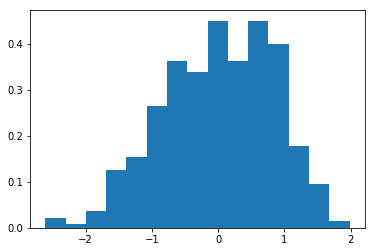

In [35]:
plt.hist(localtest_pred[y_localtest_label == 1], bins='auto', density = True)
plt.show()

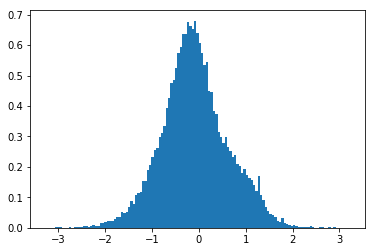

In [36]:
plt.hist(localtest_pred[y_localtest_label == 0], bins='auto', density = True)
plt.show()

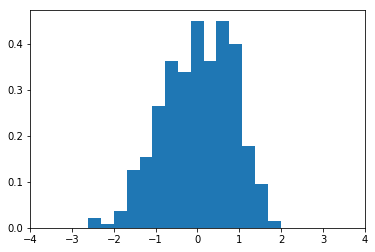

In [37]:
plt.xlim(-4, 4)
plt.hist(localtest_pred[y_localtest_label == 1], bins='auto', density = True)
plt.show()

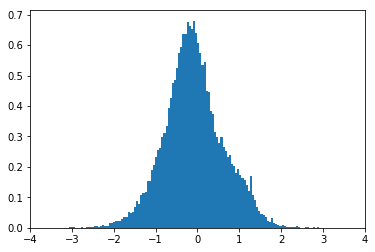

In [38]:
plt.xlim(-4, 4)
plt.hist(localtest_pred[y_localtest_label == 0], bins='auto', density = True)
plt.show()

#### Feature importances

In [39]:
cbr.get_feature_importance()

[0.0,
 0.0,
 1.4095349630358425,
 0.3392910091447688,
 0.07878962530207588,
 0.7522308074363339,
 0.0,
 0.40501984831634336,
 0.2729900620028854,
 0.00337064862220429,
 0.018027397020074644,
 0.0,
 0.0,
 0.13273042142214705,
 0.4333089911631603,
 0.5231762262987885,
 0.5512075704839672,
 0.01736178814139288,
 0.21474995776248862,
 0.017606483807355897,
 0.07397312693600933,
 0.07875596168251288,
 0.0,
 0.4442545596019573,
 0.0035960114289061377,
 0.09577757587553098,
 0.8403235073728116,
 0.38561254904959064,
 0.0,
 0.0,
 1.149029175247359,
 0.05760735456313729,
 0.006021394774989379,
 0.053534828853597144,
 0.08921473592799754,
 0.3551358799929899,
 0.004840037886638307,
 0.027547921454534816,
 0.6023001613556979,
 0.022562520390560604,
 0.3900036928314705,
 1.4643111320564486,
 1.6184036294256146,
 1.5484885432794604,
 0.5210189895163204,
 0.7905338494662333,
 0.6622613011464384,
 0.18607906622059278,
 0.04104086896192723,
 0.08848675551343536,
 0.0,
 0.0,
 0.09632529920392405,
 0.14

In [40]:
feature_score = pd.DataFrame(list(zip(X_train_restricted.dtypes.index, cbr.get_feature_importance())),
                             columns = ['Feature','Score'])

feature_score = feature_score.sort_values(by ='Score', ascending = False, inplace = False, kind = 'quicksort', 
                                          na_position = 'last')

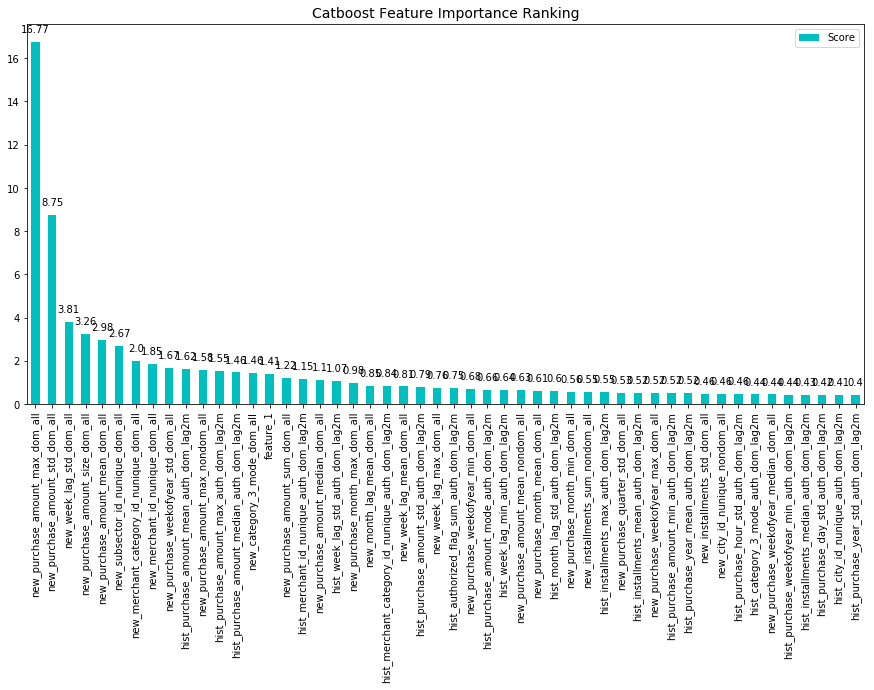

In [42]:
plt.rcParams["figure.figsize"] = (15,7)
ax = feature_score[:50].plot('Feature', 'Score', kind = 'bar', color = 'c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [43]:
pickle.dump(feature_score, open(DIRECTORY + 'catboost_regr_feat_importances_15_notebook.p', 'wb'))

### Train on all inliers (including localtest data) to generate submission

In [44]:
# Use only inliers to train the regressor
X_localtest_restricted = X_localtest[y_localtest_label == 0].copy()
y_localtest_restricted = y_localtest[y_localtest_label == 0].copy()

In [45]:
X_all_inliers = pd.concat([X_train_restricted, X_localtest_restricted])
y_all_inliers = y_train_restricted + y_localtest_restricted

In [46]:
X_all_inliers['target'] = y_all_inliers
X_all_inliers = X_all_inliers.sample(frac = 1).reset_index(drop = True)
y_all_inliers = X_all_inliers['target'].copy()
X_all_inliers.drop('target', axis = 1, inplace = True)

In [47]:
X_all_inliers.shape, y_all_inliers.shape

((199710, 487), (199710,))

In [48]:
X_all_inliers.head()

first_active_month  card_id  feature_1  feature_2  feature_3  \
0                  63    35248          4          1          1   
1                  67    19712          1          1          0   
2                  60   140667          4          1          1   
3                  58    15091          0          2          0   
4                  66    38380          4          0          1   

   hist_authorized_flag_sum_auth_dom_lag2m  \
0                                      6.0   
1                                     88.0   
2                                     47.0   
3                                      5.0   
4                                     22.0   

   hist_authorized_flag_mean_auth_dom_lag2m  \
0                                       1.0   
1                                       1.0   
2                                       1.0   
3                                       1.0   
4                                       1.0   

   hist_city_id_nunique_auth_dom_lag2m  hist_city_id_mode_auth_dom_lag2m  \
0                                  2.0                               234   
1                                  5.0                               292   
2                                  5.0                               166   
3                                  2.0                                74   
4                                  2.0                                16   

   hist_city_id_nancnt_auth_dom_lag2m  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

                      ...                      \
0                     ...                       
1                     ...                       
2                     ...                       
3                     ...                       
4                     ...                       

   avg_sales_lag6_new_merchant_id_mode_nondom_all  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   

   avg_purchases_lag6_new_merchant_id_mode_nondom_all  \
0                                                NaN    
1                                                NaN    
2                                                NaN    
3                                                NaN    
4                                                NaN    

   active_months_lag6_new_merchant_id_mode_nondom_all  \
0                                                NaN    
1                                                NaN    
2                                                NaN    
3                                                NaN    
4                                                NaN    

   avg_sales_lag12_new_merchant_id_mode_nondom_all  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

   avg_purchases_lag12_new_merchant_id_mode_nondom_all  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

   active_months_lag12_new_merchant_id_mode_nondom_all  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

   category_4

In [49]:
ignored_features = ['first_active_month', 'card_id']
for col in categorical_features:
    X_all_inliers[col] = X_all_inliers[col].astype('category').cat.codes
categorical_features_indices = [X_all_inliers.columns.get_loc(i) for i in categorical_features]
ignored_features_indices = [X_all_inliers.columns.get_loc(i) for i in ignored_features]

seed = 1
n_jobs = 8
cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = ignored_features_indices, random_seed = seed,
                        thread_count = n_jobs)
cbr.fit(X_all_inliers, y_all_inliers, cat_features = categorical_features_indices, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: nan	total: 140ms	remaining: 23m 22s


Training has stopped (degenerate solution on iteration 0, probably too small l2-regularization, try to increase it)


In [50]:
params['l2_leaf_reg']

3000

In [52]:
cbr.get_params()

{'iterations': 10000,
 'learning_rate': 0.1,
 'depth': 3,
 'l2_leaf_reg': 3000,
 'loss_function': 'RMSE',
 'thread_count': 8,
 'random_seed': 1,
 'ignored_features': [0, 1]}

In [53]:
params['l2_leaf_reg'] = 10000

cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = ignored_features_indices, random_seed = seed,
                        thread_count = n_jobs)
cbr.fit(X_all_inliers, y_all_inliers, cat_features = categorical_features_indices, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: nan	total: 144ms	remaining: 24m


Training has stopped (degenerate solution on iteration 0, probably too small l2-regularization, try to increase it)


In [54]:
cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = ignored_features_indices, random_seed = seed,
                        thread_count = n_jobs)
cbr.fit(X_train_restricted, y_train_restricted, cat_features = categorical_features_indices, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7071536	total: 266ms	remaining: 44m 21s
1:	learn: 1.6982142	total: 561ms	remaining: 46m 46s
2:	learn: 1.6910187	total: 867ms	remaining: 48m 8s
3:	learn: 1.6845601	total: 1.15s	remaining: 47m 50s
4:	learn: 1.6780780	total: 1.42s	remaining: 47m 22s
5:	learn: 1.6734007	total: 1.64s	remaining: 45m 37s
6:	learn: 1.6688038	total: 1.92s	remaining: 45m 37s
7:	learn: 1.6646481	total: 2.16s	remaining: 45m 1s
8:	learn: 1.6607799	total: 2.43s	remaining: 45m 1s
9:	learn: 1.6575724	total: 2.66s	remaining: 44m 22s
10:	learn: 1.6546446	total: 2.94s	remaining: 44m 27s
11:	learn: 1.6519603	total: 3.27s	remaining: 45m 24s
12:	learn: 1.6496863	total: 3.52s	remaining: 45m 4s
13:	learn: 1.6477324	total: 3.76s	remaining: 44m 41s
14:	learn: 1.6457005	total: 4.12s	remaining: 45m 45s
15:	learn: 1.6440678	total: 4.38s	remaining: 45m 35s
16:	learn: 1.6422060	total: 4.64s	remaining: 45m 25s
17:	learn: 1.6406775	total: 4.87s	remaining: 45m 3s
18:	learn: 1.6392110	total: 5.14s	remaining: 44m 58s
19:	lear

155:	learn: 1.5993140	total: 37.9s	remaining: 39m 50s
156:	learn: 1.5992804	total: 38.1s	remaining: 39m 49s
157:	learn: 1.5992574	total: 38.3s	remaining: 39m 47s
158:	learn: 1.5989474	total: 38.6s	remaining: 39m 47s
159:	learn: 1.5987154	total: 38.8s	remaining: 39m 47s
160:	learn: 1.5984000	total: 39.1s	remaining: 39m 48s
161:	learn: 1.5981751	total: 39.3s	remaining: 39m 48s
162:	learn: 1.5979924	total: 39.6s	remaining: 39m 47s
163:	learn: 1.5979497	total: 39.8s	remaining: 39m 45s
164:	learn: 1.5977556	total: 40s	remaining: 39m 44s
165:	learn: 1.5977149	total: 40.3s	remaining: 39m 44s
166:	learn: 1.5975052	total: 40.5s	remaining: 39m 45s
167:	learn: 1.5973412	total: 40.7s	remaining: 39m 44s
168:	learn: 1.5972931	total: 41s	remaining: 39m 44s
169:	learn: 1.5972694	total: 41.2s	remaining: 39m 42s
170:	learn: 1.5972585	total: 41.5s	remaining: 39m 42s
171:	learn: 1.5970669	total: 41.7s	remaining: 39m 41s
172:	learn: 1.5970459	total: 41.9s	remaining: 39m 40s
173:	learn: 1.5968011	total: 42.

308:	learn: 1.5859317	total: 1m 14s	remaining: 38m 52s
309:	learn: 1.5858069	total: 1m 14s	remaining: 38m 52s
310:	learn: 1.5857984	total: 1m 14s	remaining: 38m 52s
311:	learn: 1.5857923	total: 1m 15s	remaining: 38m 51s
312:	learn: 1.5856299	total: 1m 15s	remaining: 38m 51s
313:	learn: 1.5855049	total: 1m 15s	remaining: 38m 51s
314:	learn: 1.5853870	total: 1m 15s	remaining: 38m 50s
315:	learn: 1.5852313	total: 1m 16s	remaining: 38m 51s
316:	learn: 1.5852158	total: 1m 16s	remaining: 38m 50s
317:	learn: 1.5852109	total: 1m 16s	remaining: 38m 49s
318:	learn: 1.5851297	total: 1m 16s	remaining: 38m 49s
319:	learn: 1.5849763	total: 1m 17s	remaining: 38m 49s
320:	learn: 1.5848635	total: 1m 17s	remaining: 38m 49s
321:	learn: 1.5847882	total: 1m 17s	remaining: 38m 49s
322:	learn: 1.5847816	total: 1m 17s	remaining: 38m 48s
323:	learn: 1.5847320	total: 1m 17s	remaining: 38m 47s
324:	learn: 1.5846024	total: 1m 18s	remaining: 38m 48s
325:	learn: 1.5845214	total: 1m 18s	remaining: 38m 48s
326:	learn

457:	learn: 1.5793787	total: 1m 50s	remaining: 38m 15s
458:	learn: 1.5793760	total: 1m 50s	remaining: 38m 15s
459:	learn: 1.5793679	total: 1m 50s	remaining: 38m 14s
460:	learn: 1.5793039	total: 1m 50s	remaining: 38m 15s
461:	learn: 1.5792267	total: 1m 51s	remaining: 38m 15s
462:	learn: 1.5791926	total: 1m 51s	remaining: 38m 14s
463:	learn: 1.5791847	total: 1m 51s	remaining: 38m 14s
464:	learn: 1.5791125	total: 1m 51s	remaining: 38m 14s
465:	learn: 1.5791073	total: 1m 52s	remaining: 38m 14s
466:	learn: 1.5791024	total: 1m 52s	remaining: 38m 13s
467:	learn: 1.5790454	total: 1m 52s	remaining: 38m 14s
468:	learn: 1.5790418	total: 1m 52s	remaining: 38m 13s
469:	learn: 1.5790358	total: 1m 53s	remaining: 38m 13s
470:	learn: 1.5790312	total: 1m 53s	remaining: 38m 12s
471:	learn: 1.5789831	total: 1m 53s	remaining: 38m 12s
472:	learn: 1.5789706	total: 1m 53s	remaining: 38m 11s
473:	learn: 1.5789215	total: 1m 54s	remaining: 38m 12s
474:	learn: 1.5789073	total: 1m 54s	remaining: 38m 11s
475:	learn

608:	learn: 1.5751194	total: 2m 27s	remaining: 37m 46s
609:	learn: 1.5750925	total: 2m 27s	remaining: 37m 46s
610:	learn: 1.5750771	total: 2m 27s	remaining: 37m 46s
611:	learn: 1.5750423	total: 2m 27s	remaining: 37m 46s
612:	learn: 1.5750277	total: 2m 27s	remaining: 37m 46s
613:	learn: 1.5749684	total: 2m 28s	remaining: 37m 46s
614:	learn: 1.5749397	total: 2m 28s	remaining: 37m 45s
615:	learn: 1.5749378	total: 2m 28s	remaining: 37m 45s
616:	learn: 1.5749091	total: 2m 28s	remaining: 37m 45s
617:	learn: 1.5748996	total: 2m 29s	remaining: 37m 44s
618:	learn: 1.5748977	total: 2m 29s	remaining: 37m 44s
619:	learn: 1.5748939	total: 2m 29s	remaining: 37m 44s
620:	learn: 1.5748914	total: 2m 29s	remaining: 37m 43s
621:	learn: 1.5748880	total: 2m 30s	remaining: 37m 43s
622:	learn: 1.5748843	total: 2m 30s	remaining: 37m 42s
623:	learn: 1.5748796	total: 2m 30s	remaining: 37m 42s
624:	learn: 1.5748567	total: 2m 30s	remaining: 37m 42s
625:	learn: 1.5748542	total: 2m 31s	remaining: 37m 41s
626:	learn

758:	learn: 1.5723631	total: 3m 3s	remaining: 37m 13s
759:	learn: 1.5723209	total: 3m 3s	remaining: 37m 13s
760:	learn: 1.5722923	total: 3m 3s	remaining: 37m 12s
761:	learn: 1.5722787	total: 3m 4s	remaining: 37m 12s
762:	learn: 1.5722679	total: 3m 4s	remaining: 37m 12s
763:	learn: 1.5722659	total: 3m 4s	remaining: 37m 11s
764:	learn: 1.5722437	total: 3m 4s	remaining: 37m 11s
765:	learn: 1.5722386	total: 3m 5s	remaining: 37m 11s
766:	learn: 1.5721998	total: 3m 5s	remaining: 37m 11s
767:	learn: 1.5721958	total: 3m 5s	remaining: 37m 11s
768:	learn: 1.5721881	total: 3m 5s	remaining: 37m 10s
769:	learn: 1.5721869	total: 3m 6s	remaining: 37m 10s
770:	learn: 1.5721766	total: 3m 6s	remaining: 37m 10s
771:	learn: 1.5721450	total: 3m 6s	remaining: 37m 10s
772:	learn: 1.5721439	total: 3m 6s	remaining: 37m 10s
773:	learn: 1.5721431	total: 3m 7s	remaining: 37m 10s
774:	learn: 1.5721106	total: 3m 7s	remaining: 37m 10s
775:	learn: 1.5720847	total: 3m 7s	remaining: 37m 9s
776:	learn: 1.5720563	total: 

909:	learn: 1.5702208	total: 3m 39s	remaining: 36m 37s
910:	learn: 1.5702023	total: 3m 40s	remaining: 36m 36s
911:	learn: 1.5701773	total: 3m 40s	remaining: 36m 36s
912:	learn: 1.5701758	total: 3m 40s	remaining: 36m 36s
913:	learn: 1.5701278	total: 3m 40s	remaining: 36m 36s
914:	learn: 1.5701178	total: 3m 41s	remaining: 36m 36s
915:	learn: 1.5701003	total: 3m 41s	remaining: 36m 35s
916:	learn: 1.5700819	total: 3m 41s	remaining: 36m 35s
917:	learn: 1.5700721	total: 3m 41s	remaining: 36m 35s
918:	learn: 1.5700616	total: 3m 42s	remaining: 36m 35s
919:	learn: 1.5700488	total: 3m 42s	remaining: 36m 34s
920:	learn: 1.5700485	total: 3m 42s	remaining: 36m 34s
921:	learn: 1.5700461	total: 3m 42s	remaining: 36m 34s
922:	learn: 1.5700115	total: 3m 43s	remaining: 36m 34s
923:	learn: 1.5699680	total: 3m 43s	remaining: 36m 34s
924:	learn: 1.5699640	total: 3m 43s	remaining: 36m 34s
925:	learn: 1.5699332	total: 3m 43s	remaining: 36m 34s
926:	learn: 1.5699149	total: 3m 44s	remaining: 36m 34s
927:	learn

1059:	learn: 1.5680678	total: 4m 16s	remaining: 36m 6s
1060:	learn: 1.5680668	total: 4m 17s	remaining: 36m 6s
1061:	learn: 1.5680642	total: 4m 17s	remaining: 36m 6s
1062:	learn: 1.5680410	total: 4m 17s	remaining: 36m 6s
1063:	learn: 1.5680399	total: 4m 17s	remaining: 36m 6s
1064:	learn: 1.5680150	total: 4m 18s	remaining: 36m 5s
1065:	learn: 1.5680024	total: 4m 18s	remaining: 36m 5s
1066:	learn: 1.5679799	total: 4m 18s	remaining: 36m 5s
1067:	learn: 1.5679699	total: 4m 18s	remaining: 36m 5s
1068:	learn: 1.5679522	total: 4m 19s	remaining: 36m 5s
1069:	learn: 1.5679345	total: 4m 19s	remaining: 36m 4s
1070:	learn: 1.5678974	total: 4m 19s	remaining: 36m 4s
1071:	learn: 1.5678687	total: 4m 19s	remaining: 36m 4s
1072:	learn: 1.5678682	total: 4m 20s	remaining: 36m 4s
1073:	learn: 1.5678342	total: 4m 20s	remaining: 36m 4s
1074:	learn: 1.5678207	total: 4m 20s	remaining: 36m 4s
1075:	learn: 1.5677915	total: 4m 20s	remaining: 36m 3s
1076:	learn: 1.5677820	total: 4m 21s	remaining: 36m 3s
1077:	lear

1207:	learn: 1.5664082	total: 4m 53s	remaining: 35m 36s
1208:	learn: 1.5663855	total: 4m 53s	remaining: 35m 36s
1209:	learn: 1.5663843	total: 4m 54s	remaining: 35m 36s
1210:	learn: 1.5663649	total: 4m 54s	remaining: 35m 36s
1211:	learn: 1.5663640	total: 4m 54s	remaining: 35m 36s
1212:	learn: 1.5663561	total: 4m 54s	remaining: 35m 35s
1213:	learn: 1.5663560	total: 4m 55s	remaining: 35m 35s
1214:	learn: 1.5663206	total: 4m 55s	remaining: 35m 35s
1215:	learn: 1.5663041	total: 4m 55s	remaining: 35m 35s
1216:	learn: 1.5662945	total: 4m 55s	remaining: 35m 35s
1217:	learn: 1.5662914	total: 4m 56s	remaining: 35m 34s
1218:	learn: 1.5662846	total: 4m 56s	remaining: 35m 34s
1219:	learn: 1.5662819	total: 4m 56s	remaining: 35m 34s
1220:	learn: 1.5662638	total: 4m 56s	remaining: 35m 34s
1221:	learn: 1.5662500	total: 4m 57s	remaining: 35m 33s
1222:	learn: 1.5662324	total: 4m 57s	remaining: 35m 33s
1223:	learn: 1.5662279	total: 4m 57s	remaining: 35m 33s
1224:	learn: 1.5662216	total: 4m 57s	remaining: 

1355:	learn: 1.5649500	total: 5m 36s	remaining: 35m 44s
1356:	learn: 1.5649490	total: 5m 36s	remaining: 35m 44s
1357:	learn: 1.5649480	total: 5m 37s	remaining: 35m 44s
1358:	learn: 1.5649261	total: 5m 37s	remaining: 35m 44s
1359:	learn: 1.5649243	total: 5m 37s	remaining: 35m 45s
1360:	learn: 1.5649092	total: 5m 37s	remaining: 35m 44s
1361:	learn: 1.5649084	total: 5m 38s	remaining: 35m 44s
1362:	learn: 1.5649040	total: 5m 38s	remaining: 35m 45s
1363:	learn: 1.5648894	total: 5m 38s	remaining: 35m 45s
1364:	learn: 1.5648735	total: 5m 39s	remaining: 35m 45s
1365:	learn: 1.5648688	total: 5m 39s	remaining: 35m 45s
1366:	learn: 1.5648649	total: 5m 39s	remaining: 35m 46s
1367:	learn: 1.5648627	total: 5m 40s	remaining: 35m 46s
1368:	learn: 1.5648600	total: 5m 40s	remaining: 35m 46s
1369:	learn: 1.5648471	total: 5m 40s	remaining: 35m 46s
1370:	learn: 1.5648448	total: 5m 41s	remaining: 35m 46s
1371:	learn: 1.5648337	total: 5m 41s	remaining: 35m 46s
1372:	learn: 1.5648165	total: 5m 41s	remaining: 

1503:	learn: 1.5637790	total: 6m 22s	remaining: 36m 1s
1504:	learn: 1.5637787	total: 6m 23s	remaining: 36m 2s
1505:	learn: 1.5637776	total: 6m 23s	remaining: 36m 2s
1506:	learn: 1.5637766	total: 6m 23s	remaining: 36m 2s
1507:	learn: 1.5637746	total: 6m 24s	remaining: 36m 2s
1508:	learn: 1.5637504	total: 6m 24s	remaining: 36m 2s
1509:	learn: 1.5637482	total: 6m 24s	remaining: 36m 2s
1510:	learn: 1.5637427	total: 6m 25s	remaining: 36m 3s
1511:	learn: 1.5637395	total: 6m 25s	remaining: 36m 3s
1512:	learn: 1.5637246	total: 6m 25s	remaining: 36m 3s
1513:	learn: 1.5637241	total: 6m 25s	remaining: 36m 3s
1514:	learn: 1.5637194	total: 6m 26s	remaining: 36m 3s
1515:	learn: 1.5636932	total: 6m 26s	remaining: 36m 3s
1516:	learn: 1.5636911	total: 6m 26s	remaining: 36m 3s
1517:	learn: 1.5636898	total: 6m 27s	remaining: 36m 3s
1518:	learn: 1.5636883	total: 6m 27s	remaining: 36m 3s
1519:	learn: 1.5636762	total: 6m 27s	remaining: 36m 3s
1520:	learn: 1.5636706	total: 6m 28s	remaining: 36m 4s
1521:	lear

1652:	learn: 1.5627774	total: 7m 10s	remaining: 36m 11s
1653:	learn: 1.5627770	total: 7m 10s	remaining: 36m 12s
1654:	learn: 1.5627728	total: 7m 10s	remaining: 36m 12s
1655:	learn: 1.5627622	total: 7m 11s	remaining: 36m 12s
1656:	learn: 1.5627534	total: 7m 11s	remaining: 36m 12s
1657:	learn: 1.5627410	total: 7m 11s	remaining: 36m 12s
1658:	learn: 1.5627407	total: 7m 12s	remaining: 36m 12s
1659:	learn: 1.5627115	total: 7m 12s	remaining: 36m 12s
1660:	learn: 1.5627069	total: 7m 12s	remaining: 36m 12s
1661:	learn: 1.5627066	total: 7m 13s	remaining: 36m 12s
1662:	learn: 1.5626965	total: 7m 13s	remaining: 36m 12s
1663:	learn: 1.5626956	total: 7m 13s	remaining: 36m 12s
1664:	learn: 1.5626955	total: 7m 14s	remaining: 36m 12s
1665:	learn: 1.5626879	total: 7m 14s	remaining: 36m 12s
1666:	learn: 1.5626866	total: 7m 14s	remaining: 36m 12s
1667:	learn: 1.5626743	total: 7m 14s	remaining: 36m 12s
1668:	learn: 1.5626707	total: 7m 15s	remaining: 36m 12s
1669:	learn: 1.5626705	total: 7m 15s	remaining: 

1799:	learn: 1.5618008	total: 7m 56s	remaining: 36m 10s
1800:	learn: 1.5617936	total: 7m 56s	remaining: 36m 10s
1801:	learn: 1.5617924	total: 7m 57s	remaining: 36m 10s
1802:	learn: 1.5617877	total: 7m 57s	remaining: 36m 10s
1803:	learn: 1.5617803	total: 7m 57s	remaining: 36m 10s
1804:	learn: 1.5617529	total: 7m 58s	remaining: 36m 10s
1805:	learn: 1.5617517	total: 7m 58s	remaining: 36m 10s
1806:	learn: 1.5617281	total: 7m 58s	remaining: 36m 10s
1807:	learn: 1.5617252	total: 7m 58s	remaining: 36m 9s
1808:	learn: 1.5617160	total: 7m 59s	remaining: 36m 10s
1809:	learn: 1.5617055	total: 7m 59s	remaining: 36m 10s
1810:	learn: 1.5616958	total: 7m 59s	remaining: 36m 10s
1811:	learn: 1.5616954	total: 8m	remaining: 36m 10s
1812:	learn: 1.5616917	total: 8m	remaining: 36m 10s
1813:	learn: 1.5616899	total: 8m	remaining: 36m 10s
1814:	learn: 1.5616830	total: 8m 1s	remaining: 36m 10s
1815:	learn: 1.5616815	total: 8m 1s	remaining: 36m 10s
1816:	learn: 1.5616634	total: 8m 1s	remaining: 36m 10s
1817:	le

1949:	learn: 1.5607493	total: 8m 43s	remaining: 36m 2s
1950:	learn: 1.5607307	total: 8m 44s	remaining: 36m 2s
1951:	learn: 1.5607263	total: 8m 44s	remaining: 36m 2s
1952:	learn: 1.5607200	total: 8m 44s	remaining: 36m 2s
1953:	learn: 1.5607196	total: 8m 45s	remaining: 36m 2s
1954:	learn: 1.5607171	total: 8m 45s	remaining: 36m 2s
1955:	learn: 1.5607166	total: 8m 45s	remaining: 36m 2s
1956:	learn: 1.5607113	total: 8m 46s	remaining: 36m 1s
1957:	learn: 1.5606958	total: 8m 46s	remaining: 36m 1s
1958:	learn: 1.5606950	total: 8m 46s	remaining: 36m 1s
1959:	learn: 1.5606890	total: 8m 47s	remaining: 36m 1s
1960:	learn: 1.5606886	total: 8m 47s	remaining: 36m 1s
1961:	learn: 1.5606842	total: 8m 47s	remaining: 36m 1s
1962:	learn: 1.5606828	total: 8m 47s	remaining: 36m 1s
1963:	learn: 1.5606673	total: 8m 48s	remaining: 36m 1s
1964:	learn: 1.5606573	total: 8m 48s	remaining: 36m 1s
1965:	learn: 1.5606493	total: 8m 48s	remaining: 36m 1s
1966:	learn: 1.5606487	total: 8m 49s	remaining: 36m 1s
1967:	lear

2098:	learn: 1.5598186	total: 9m 30s	remaining: 35m 48s
2099:	learn: 1.5598089	total: 9m 31s	remaining: 35m 48s
2100:	learn: 1.5598079	total: 9m 31s	remaining: 35m 48s
2101:	learn: 1.5598071	total: 9m 31s	remaining: 35m 48s
2102:	learn: 1.5597962	total: 9m 32s	remaining: 35m 48s
2103:	learn: 1.5597912	total: 9m 32s	remaining: 35m 48s
2104:	learn: 1.5597879	total: 9m 32s	remaining: 35m 48s
2105:	learn: 1.5597868	total: 9m 33s	remaining: 35m 47s
2106:	learn: 1.5597863	total: 9m 33s	remaining: 35m 47s
2107:	learn: 1.5597827	total: 9m 33s	remaining: 35m 47s
2108:	learn: 1.5597792	total: 9m 33s	remaining: 35m 47s
2109:	learn: 1.5597676	total: 9m 34s	remaining: 35m 47s
2110:	learn: 1.5597610	total: 9m 34s	remaining: 35m 47s
2111:	learn: 1.5597576	total: 9m 34s	remaining: 35m 47s
2112:	learn: 1.5597487	total: 9m 35s	remaining: 35m 47s
2113:	learn: 1.5597486	total: 9m 35s	remaining: 35m 47s
2114:	learn: 1.5597472	total: 9m 35s	remaining: 35m 46s
2115:	learn: 1.5597457	total: 9m 36s	remaining: 

2245:	learn: 1.5589993	total: 10m 16s	remaining: 35m 28s
2246:	learn: 1.5589808	total: 10m 16s	remaining: 35m 28s
2247:	learn: 1.5589774	total: 10m 17s	remaining: 35m 28s
2248:	learn: 1.5589763	total: 10m 17s	remaining: 35m 28s
2249:	learn: 1.5589749	total: 10m 17s	remaining: 35m 27s
2250:	learn: 1.5589670	total: 10m 18s	remaining: 35m 27s
2251:	learn: 1.5589633	total: 10m 18s	remaining: 35m 27s
2252:	learn: 1.5589602	total: 10m 18s	remaining: 35m 27s
2253:	learn: 1.5589601	total: 10m 19s	remaining: 35m 27s
2254:	learn: 1.5589570	total: 10m 19s	remaining: 35m 27s
2255:	learn: 1.5589519	total: 10m 19s	remaining: 35m 27s
2256:	learn: 1.5589384	total: 10m 20s	remaining: 35m 27s
2257:	learn: 1.5589341	total: 10m 20s	remaining: 35m 26s
2258:	learn: 1.5589328	total: 10m 20s	remaining: 35m 26s
2259:	learn: 1.5589294	total: 10m 20s	remaining: 35m 26s
2260:	learn: 1.5589290	total: 10m 21s	remaining: 35m 26s
2261:	learn: 1.5589272	total: 10m 21s	remaining: 35m 26s
2262:	learn: 1.5589266	total: 1

2390:	learn: 1.5581561	total: 11m 2s	remaining: 35m 9s
2391:	learn: 1.5581469	total: 11m 3s	remaining: 35m 8s
2392:	learn: 1.5581458	total: 11m 3s	remaining: 35m 8s
2393:	learn: 1.5581431	total: 11m 3s	remaining: 35m 8s
2394:	learn: 1.5581404	total: 11m 3s	remaining: 35m 8s
2395:	learn: 1.5581399	total: 11m 4s	remaining: 35m 8s
2396:	learn: 1.5581284	total: 11m 4s	remaining: 35m 8s
2397:	learn: 1.5581274	total: 11m 4s	remaining: 35m 7s
2398:	learn: 1.5581191	total: 11m 5s	remaining: 35m 7s
2399:	learn: 1.5581156	total: 11m 5s	remaining: 35m 7s
2400:	learn: 1.5581122	total: 11m 5s	remaining: 35m 7s
2401:	learn: 1.5581093	total: 11m 6s	remaining: 35m 7s
2402:	learn: 1.5581086	total: 11m 6s	remaining: 35m 7s
2403:	learn: 1.5581021	total: 11m 6s	remaining: 35m 6s
2404:	learn: 1.5580937	total: 11m 7s	remaining: 35m 6s
2405:	learn: 1.5580927	total: 11m 7s	remaining: 35m 6s
2406:	learn: 1.5580898	total: 11m 7s	remaining: 35m 6s
2407:	learn: 1.5580875	total: 11m 8s	remaining: 35m 6s
2408:	lear

2536:	learn: 1.5574039	total: 11m 48s	remaining: 34m 45s
2537:	learn: 1.5573941	total: 11m 49s	remaining: 34m 45s
2538:	learn: 1.5573876	total: 11m 49s	remaining: 34m 44s
2539:	learn: 1.5573841	total: 11m 49s	remaining: 34m 44s
2540:	learn: 1.5573839	total: 11m 50s	remaining: 34m 44s
2541:	learn: 1.5573791	total: 11m 50s	remaining: 34m 44s
2542:	learn: 1.5573720	total: 11m 50s	remaining: 34m 43s
2543:	learn: 1.5573650	total: 11m 50s	remaining: 34m 43s
2544:	learn: 1.5573616	total: 11m 51s	remaining: 34m 43s
2545:	learn: 1.5573472	total: 11m 51s	remaining: 34m 43s
2546:	learn: 1.5573389	total: 11m 51s	remaining: 34m 43s
2547:	learn: 1.5573287	total: 11m 52s	remaining: 34m 42s
2548:	learn: 1.5573272	total: 11m 52s	remaining: 34m 42s
2549:	learn: 1.5573269	total: 11m 52s	remaining: 34m 42s
2550:	learn: 1.5573250	total: 11m 53s	remaining: 34m 42s
2551:	learn: 1.5573185	total: 11m 53s	remaining: 34m 42s
2552:	learn: 1.5573180	total: 11m 53s	remaining: 34m 42s
2553:	learn: 1.5573179	total: 1

2682:	learn: 1.5567114	total: 12m 27s	remaining: 33m 58s
2683:	learn: 1.5567069	total: 12m 27s	remaining: 33m 57s
2684:	learn: 1.5567047	total: 12m 27s	remaining: 33m 57s
2685:	learn: 1.5567045	total: 12m 28s	remaining: 33m 57s
2686:	learn: 1.5567019	total: 12m 28s	remaining: 33m 56s
2687:	learn: 1.5567012	total: 12m 28s	remaining: 33m 56s
2688:	learn: 1.5566999	total: 12m 28s	remaining: 33m 56s
2689:	learn: 1.5566895	total: 12m 29s	remaining: 33m 55s
2690:	learn: 1.5566891	total: 12m 29s	remaining: 33m 55s
2691:	learn: 1.5566886	total: 12m 29s	remaining: 33m 55s
2692:	learn: 1.5566774	total: 12m 29s	remaining: 33m 54s
2693:	learn: 1.5566769	total: 12m 30s	remaining: 33m 54s
2694:	learn: 1.5566718	total: 12m 30s	remaining: 33m 54s
2695:	learn: 1.5566659	total: 12m 30s	remaining: 33m 53s
2696:	learn: 1.5566580	total: 12m 30s	remaining: 33m 53s
2697:	learn: 1.5566565	total: 12m 31s	remaining: 33m 52s
2698:	learn: 1.5566515	total: 12m 31s	remaining: 33m 52s
2699:	learn: 1.5566507	total: 1

2827:	learn: 1.5560460	total: 13m 3s	remaining: 33m 7s
2828:	learn: 1.5560427	total: 13m 4s	remaining: 33m 7s
2829:	learn: 1.5560422	total: 13m 4s	remaining: 33m 7s
2830:	learn: 1.5560280	total: 13m 4s	remaining: 33m 6s
2831:	learn: 1.5560235	total: 13m 4s	remaining: 33m 6s
2832:	learn: 1.5560225	total: 13m 5s	remaining: 33m 6s
2833:	learn: 1.5560224	total: 13m 5s	remaining: 33m 5s
2834:	learn: 1.5560219	total: 13m 5s	remaining: 33m 5s
2835:	learn: 1.5560189	total: 13m 5s	remaining: 33m 5s
2836:	learn: 1.5560175	total: 13m 6s	remaining: 33m 4s
2837:	learn: 1.5560061	total: 13m 6s	remaining: 33m 4s
2838:	learn: 1.5559996	total: 13m 6s	remaining: 33m 4s
2839:	learn: 1.5559924	total: 13m 6s	remaining: 33m 3s
2840:	learn: 1.5559877	total: 13m 7s	remaining: 33m 3s
2841:	learn: 1.5559869	total: 13m 7s	remaining: 33m 3s
2842:	learn: 1.5559863	total: 13m 7s	remaining: 33m 2s
2843:	learn: 1.5559857	total: 13m 7s	remaining: 33m 2s
2844:	learn: 1.5559793	total: 13m 8s	remaining: 33m 2s
2845:	lear

2972:	learn: 1.5553601	total: 13m 40s	remaining: 32m 18s
2973:	learn: 1.5553514	total: 13m 40s	remaining: 32m 18s
2974:	learn: 1.5553475	total: 13m 40s	remaining: 32m 18s
2975:	learn: 1.5553467	total: 13m 41s	remaining: 32m 17s
2976:	learn: 1.5553460	total: 13m 41s	remaining: 32m 17s
2977:	learn: 1.5553311	total: 13m 41s	remaining: 32m 17s
2978:	learn: 1.5553195	total: 13m 41s	remaining: 32m 16s
2979:	learn: 1.5553141	total: 13m 42s	remaining: 32m 16s
2980:	learn: 1.5553080	total: 13m 42s	remaining: 32m 16s
2981:	learn: 1.5552963	total: 13m 42s	remaining: 32m 15s
2982:	learn: 1.5552959	total: 13m 42s	remaining: 32m 15s
2983:	learn: 1.5552947	total: 13m 43s	remaining: 32m 15s
2984:	learn: 1.5552941	total: 13m 43s	remaining: 32m 14s
2985:	learn: 1.5552821	total: 13m 43s	remaining: 32m 14s
2986:	learn: 1.5552792	total: 13m 43s	remaining: 32m 14s
2987:	learn: 1.5552732	total: 13m 44s	remaining: 32m 13s
2988:	learn: 1.5552719	total: 13m 44s	remaining: 32m 13s
2989:	learn: 1.5552709	total: 1

3118:	learn: 1.5547005	total: 14m 16s	remaining: 31m 30s
3119:	learn: 1.5546935	total: 14m 16s	remaining: 31m 29s
3120:	learn: 1.5546877	total: 14m 17s	remaining: 31m 29s
3121:	learn: 1.5546846	total: 14m 17s	remaining: 31m 29s
3122:	learn: 1.5546795	total: 14m 17s	remaining: 31m 28s
3123:	learn: 1.5546770	total: 14m 17s	remaining: 31m 28s
3124:	learn: 1.5546760	total: 14m 18s	remaining: 31m 28s
3125:	learn: 1.5546749	total: 14m 18s	remaining: 31m 27s
3126:	learn: 1.5546497	total: 14m 18s	remaining: 31m 27s
3127:	learn: 1.5546440	total: 14m 18s	remaining: 31m 27s
3128:	learn: 1.5546374	total: 14m 19s	remaining: 31m 26s
3129:	learn: 1.5546366	total: 14m 19s	remaining: 31m 26s
3130:	learn: 1.5546301	total: 14m 19s	remaining: 31m 26s
3131:	learn: 1.5546243	total: 14m 19s	remaining: 31m 25s
3132:	learn: 1.5546218	total: 14m 20s	remaining: 31m 25s
3133:	learn: 1.5546168	total: 14m 20s	remaining: 31m 25s
3134:	learn: 1.5546149	total: 14m 20s	remaining: 31m 24s
3135:	learn: 1.5546136	total: 1

3263:	learn: 1.5540575	total: 14m 53s	remaining: 30m 42s
3264:	learn: 1.5540538	total: 14m 53s	remaining: 30m 42s
3265:	learn: 1.5540379	total: 14m 53s	remaining: 30m 42s
3266:	learn: 1.5540289	total: 14m 53s	remaining: 30m 41s
3267:	learn: 1.5540203	total: 14m 53s	remaining: 30m 41s
3268:	learn: 1.5540029	total: 14m 54s	remaining: 30m 41s
3269:	learn: 1.5539952	total: 14m 54s	remaining: 30m 40s
3270:	learn: 1.5539951	total: 14m 54s	remaining: 30m 40s
3271:	learn: 1.5539836	total: 14m 55s	remaining: 30m 40s
3272:	learn: 1.5539833	total: 14m 55s	remaining: 30m 39s
3273:	learn: 1.5539765	total: 14m 55s	remaining: 30m 39s
3274:	learn: 1.5539729	total: 14m 55s	remaining: 30m 39s
3275:	learn: 1.5539714	total: 14m 56s	remaining: 30m 39s
3276:	learn: 1.5539704	total: 14m 56s	remaining: 30m 38s
3277:	learn: 1.5539693	total: 14m 56s	remaining: 30m 38s
3278:	learn: 1.5539649	total: 14m 56s	remaining: 30m 38s
3279:	learn: 1.5539578	total: 14m 56s	remaining: 30m 37s
3280:	learn: 1.5539567	total: 1

3409:	learn: 1.5534193	total: 15m 29s	remaining: 29m 56s
3410:	learn: 1.5534189	total: 15m 30s	remaining: 29m 56s
3411:	learn: 1.5534184	total: 15m 30s	remaining: 29m 56s
3412:	learn: 1.5534067	total: 15m 30s	remaining: 29m 55s
3413:	learn: 1.5534061	total: 15m 30s	remaining: 29m 55s
3414:	learn: 1.5534044	total: 15m 30s	remaining: 29m 55s
3415:	learn: 1.5534015	total: 15m 31s	remaining: 29m 54s
3416:	learn: 1.5533986	total: 15m 31s	remaining: 29m 54s
3417:	learn: 1.5533971	total: 15m 31s	remaining: 29m 54s
3418:	learn: 1.5533931	total: 15m 31s	remaining: 29m 53s
3419:	learn: 1.5533914	total: 15m 32s	remaining: 29m 53s
3420:	learn: 1.5533904	total: 15m 32s	remaining: 29m 53s
3421:	learn: 1.5533858	total: 15m 32s	remaining: 29m 52s
3422:	learn: 1.5533810	total: 15m 32s	remaining: 29m 52s
3423:	learn: 1.5533774	total: 15m 33s	remaining: 29m 52s
3424:	learn: 1.5533722	total: 15m 33s	remaining: 29m 51s
3425:	learn: 1.5533642	total: 15m 33s	remaining: 29m 51s
3426:	learn: 1.5533399	total: 1

3554:	learn: 1.5528606	total: 16m 6s	remaining: 29m 11s
3555:	learn: 1.5528529	total: 16m 6s	remaining: 29m 11s
3556:	learn: 1.5528461	total: 16m 6s	remaining: 29m 11s
3557:	learn: 1.5528459	total: 16m 7s	remaining: 29m 10s
3558:	learn: 1.5528435	total: 16m 7s	remaining: 29m 10s
3559:	learn: 1.5528434	total: 16m 7s	remaining: 29m 10s
3560:	learn: 1.5528434	total: 16m 7s	remaining: 29m 10s
3561:	learn: 1.5528402	total: 16m 8s	remaining: 29m 9s
3562:	learn: 1.5528358	total: 16m 8s	remaining: 29m 9s
3563:	learn: 1.5528353	total: 16m 8s	remaining: 29m 9s
3564:	learn: 1.5528288	total: 16m 8s	remaining: 29m 8s
3565:	learn: 1.5528284	total: 16m 9s	remaining: 29m 8s
3566:	learn: 1.5528243	total: 16m 9s	remaining: 29m 8s
3567:	learn: 1.5528182	total: 16m 9s	remaining: 29m 8s
3568:	learn: 1.5528181	total: 16m 9s	remaining: 29m 7s
3569:	learn: 1.5528070	total: 16m 10s	remaining: 29m 7s
3570:	learn: 1.5527995	total: 16m 10s	remaining: 29m 7s
3571:	learn: 1.5527973	total: 16m 10s	remaining: 29m 6s


3699:	learn: 1.5523130	total: 16m 42s	remaining: 28m 27s
3700:	learn: 1.5523059	total: 16m 43s	remaining: 28m 27s
3701:	learn: 1.5523040	total: 16m 43s	remaining: 28m 26s
3702:	learn: 1.5523026	total: 16m 43s	remaining: 28m 26s
3703:	learn: 1.5523003	total: 16m 43s	remaining: 28m 26s
3704:	learn: 1.5522979	total: 16m 44s	remaining: 28m 25s
3705:	learn: 1.5522975	total: 16m 44s	remaining: 28m 25s
3706:	learn: 1.5522949	total: 16m 44s	remaining: 28m 25s
3707:	learn: 1.5522936	total: 16m 44s	remaining: 28m 24s
3708:	learn: 1.5522929	total: 16m 44s	remaining: 28m 24s
3709:	learn: 1.5522911	total: 16m 45s	remaining: 28m 24s
3710:	learn: 1.5522873	total: 16m 45s	remaining: 28m 23s
3711:	learn: 1.5522848	total: 16m 45s	remaining: 28m 23s
3712:	learn: 1.5522823	total: 16m 45s	remaining: 28m 23s
3713:	learn: 1.5522775	total: 16m 46s	remaining: 28m 22s
3714:	learn: 1.5522744	total: 16m 46s	remaining: 28m 22s
3715:	learn: 1.5522723	total: 16m 46s	remaining: 28m 22s
3716:	learn: 1.5522704	total: 1

3845:	learn: 1.5517218	total: 17m 19s	remaining: 27m 44s
3846:	learn: 1.5517206	total: 17m 20s	remaining: 27m 43s
3847:	learn: 1.5517099	total: 17m 20s	remaining: 27m 43s
3848:	learn: 1.5517036	total: 17m 20s	remaining: 27m 43s
3849:	learn: 1.5517005	total: 17m 21s	remaining: 27m 43s
3850:	learn: 1.5516974	total: 17m 21s	remaining: 27m 43s
3851:	learn: 1.5516969	total: 17m 21s	remaining: 27m 42s
3852:	learn: 1.5516874	total: 17m 22s	remaining: 27m 42s
3853:	learn: 1.5516859	total: 17m 22s	remaining: 27m 42s
3854:	learn: 1.5516804	total: 17m 22s	remaining: 27m 42s
3855:	learn: 1.5516737	total: 17m 23s	remaining: 27m 42s
3856:	learn: 1.5516718	total: 17m 23s	remaining: 27m 42s
3857:	learn: 1.5516655	total: 17m 23s	remaining: 27m 41s
3858:	learn: 1.5516559	total: 17m 24s	remaining: 27m 41s
3859:	learn: 1.5516437	total: 17m 24s	remaining: 27m 41s
3860:	learn: 1.5516402	total: 17m 24s	remaining: 27m 41s
3861:	learn: 1.5516369	total: 17m 25s	remaining: 27m 41s
3862:	learn: 1.5516282	total: 1

3990:	learn: 1.5511460	total: 18m 8s	remaining: 27m 18s
3991:	learn: 1.5511434	total: 18m 8s	remaining: 27m 17s
3992:	learn: 1.5511347	total: 18m 8s	remaining: 27m 17s
3993:	learn: 1.5511310	total: 18m 9s	remaining: 27m 17s
3994:	learn: 1.5511289	total: 18m 9s	remaining: 27m 17s
3995:	learn: 1.5511257	total: 18m 9s	remaining: 27m 17s
3996:	learn: 1.5511218	total: 18m 10s	remaining: 27m 17s
3997:	learn: 1.5511212	total: 18m 10s	remaining: 27m 16s
3998:	learn: 1.5511211	total: 18m 10s	remaining: 27m 16s
3999:	learn: 1.5511194	total: 18m 11s	remaining: 27m 16s
4000:	learn: 1.5511122	total: 18m 11s	remaining: 27m 16s
4001:	learn: 1.5511107	total: 18m 11s	remaining: 27m 16s
4002:	learn: 1.5511086	total: 18m 12s	remaining: 27m 16s
4003:	learn: 1.5511046	total: 18m 12s	remaining: 27m 15s
4004:	learn: 1.5510967	total: 18m 12s	remaining: 27m 15s
4005:	learn: 1.5510903	total: 18m 13s	remaining: 27m 15s
4006:	learn: 1.5510876	total: 18m 13s	remaining: 27m 15s
4007:	learn: 1.5510870	total: 18m 13s

4136:	learn: 1.5505441	total: 18m 56s	remaining: 26m 51s
4137:	learn: 1.5505410	total: 18m 57s	remaining: 26m 50s
4138:	learn: 1.5505398	total: 18m 57s	remaining: 26m 50s
4139:	learn: 1.5505291	total: 18m 57s	remaining: 26m 50s
4140:	learn: 1.5505140	total: 18m 58s	remaining: 26m 50s
4141:	learn: 1.5505075	total: 18m 58s	remaining: 26m 50s
4142:	learn: 1.5505008	total: 18m 58s	remaining: 26m 50s
4143:	learn: 1.5504946	total: 18m 59s	remaining: 26m 49s
4144:	learn: 1.5504857	total: 18m 59s	remaining: 26m 49s
4145:	learn: 1.5504805	total: 18m 59s	remaining: 26m 49s
4146:	learn: 1.5504728	total: 19m	remaining: 26m 49s
4147:	learn: 1.5504676	total: 19m	remaining: 26m 49s
4148:	learn: 1.5504640	total: 19m	remaining: 26m 48s
4149:	learn: 1.5504577	total: 19m 1s	remaining: 26m 48s
4150:	learn: 1.5504548	total: 19m 1s	remaining: 26m 48s
4151:	learn: 1.5504477	total: 19m 1s	remaining: 26m 48s
4152:	learn: 1.5504336	total: 19m 2s	remaining: 26m 48s
4153:	learn: 1.5504291	total: 19m 2s	remaining:

4281:	learn: 1.5499641	total: 19m 46s	remaining: 26m 23s
4282:	learn: 1.5499567	total: 19m 46s	remaining: 26m 23s
4283:	learn: 1.5499487	total: 19m 46s	remaining: 26m 23s
4284:	learn: 1.5499451	total: 19m 47s	remaining: 26m 23s
4285:	learn: 1.5499428	total: 19m 47s	remaining: 26m 23s
4286:	learn: 1.5499359	total: 19m 47s	remaining: 26m 22s
4287:	learn: 1.5499292	total: 19m 48s	remaining: 26m 22s
4288:	learn: 1.5499289	total: 19m 48s	remaining: 26m 22s
4289:	learn: 1.5499211	total: 19m 48s	remaining: 26m 22s
4290:	learn: 1.5499206	total: 19m 49s	remaining: 26m 22s
4291:	learn: 1.5499146	total: 19m 49s	remaining: 26m 21s
4292:	learn: 1.5499138	total: 19m 49s	remaining: 26m 21s
4293:	learn: 1.5499075	total: 19m 50s	remaining: 26m 21s
4294:	learn: 1.5499003	total: 19m 50s	remaining: 26m 21s
4295:	learn: 1.5498927	total: 19m 50s	remaining: 26m 21s
4296:	learn: 1.5498905	total: 19m 51s	remaining: 26m 20s
4297:	learn: 1.5498844	total: 19m 51s	remaining: 26m 20s
4298:	learn: 1.5498844	total: 1

4427:	learn: 1.5494655	total: 20m 35s	remaining: 25m 54s
4428:	learn: 1.5494653	total: 20m 35s	remaining: 25m 54s
4429:	learn: 1.5494578	total: 20m 36s	remaining: 25m 54s
4430:	learn: 1.5494546	total: 20m 36s	remaining: 25m 54s
4431:	learn: 1.5494539	total: 20m 37s	remaining: 25m 54s
4432:	learn: 1.5494535	total: 20m 37s	remaining: 25m 53s
4433:	learn: 1.5494493	total: 20m 37s	remaining: 25m 53s
4434:	learn: 1.5494489	total: 20m 38s	remaining: 25m 53s
4435:	learn: 1.5494426	total: 20m 38s	remaining: 25m 53s
4436:	learn: 1.5494406	total: 20m 38s	remaining: 25m 52s
4437:	learn: 1.5494392	total: 20m 39s	remaining: 25m 52s
4438:	learn: 1.5494385	total: 20m 39s	remaining: 25m 52s
4439:	learn: 1.5494376	total: 20m 39s	remaining: 25m 52s
4440:	learn: 1.5494347	total: 20m 40s	remaining: 25m 52s
4441:	learn: 1.5494336	total: 20m 40s	remaining: 25m 51s
4442:	learn: 1.5494326	total: 20m 40s	remaining: 25m 51s
4443:	learn: 1.5494311	total: 20m 41s	remaining: 25m 51s
4444:	learn: 1.5494310	total: 2

4572:	learn: 1.5490148	total: 21m 25s	remaining: 25m 25s
4573:	learn: 1.5490083	total: 21m 25s	remaining: 25m 25s
4574:	learn: 1.5490052	total: 21m 26s	remaining: 25m 25s
4575:	learn: 1.5490026	total: 21m 26s	remaining: 25m 24s
4576:	learn: 1.5489947	total: 21m 26s	remaining: 25m 24s
4577:	learn: 1.5489937	total: 21m 27s	remaining: 25m 24s
4578:	learn: 1.5489934	total: 21m 27s	remaining: 25m 24s
4579:	learn: 1.5489861	total: 21m 27s	remaining: 25m 23s
4580:	learn: 1.5489816	total: 21m 28s	remaining: 25m 23s
4581:	learn: 1.5489812	total: 21m 28s	remaining: 25m 23s
4582:	learn: 1.5489810	total: 21m 28s	remaining: 25m 23s
4583:	learn: 1.5489797	total: 21m 29s	remaining: 25m 23s
4584:	learn: 1.5489730	total: 21m 29s	remaining: 25m 22s
4585:	learn: 1.5489685	total: 21m 29s	remaining: 25m 22s
4586:	learn: 1.5489679	total: 21m 30s	remaining: 25m 22s
4587:	learn: 1.5489613	total: 21m 30s	remaining: 25m 22s
4588:	learn: 1.5489555	total: 21m 30s	remaining: 25m 22s
4589:	learn: 1.5489544	total: 2

4718:	learn: 1.5485199	total: 22m 14s	remaining: 24m 53s
4719:	learn: 1.5485179	total: 22m 15s	remaining: 24m 53s
4720:	learn: 1.5485107	total: 22m 15s	remaining: 24m 53s
4721:	learn: 1.5485060	total: 22m 15s	remaining: 24m 53s
4722:	learn: 1.5485039	total: 22m 16s	remaining: 24m 53s
4723:	learn: 1.5485002	total: 22m 16s	remaining: 24m 52s
4724:	learn: 1.5484953	total: 22m 16s	remaining: 24m 52s
4725:	learn: 1.5484945	total: 22m 17s	remaining: 24m 52s
4726:	learn: 1.5484932	total: 22m 17s	remaining: 24m 52s
4727:	learn: 1.5484909	total: 22m 17s	remaining: 24m 51s
4728:	learn: 1.5484907	total: 22m 18s	remaining: 24m 51s
4729:	learn: 1.5484866	total: 22m 18s	remaining: 24m 51s
4730:	learn: 1.5484863	total: 22m 18s	remaining: 24m 51s
4731:	learn: 1.5484843	total: 22m 19s	remaining: 24m 50s
4732:	learn: 1.5484799	total: 22m 19s	remaining: 24m 50s
4733:	learn: 1.5484795	total: 22m 19s	remaining: 24m 50s
4734:	learn: 1.5484792	total: 22m 20s	remaining: 24m 50s
4735:	learn: 1.5484726	total: 2

4863:	learn: 1.5480217	total: 23m 4s	remaining: 24m 21s
4864:	learn: 1.5480170	total: 23m 4s	remaining: 24m 21s
4865:	learn: 1.5480161	total: 23m 5s	remaining: 24m 21s
4866:	learn: 1.5480154	total: 23m 5s	remaining: 24m 21s
4867:	learn: 1.5480151	total: 23m 5s	remaining: 24m 21s
4868:	learn: 1.5480141	total: 23m 6s	remaining: 24m 20s
4869:	learn: 1.5480136	total: 23m 6s	remaining: 24m 20s
4870:	learn: 1.5480080	total: 23m 6s	remaining: 24m 20s
4871:	learn: 1.5480056	total: 23m 7s	remaining: 24m 20s
4872:	learn: 1.5480034	total: 23m 7s	remaining: 24m 19s
4873:	learn: 1.5480030	total: 23m 7s	remaining: 24m 19s
4874:	learn: 1.5480009	total: 23m 8s	remaining: 24m 19s
4875:	learn: 1.5479983	total: 23m 8s	remaining: 24m 19s
4876:	learn: 1.5479966	total: 23m 8s	remaining: 24m 18s
4877:	learn: 1.5479949	total: 23m 9s	remaining: 24m 18s
4878:	learn: 1.5479901	total: 23m 9s	remaining: 24m 18s
4879:	learn: 1.5479887	total: 23m 9s	remaining: 24m 18s
4880:	learn: 1.5479802	total: 23m 10s	remaining:

5009:	learn: 1.5475253	total: 23m 54s	remaining: 23m 48s
5010:	learn: 1.5475225	total: 23m 54s	remaining: 23m 48s
5011:	learn: 1.5475220	total: 23m 55s	remaining: 23m 48s
5012:	learn: 1.5475079	total: 23m 55s	remaining: 23m 48s
5013:	learn: 1.5475076	total: 23m 55s	remaining: 23m 47s
5014:	learn: 1.5475046	total: 23m 56s	remaining: 23m 47s
5015:	learn: 1.5475018	total: 23m 56s	remaining: 23m 47s
5016:	learn: 1.5474914	total: 23m 57s	remaining: 23m 47s
5017:	learn: 1.5474892	total: 23m 57s	remaining: 23m 46s
5018:	learn: 1.5474873	total: 23m 57s	remaining: 23m 46s
5019:	learn: 1.5474854	total: 23m 57s	remaining: 23m 46s
5020:	learn: 1.5474833	total: 23m 58s	remaining: 23m 46s
5021:	learn: 1.5474823	total: 23m 58s	remaining: 23m 45s
5022:	learn: 1.5474793	total: 23m 58s	remaining: 23m 45s
5023:	learn: 1.5474777	total: 23m 59s	remaining: 23m 45s
5024:	learn: 1.5474734	total: 23m 59s	remaining: 23m 45s
5025:	learn: 1.5474691	total: 23m 59s	remaining: 23m 44s
5026:	learn: 1.5474646	total: 2

5154:	learn: 1.5470095	total: 24m 43s	remaining: 23m 14s
5155:	learn: 1.5470039	total: 24m 44s	remaining: 23m 14s
5156:	learn: 1.5470013	total: 24m 44s	remaining: 23m 14s
5157:	learn: 1.5470001	total: 24m 44s	remaining: 23m 13s
5158:	learn: 1.5469980	total: 24m 45s	remaining: 23m 13s
5159:	learn: 1.5469930	total: 24m 45s	remaining: 23m 13s
5160:	learn: 1.5469858	total: 24m 45s	remaining: 23m 13s
5161:	learn: 1.5469817	total: 24m 46s	remaining: 23m 12s
5162:	learn: 1.5469774	total: 24m 46s	remaining: 23m 12s
5163:	learn: 1.5469724	total: 24m 46s	remaining: 23m 12s
5164:	learn: 1.5469720	total: 24m 47s	remaining: 23m 12s
5165:	learn: 1.5469701	total: 24m 47s	remaining: 23m 11s
5166:	learn: 1.5469685	total: 24m 47s	remaining: 23m 11s
5167:	learn: 1.5469636	total: 24m 48s	remaining: 23m 11s
5168:	learn: 1.5469626	total: 24m 48s	remaining: 23m 11s
5169:	learn: 1.5469622	total: 24m 48s	remaining: 23m 10s
5170:	learn: 1.5469621	total: 24m 49s	remaining: 23m 10s
5171:	learn: 1.5469556	total: 2

5300:	learn: 1.5465338	total: 25m 33s	remaining: 22m 39s
5301:	learn: 1.5465304	total: 25m 33s	remaining: 22m 38s
5302:	learn: 1.5465295	total: 25m 33s	remaining: 22m 38s
5303:	learn: 1.5465289	total: 25m 34s	remaining: 22m 38s
5304:	learn: 1.5465278	total: 25m 34s	remaining: 22m 38s
5305:	learn: 1.5465276	total: 25m 34s	remaining: 22m 37s
5306:	learn: 1.5465250	total: 25m 35s	remaining: 22m 37s
5307:	learn: 1.5465175	total: 25m 35s	remaining: 22m 37s
5308:	learn: 1.5465161	total: 25m 35s	remaining: 22m 37s
5309:	learn: 1.5465135	total: 25m 36s	remaining: 22m 36s
5310:	learn: 1.5465099	total: 25m 36s	remaining: 22m 36s
5311:	learn: 1.5465044	total: 25m 36s	remaining: 22m 36s
5312:	learn: 1.5465026	total: 25m 37s	remaining: 22m 36s
5313:	learn: 1.5464996	total: 25m 37s	remaining: 22m 35s
5314:	learn: 1.5464996	total: 25m 37s	remaining: 22m 35s
5315:	learn: 1.5464949	total: 25m 38s	remaining: 22m 35s
5316:	learn: 1.5464915	total: 25m 38s	remaining: 22m 34s
5317:	learn: 1.5464876	total: 2

5445:	learn: 1.5461073	total: 26m 22s	remaining: 22m 3s
5446:	learn: 1.5461049	total: 26m 22s	remaining: 22m 2s
5447:	learn: 1.5461043	total: 26m 23s	remaining: 22m 2s
5448:	learn: 1.5461036	total: 26m 23s	remaining: 22m 2s
5449:	learn: 1.5461011	total: 26m 23s	remaining: 22m 2s
5450:	learn: 1.5460986	total: 26m 24s	remaining: 22m 1s
5451:	learn: 1.5460949	total: 26m 24s	remaining: 22m 1s
5452:	learn: 1.5460901	total: 26m 24s	remaining: 22m 1s
5453:	learn: 1.5460894	total: 26m 25s	remaining: 22m 1s
5454:	learn: 1.5460893	total: 26m 25s	remaining: 22m 1s
5455:	learn: 1.5460873	total: 26m 25s	remaining: 22m
5456:	learn: 1.5460849	total: 26m 26s	remaining: 22m
5457:	learn: 1.5460805	total: 26m 26s	remaining: 22m
5458:	learn: 1.5460779	total: 26m 26s	remaining: 22m
5459:	learn: 1.5460722	total: 26m 27s	remaining: 21m 59s
5460:	learn: 1.5460721	total: 26m 27s	remaining: 21m 59s
5461:	learn: 1.5460706	total: 26m 27s	remaining: 21m 59s
5462:	learn: 1.5460680	total: 26m 28s	remaining: 21m 59s


5590:	learn: 1.5457716	total: 27m 11s	remaining: 21m 26s
5591:	learn: 1.5457627	total: 27m 11s	remaining: 21m 26s
5592:	learn: 1.5457606	total: 27m 12s	remaining: 21m 26s
5593:	learn: 1.5457604	total: 27m 12s	remaining: 21m 25s
5594:	learn: 1.5457570	total: 27m 12s	remaining: 21m 25s
5595:	learn: 1.5457506	total: 27m 13s	remaining: 21m 25s
5596:	learn: 1.5457506	total: 27m 13s	remaining: 21m 25s
5597:	learn: 1.5457488	total: 27m 13s	remaining: 21m 24s
5598:	learn: 1.5457453	total: 27m 14s	remaining: 21m 24s
5599:	learn: 1.5457401	total: 27m 14s	remaining: 21m 24s
5600:	learn: 1.5457353	total: 27m 14s	remaining: 21m 24s
5601:	learn: 1.5457335	total: 27m 15s	remaining: 21m 23s
5602:	learn: 1.5457294	total: 27m 15s	remaining: 21m 23s
5603:	learn: 1.5457289	total: 27m 15s	remaining: 21m 23s
5604:	learn: 1.5457279	total: 27m 16s	remaining: 21m 22s
5605:	learn: 1.5457243	total: 27m 16s	remaining: 21m 22s
5606:	learn: 1.5457198	total: 27m 16s	remaining: 21m 22s
5607:	learn: 1.5457127	total: 2

5735:	learn: 1.5452976	total: 28m	remaining: 20m 49s
5736:	learn: 1.5452964	total: 28m	remaining: 20m 48s
5737:	learn: 1.5452957	total: 28m 1s	remaining: 20m 48s
5738:	learn: 1.5452943	total: 28m 1s	remaining: 20m 48s
5739:	learn: 1.5452927	total: 28m 1s	remaining: 20m 48s
5740:	learn: 1.5452856	total: 28m 2s	remaining: 20m 47s
5741:	learn: 1.5452836	total: 28m 2s	remaining: 20m 47s
5742:	learn: 1.5452782	total: 28m 2s	remaining: 20m 47s
5743:	learn: 1.5452749	total: 28m 3s	remaining: 20m 47s
5744:	learn: 1.5452745	total: 28m 3s	remaining: 20m 46s
5745:	learn: 1.5452729	total: 28m 3s	remaining: 20m 46s
5746:	learn: 1.5452636	total: 28m 4s	remaining: 20m 46s
5747:	learn: 1.5452626	total: 28m 4s	remaining: 20m 46s
5748:	learn: 1.5452612	total: 28m 4s	remaining: 20m 45s
5749:	learn: 1.5452548	total: 28m 5s	remaining: 20m 45s
5750:	learn: 1.5452542	total: 28m 5s	remaining: 20m 45s
5751:	learn: 1.5452455	total: 28m 6s	remaining: 20m 45s
5752:	learn: 1.5452405	total: 28m 6s	remaining: 20m 44

5880:	learn: 1.5448696	total: 28m 50s	remaining: 20m 11s
5881:	learn: 1.5448602	total: 28m 50s	remaining: 20m 11s
5882:	learn: 1.5448585	total: 28m 50s	remaining: 20m 11s
5883:	learn: 1.5448543	total: 28m 51s	remaining: 20m 10s
5884:	learn: 1.5448530	total: 28m 51s	remaining: 20m 10s
5885:	learn: 1.5448520	total: 28m 51s	remaining: 20m 10s
5886:	learn: 1.5448487	total: 28m 52s	remaining: 20m 10s
5887:	learn: 1.5448465	total: 28m 52s	remaining: 20m 9s
5888:	learn: 1.5448383	total: 28m 52s	remaining: 20m 9s
5889:	learn: 1.5448337	total: 28m 53s	remaining: 20m 9s
5890:	learn: 1.5448331	total: 28m 53s	remaining: 20m 9s
5891:	learn: 1.5448310	total: 28m 53s	remaining: 20m 8s
5892:	learn: 1.5448288	total: 28m 54s	remaining: 20m 8s
5893:	learn: 1.5448284	total: 28m 54s	remaining: 20m 8s
5894:	learn: 1.5448242	total: 28m 54s	remaining: 20m 8s
5895:	learn: 1.5448147	total: 28m 55s	remaining: 20m 7s
5896:	learn: 1.5448142	total: 28m 55s	remaining: 20m 7s
5897:	learn: 1.5448081	total: 28m 55s	rem

6026:	learn: 1.5444161	total: 29m 35s	remaining: 19m 30s
6027:	learn: 1.5444148	total: 29m 35s	remaining: 19m 29s
6028:	learn: 1.5444146	total: 29m 35s	remaining: 19m 29s
6029:	learn: 1.5444139	total: 29m 36s	remaining: 19m 29s
6030:	learn: 1.5444132	total: 29m 36s	remaining: 19m 29s
6031:	learn: 1.5444131	total: 29m 36s	remaining: 19m 28s
6032:	learn: 1.5444077	total: 29m 37s	remaining: 19m 28s
6033:	learn: 1.5444022	total: 29m 37s	remaining: 19m 28s
6034:	learn: 1.5444009	total: 29m 37s	remaining: 19m 27s
6035:	learn: 1.5443992	total: 29m 37s	remaining: 19m 27s
6036:	learn: 1.5443942	total: 29m 38s	remaining: 19m 27s
6037:	learn: 1.5443938	total: 29m 38s	remaining: 19m 27s
6038:	learn: 1.5443890	total: 29m 39s	remaining: 19m 26s
6039:	learn: 1.5443887	total: 29m 39s	remaining: 19m 26s
6040:	learn: 1.5443869	total: 29m 39s	remaining: 19m 26s
6041:	learn: 1.5443821	total: 29m 40s	remaining: 19m 26s
6042:	learn: 1.5443798	total: 29m 40s	remaining: 19m 25s
6043:	learn: 1.5443755	total: 2

6172:	learn: 1.5440206	total: 30m 13s	remaining: 18m 44s
6173:	learn: 1.5440197	total: 30m 14s	remaining: 18m 44s
6174:	learn: 1.5440146	total: 30m 14s	remaining: 18m 43s
6175:	learn: 1.5440107	total: 30m 14s	remaining: 18m 43s
6176:	learn: 1.5440080	total: 30m 14s	remaining: 18m 43s
6177:	learn: 1.5440064	total: 30m 15s	remaining: 18m 42s
6178:	learn: 1.5440023	total: 30m 15s	remaining: 18m 42s
6179:	learn: 1.5439999	total: 30m 15s	remaining: 18m 42s
6180:	learn: 1.5439974	total: 30m 15s	remaining: 18m 41s
6181:	learn: 1.5439966	total: 30m 16s	remaining: 18m 41s
6182:	learn: 1.5439921	total: 30m 16s	remaining: 18m 41s
6183:	learn: 1.5439887	total: 30m 16s	remaining: 18m 41s
6184:	learn: 1.5439826	total: 30m 16s	remaining: 18m 40s
6185:	learn: 1.5439813	total: 30m 17s	remaining: 18m 40s
6186:	learn: 1.5439787	total: 30m 17s	remaining: 18m 40s
6187:	learn: 1.5439771	total: 30m 17s	remaining: 18m 39s
6188:	learn: 1.5439769	total: 30m 17s	remaining: 18m 39s
6189:	learn: 1.5439763	total: 3

6317:	learn: 1.5435787	total: 30m 51s	remaining: 17m 58s
6318:	learn: 1.5435780	total: 30m 51s	remaining: 17m 58s
6319:	learn: 1.5435763	total: 30m 51s	remaining: 17m 58s
6320:	learn: 1.5435706	total: 30m 52s	remaining: 17m 58s
6321:	learn: 1.5435688	total: 30m 52s	remaining: 17m 57s
6322:	learn: 1.5435684	total: 30m 52s	remaining: 17m 57s
6323:	learn: 1.5435682	total: 30m 52s	remaining: 17m 57s
6324:	learn: 1.5435662	total: 30m 53s	remaining: 17m 56s
6325:	learn: 1.5435653	total: 30m 53s	remaining: 17m 56s
6326:	learn: 1.5435647	total: 30m 53s	remaining: 17m 56s
6327:	learn: 1.5435598	total: 30m 54s	remaining: 17m 55s
6328:	learn: 1.5435502	total: 30m 54s	remaining: 17m 55s
6329:	learn: 1.5435500	total: 30m 54s	remaining: 17m 55s
6330:	learn: 1.5435474	total: 30m 54s	remaining: 17m 54s
6331:	learn: 1.5435437	total: 30m 54s	remaining: 17m 54s
6332:	learn: 1.5435407	total: 30m 55s	remaining: 17m 54s
6333:	learn: 1.5435354	total: 30m 55s	remaining: 17m 53s
6334:	learn: 1.5435328	total: 3

6462:	learn: 1.5432033	total: 31m 29s	remaining: 17m 13s
6463:	learn: 1.5432009	total: 31m 29s	remaining: 17m 13s
6464:	learn: 1.5431986	total: 31m 29s	remaining: 17m 13s
6465:	learn: 1.5431985	total: 31m 29s	remaining: 17m 12s
6466:	learn: 1.5431873	total: 31m 30s	remaining: 17m 12s
6467:	learn: 1.5431819	total: 31m 30s	remaining: 17m 12s
6468:	learn: 1.5431798	total: 31m 30s	remaining: 17m 12s
6469:	learn: 1.5431789	total: 31m 31s	remaining: 17m 11s
6470:	learn: 1.5431768	total: 31m 31s	remaining: 17m 11s
6471:	learn: 1.5431761	total: 31m 31s	remaining: 17m 11s
6472:	learn: 1.5431759	total: 31m 31s	remaining: 17m 10s
6473:	learn: 1.5431756	total: 31m 32s	remaining: 17m 10s
6474:	learn: 1.5431661	total: 31m 32s	remaining: 17m 10s
6475:	learn: 1.5431611	total: 31m 32s	remaining: 17m 9s
6476:	learn: 1.5431595	total: 31m 32s	remaining: 17m 9s
6477:	learn: 1.5431589	total: 31m 33s	remaining: 17m 9s
6478:	learn: 1.5431564	total: 31m 33s	remaining: 17m 8s
6479:	learn: 1.5431522	total: 31m 3

6608:	learn: 1.5428538	total: 32m 6s	remaining: 16m 28s
6609:	learn: 1.5428515	total: 32m 7s	remaining: 16m 28s
6610:	learn: 1.5428507	total: 32m 7s	remaining: 16m 28s
6611:	learn: 1.5428500	total: 32m 7s	remaining: 16m 27s
6612:	learn: 1.5428495	total: 32m 7s	remaining: 16m 27s
6613:	learn: 1.5428390	total: 32m 8s	remaining: 16m 27s
6614:	learn: 1.5428367	total: 32m 8s	remaining: 16m 26s
6615:	learn: 1.5428324	total: 32m 8s	remaining: 16m 26s
6616:	learn: 1.5428319	total: 32m 9s	remaining: 16m 26s
6617:	learn: 1.5428276	total: 32m 9s	remaining: 16m 25s
6618:	learn: 1.5428243	total: 32m 9s	remaining: 16m 25s
6619:	learn: 1.5428203	total: 32m 9s	remaining: 16m 25s
6620:	learn: 1.5428198	total: 32m 10s	remaining: 16m 25s
6621:	learn: 1.5428135	total: 32m 10s	remaining: 16m 24s
6622:	learn: 1.5428125	total: 32m 10s	remaining: 16m 24s
6623:	learn: 1.5428120	total: 32m 10s	remaining: 16m 24s
6624:	learn: 1.5428113	total: 32m 11s	remaining: 16m 23s
6625:	learn: 1.5428113	total: 32m 11s	remai

6753:	learn: 1.5424497	total: 32m 44s	remaining: 15m 44s
6754:	learn: 1.5424483	total: 32m 45s	remaining: 15m 43s
6755:	learn: 1.5424471	total: 32m 45s	remaining: 15m 43s
6756:	learn: 1.5424411	total: 32m 45s	remaining: 15m 43s
6757:	learn: 1.5424409	total: 32m 45s	remaining: 15m 43s
6758:	learn: 1.5424355	total: 32m 46s	remaining: 15m 42s
6759:	learn: 1.5424349	total: 32m 46s	remaining: 15m 42s
6760:	learn: 1.5424347	total: 32m 46s	remaining: 15m 42s
6761:	learn: 1.5424327	total: 32m 46s	remaining: 15m 41s
6762:	learn: 1.5424281	total: 32m 47s	remaining: 15m 41s
6763:	learn: 1.5424258	total: 32m 47s	remaining: 15m 41s
6764:	learn: 1.5424239	total: 32m 47s	remaining: 15m 40s
6765:	learn: 1.5424201	total: 32m 47s	remaining: 15m 40s
6766:	learn: 1.5424198	total: 32m 48s	remaining: 15m 40s
6767:	learn: 1.5424185	total: 32m 48s	remaining: 15m 40s
6768:	learn: 1.5424135	total: 32m 48s	remaining: 15m 39s
6769:	learn: 1.5424061	total: 32m 48s	remaining: 15m 39s
6770:	learn: 1.5424019	total: 3

6899:	learn: 1.5420598	total: 33m 22s	remaining: 14m 59s
6900:	learn: 1.5420592	total: 33m 23s	remaining: 14m 59s
6901:	learn: 1.5420590	total: 33m 23s	remaining: 14m 59s
6902:	learn: 1.5420479	total: 33m 23s	remaining: 14m 58s
6903:	learn: 1.5420465	total: 33m 23s	remaining: 14m 58s
6904:	learn: 1.5420460	total: 33m 24s	remaining: 14m 58s
6905:	learn: 1.5420440	total: 33m 24s	remaining: 14m 58s
6906:	learn: 1.5420387	total: 33m 24s	remaining: 14m 57s
6907:	learn: 1.5420379	total: 33m 24s	remaining: 14m 57s
6908:	learn: 1.5420322	total: 33m 25s	remaining: 14m 57s
6909:	learn: 1.5420293	total: 33m 25s	remaining: 14m 56s
6910:	learn: 1.5420271	total: 33m 25s	remaining: 14m 56s
6911:	learn: 1.5420260	total: 33m 25s	remaining: 14m 56s
6912:	learn: 1.5420256	total: 33m 26s	remaining: 14m 55s
6913:	learn: 1.5420235	total: 33m 26s	remaining: 14m 55s
6914:	learn: 1.5420190	total: 33m 26s	remaining: 14m 55s
6915:	learn: 1.5420176	total: 33m 27s	remaining: 14m 54s
6916:	learn: 1.5420168	total: 3

7043:	learn: 1.5416875	total: 34m	remaining: 14m 16s
7044:	learn: 1.5416852	total: 34m 1s	remaining: 14m 16s
7045:	learn: 1.5416821	total: 34m 1s	remaining: 14m 15s
7046:	learn: 1.5416745	total: 34m 1s	remaining: 14m 15s
7047:	learn: 1.5416721	total: 34m 1s	remaining: 14m 15s
7048:	learn: 1.5416686	total: 34m 2s	remaining: 14m 14s
7049:	learn: 1.5416666	total: 34m 2s	remaining: 14m 14s
7050:	learn: 1.5416623	total: 34m 2s	remaining: 14m 14s
7051:	learn: 1.5416615	total: 34m 2s	remaining: 14m 14s
7052:	learn: 1.5416612	total: 34m 3s	remaining: 14m 13s
7053:	learn: 1.5416593	total: 34m 3s	remaining: 14m 13s
7054:	learn: 1.5416551	total: 34m 3s	remaining: 14m 13s
7055:	learn: 1.5416546	total: 34m 4s	remaining: 14m 12s
7056:	learn: 1.5416512	total: 34m 4s	remaining: 14m 12s
7057:	learn: 1.5416469	total: 34m 4s	remaining: 14m 12s
7058:	learn: 1.5416448	total: 34m 4s	remaining: 14m 11s
7059:	learn: 1.5416444	total: 34m 5s	remaining: 14m 11s
7060:	learn: 1.5416422	total: 34m 5s	remaining: 14m

7189:	learn: 1.5413026	total: 34m 40s	remaining: 13m 33s
7190:	learn: 1.5412993	total: 34m 40s	remaining: 13m 32s
7191:	learn: 1.5412991	total: 34m 41s	remaining: 13m 32s
7192:	learn: 1.5412899	total: 34m 41s	remaining: 13m 32s
7193:	learn: 1.5412869	total: 34m 41s	remaining: 13m 31s
7194:	learn: 1.5412868	total: 34m 42s	remaining: 13m 31s
7195:	learn: 1.5412854	total: 34m 42s	remaining: 13m 31s
7196:	learn: 1.5412833	total: 34m 42s	remaining: 13m 31s
7197:	learn: 1.5412825	total: 34m 43s	remaining: 13m 30s
7198:	learn: 1.5412773	total: 34m 43s	remaining: 13m 30s
7199:	learn: 1.5412748	total: 34m 43s	remaining: 13m 30s
7200:	learn: 1.5412709	total: 34m 44s	remaining: 13m 30s
7201:	learn: 1.5412666	total: 34m 44s	remaining: 13m 29s
7202:	learn: 1.5412645	total: 34m 44s	remaining: 13m 29s
7203:	learn: 1.5412610	total: 34m 45s	remaining: 13m 29s
7204:	learn: 1.5412603	total: 34m 45s	remaining: 13m 29s
7205:	learn: 1.5412554	total: 34m 45s	remaining: 13m 28s
7206:	learn: 1.5412542	total: 3

7335:	learn: 1.5409156	total: 35m 29s	remaining: 12m 53s
7336:	learn: 1.5409141	total: 35m 29s	remaining: 12m 52s
7337:	learn: 1.5409134	total: 35m 30s	remaining: 12m 52s
7338:	learn: 1.5409077	total: 35m 30s	remaining: 12m 52s
7339:	learn: 1.5409071	total: 35m 30s	remaining: 12m 52s
7340:	learn: 1.5409051	total: 35m 31s	remaining: 12m 51s
7341:	learn: 1.5409046	total: 35m 31s	remaining: 12m 51s
7342:	learn: 1.5409045	total: 35m 31s	remaining: 12m 51s
7343:	learn: 1.5409017	total: 35m 31s	remaining: 12m 51s
7344:	learn: 1.5409014	total: 35m 32s	remaining: 12m 50s
7345:	learn: 1.5409007	total: 35m 32s	remaining: 12m 50s
7346:	learn: 1.5408897	total: 35m 33s	remaining: 12m 50s
7347:	learn: 1.5408858	total: 35m 33s	remaining: 12m 49s
7348:	learn: 1.5408684	total: 35m 33s	remaining: 12m 49s
7349:	learn: 1.5408678	total: 35m 34s	remaining: 12m 49s
7350:	learn: 1.5408665	total: 35m 34s	remaining: 12m 49s
7351:	learn: 1.5408651	total: 35m 34s	remaining: 12m 48s
7352:	learn: 1.5408641	total: 3

7480:	learn: 1.5405533	total: 36m 18s	remaining: 12m 13s
7481:	learn: 1.5405528	total: 36m 18s	remaining: 12m 13s
7482:	learn: 1.5405479	total: 36m 19s	remaining: 12m 13s
7483:	learn: 1.5405451	total: 36m 19s	remaining: 12m 12s
7484:	learn: 1.5405449	total: 36m 20s	remaining: 12m 12s
7485:	learn: 1.5405425	total: 36m 20s	remaining: 12m 12s
7486:	learn: 1.5405420	total: 36m 20s	remaining: 12m 11s
7487:	learn: 1.5405365	total: 36m 20s	remaining: 12m 11s
7488:	learn: 1.5405310	total: 36m 21s	remaining: 12m 11s
7489:	learn: 1.5405224	total: 36m 21s	remaining: 12m 11s
7490:	learn: 1.5405166	total: 36m 21s	remaining: 12m 10s
7491:	learn: 1.5405156	total: 36m 22s	remaining: 12m 10s
7492:	learn: 1.5405149	total: 36m 22s	remaining: 12m 10s
7493:	learn: 1.5405108	total: 36m 23s	remaining: 12m 10s
7494:	learn: 1.5405095	total: 36m 23s	remaining: 12m 9s
7495:	learn: 1.5405052	total: 36m 23s	remaining: 12m 9s
7496:	learn: 1.5405020	total: 36m 24s	remaining: 12m 9s
7497:	learn: 1.5404999	total: 36m 

7626:	learn: 1.5401426	total: 37m 8s	remaining: 11m 33s
7627:	learn: 1.5401424	total: 37m 8s	remaining: 11m 33s
7628:	learn: 1.5401420	total: 37m 9s	remaining: 11m 32s
7629:	learn: 1.5401376	total: 37m 9s	remaining: 11m 32s
7630:	learn: 1.5401331	total: 37m 9s	remaining: 11m 32s
7631:	learn: 1.5401288	total: 37m 10s	remaining: 11m 31s
7632:	learn: 1.5401256	total: 37m 10s	remaining: 11m 31s
7633:	learn: 1.5401231	total: 37m 10s	remaining: 11m 31s
7634:	learn: 1.5401184	total: 37m 11s	remaining: 11m 31s
7635:	learn: 1.5401159	total: 37m 11s	remaining: 11m 30s
7636:	learn: 1.5401133	total: 37m 11s	remaining: 11m 30s
7637:	learn: 1.5401046	total: 37m 12s	remaining: 11m 30s
7638:	learn: 1.5401005	total: 37m 12s	remaining: 11m 30s
7639:	learn: 1.5400911	total: 37m 12s	remaining: 11m 29s
7640:	learn: 1.5400903	total: 37m 13s	remaining: 11m 29s
7641:	learn: 1.5400896	total: 37m 13s	remaining: 11m 29s
7642:	learn: 1.5400841	total: 37m 13s	remaining: 11m 28s
7643:	learn: 1.5400831	total: 37m 14

7771:	learn: 1.5397360	total: 37m 52s	remaining: 10m 51s
7772:	learn: 1.5397354	total: 37m 52s	remaining: 10m 51s
7773:	learn: 1.5397310	total: 37m 52s	remaining: 10m 50s
7774:	learn: 1.5397256	total: 37m 52s	remaining: 10m 50s
7775:	learn: 1.5397256	total: 37m 53s	remaining: 10m 50s
7776:	learn: 1.5397228	total: 37m 53s	remaining: 10m 49s
7777:	learn: 1.5397182	total: 37m 53s	remaining: 10m 49s
7778:	learn: 1.5397166	total: 37m 54s	remaining: 10m 49s
7779:	learn: 1.5397161	total: 37m 54s	remaining: 10m 48s
7780:	learn: 1.5397160	total: 37m 54s	remaining: 10m 48s
7781:	learn: 1.5397116	total: 37m 54s	remaining: 10m 48s
7782:	learn: 1.5397090	total: 37m 55s	remaining: 10m 48s
7783:	learn: 1.5397037	total: 37m 55s	remaining: 10m 47s
7784:	learn: 1.5396982	total: 37m 55s	remaining: 10m 47s
7785:	learn: 1.5396945	total: 37m 56s	remaining: 10m 47s
7786:	learn: 1.5396921	total: 37m 56s	remaining: 10m 46s
7787:	learn: 1.5396897	total: 37m 56s	remaining: 10m 46s
7788:	learn: 1.5396862	total: 3

7916:	learn: 1.5393294	total: 38m 31s	remaining: 10m 8s
7917:	learn: 1.5393258	total: 38m 31s	remaining: 10m 7s
7918:	learn: 1.5393240	total: 38m 31s	remaining: 10m 7s
7919:	learn: 1.5393232	total: 38m 32s	remaining: 10m 7s
7920:	learn: 1.5393220	total: 38m 32s	remaining: 10m 6s
7921:	learn: 1.5393211	total: 38m 32s	remaining: 10m 6s
7922:	learn: 1.5393201	total: 38m 33s	remaining: 10m 6s
7923:	learn: 1.5393195	total: 38m 33s	remaining: 10m 6s
7924:	learn: 1.5393161	total: 38m 33s	remaining: 10m 5s
7925:	learn: 1.5393148	total: 38m 33s	remaining: 10m 5s
7926:	learn: 1.5393144	total: 38m 34s	remaining: 10m 5s
7927:	learn: 1.5393109	total: 38m 34s	remaining: 10m 4s
7928:	learn: 1.5393107	total: 38m 34s	remaining: 10m 4s
7929:	learn: 1.5393084	total: 38m 34s	remaining: 10m 4s
7930:	learn: 1.5393080	total: 38m 35s	remaining: 10m 3s
7931:	learn: 1.5393071	total: 38m 35s	remaining: 10m 3s
7932:	learn: 1.5393044	total: 38m 35s	remaining: 10m 3s
7933:	learn: 1.5392979	total: 38m 35s	remaining:

8064:	learn: 1.5389933	total: 39m 11s	remaining: 9m 24s
8065:	learn: 1.5389885	total: 39m 11s	remaining: 9m 23s
8066:	learn: 1.5389856	total: 39m 11s	remaining: 9m 23s
8067:	learn: 1.5389853	total: 39m 11s	remaining: 9m 23s
8068:	learn: 1.5389820	total: 39m 12s	remaining: 9m 22s
8069:	learn: 1.5389791	total: 39m 12s	remaining: 9m 22s
8070:	learn: 1.5389779	total: 39m 12s	remaining: 9m 22s
8071:	learn: 1.5389778	total: 39m 12s	remaining: 9m 21s
8072:	learn: 1.5389760	total: 39m 13s	remaining: 9m 21s
8073:	learn: 1.5389739	total: 39m 13s	remaining: 9m 21s
8074:	learn: 1.5389726	total: 39m 13s	remaining: 9m 21s
8075:	learn: 1.5389707	total: 39m 14s	remaining: 9m 20s
8076:	learn: 1.5389646	total: 39m 14s	remaining: 9m 20s
8077:	learn: 1.5389630	total: 39m 14s	remaining: 9m 20s
8078:	learn: 1.5389627	total: 39m 14s	remaining: 9m 19s
8079:	learn: 1.5389626	total: 39m 15s	remaining: 9m 19s
8080:	learn: 1.5389619	total: 39m 15s	remaining: 9m 19s
8081:	learn: 1.5389578	total: 39m 15s	remaining:

8212:	learn: 1.5386463	total: 39m 50s	remaining: 8m 40s
8213:	learn: 1.5386459	total: 39m 51s	remaining: 8m 39s
8214:	learn: 1.5386455	total: 39m 51s	remaining: 8m 39s
8215:	learn: 1.5386416	total: 39m 51s	remaining: 8m 39s
8216:	learn: 1.5386310	total: 39m 52s	remaining: 8m 39s
8217:	learn: 1.5386262	total: 39m 52s	remaining: 8m 38s
8218:	learn: 1.5386241	total: 39m 52s	remaining: 8m 38s
8219:	learn: 1.5386215	total: 39m 53s	remaining: 8m 38s
8220:	learn: 1.5386156	total: 39m 53s	remaining: 8m 37s
8221:	learn: 1.5386152	total: 39m 53s	remaining: 8m 37s
8222:	learn: 1.5386132	total: 39m 53s	remaining: 8m 37s
8223:	learn: 1.5386118	total: 39m 54s	remaining: 8m 37s
8224:	learn: 1.5386111	total: 39m 54s	remaining: 8m 36s
8225:	learn: 1.5386101	total: 39m 54s	remaining: 8m 36s
8226:	learn: 1.5386072	total: 39m 54s	remaining: 8m 36s
8227:	learn: 1.5386045	total: 39m 55s	remaining: 8m 35s
8228:	learn: 1.5386009	total: 39m 55s	remaining: 8m 35s
8229:	learn: 1.5385920	total: 39m 55s	remaining:

8360:	learn: 1.5383043	total: 40m 30s	remaining: 7m 56s
8361:	learn: 1.5383002	total: 40m 31s	remaining: 7m 56s
8362:	learn: 1.5382991	total: 40m 31s	remaining: 7m 55s
8363:	learn: 1.5382931	total: 40m 31s	remaining: 7m 55s
8364:	learn: 1.5382926	total: 40m 31s	remaining: 7m 55s
8365:	learn: 1.5382900	total: 40m 32s	remaining: 7m 55s
8366:	learn: 1.5382897	total: 40m 32s	remaining: 7m 54s
8367:	learn: 1.5382878	total: 40m 32s	remaining: 7m 54s
8368:	learn: 1.5382797	total: 40m 33s	remaining: 7m 54s
8369:	learn: 1.5382758	total: 40m 33s	remaining: 7m 53s
8370:	learn: 1.5382743	total: 40m 33s	remaining: 7m 53s
8371:	learn: 1.5382740	total: 40m 33s	remaining: 7m 53s
8372:	learn: 1.5382720	total: 40m 34s	remaining: 7m 53s
8373:	learn: 1.5382707	total: 40m 34s	remaining: 7m 52s
8374:	learn: 1.5382632	total: 40m 34s	remaining: 7m 52s
8375:	learn: 1.5382562	total: 40m 34s	remaining: 7m 52s
8376:	learn: 1.5382556	total: 40m 35s	remaining: 7m 51s
8377:	learn: 1.5382529	total: 40m 35s	remaining:

8508:	learn: 1.5379035	total: 41m 11s	remaining: 7m 13s
8509:	learn: 1.5379018	total: 41m 11s	remaining: 7m 12s
8510:	learn: 1.5379001	total: 41m 11s	remaining: 7m 12s
8511:	learn: 1.5378990	total: 41m 12s	remaining: 7m 12s
8512:	learn: 1.5378964	total: 41m 12s	remaining: 7m 11s
8513:	learn: 1.5378958	total: 41m 12s	remaining: 7m 11s
8514:	learn: 1.5378952	total: 41m 12s	remaining: 7m 11s
8515:	learn: 1.5378933	total: 41m 13s	remaining: 7m 10s
8516:	learn: 1.5378889	total: 41m 13s	remaining: 7m 10s
8517:	learn: 1.5378880	total: 41m 13s	remaining: 7m 10s
8518:	learn: 1.5378857	total: 41m 13s	remaining: 7m 10s
8519:	learn: 1.5378852	total: 41m 14s	remaining: 7m 9s
8520:	learn: 1.5378841	total: 41m 14s	remaining: 7m 9s
8521:	learn: 1.5378837	total: 41m 14s	remaining: 7m 9s
8522:	learn: 1.5378832	total: 41m 14s	remaining: 7m 8s
8523:	learn: 1.5378816	total: 41m 15s	remaining: 7m 8s
8524:	learn: 1.5378795	total: 41m 15s	remaining: 7m 8s
8525:	learn: 1.5378791	total: 41m 15s	remaining: 7m 8s

8656:	learn: 1.5375747	total: 41m 51s	remaining: 6m 29s
8657:	learn: 1.5375717	total: 41m 51s	remaining: 6m 29s
8658:	learn: 1.5375705	total: 41m 51s	remaining: 6m 28s
8659:	learn: 1.5375682	total: 41m 52s	remaining: 6m 28s
8660:	learn: 1.5375677	total: 41m 52s	remaining: 6m 28s
8661:	learn: 1.5375667	total: 41m 52s	remaining: 6m 28s
8662:	learn: 1.5375584	total: 41m 52s	remaining: 6m 27s
8663:	learn: 1.5375565	total: 41m 53s	remaining: 6m 27s
8664:	learn: 1.5375556	total: 41m 53s	remaining: 6m 27s
8665:	learn: 1.5375523	total: 41m 53s	remaining: 6m 26s
8666:	learn: 1.5375491	total: 41m 53s	remaining: 6m 26s
8667:	learn: 1.5375490	total: 41m 54s	remaining: 6m 26s
8668:	learn: 1.5375439	total: 41m 54s	remaining: 6m 26s
8669:	learn: 1.5375437	total: 41m 54s	remaining: 6m 25s
8670:	learn: 1.5375383	total: 41m 54s	remaining: 6m 25s
8671:	learn: 1.5375381	total: 41m 55s	remaining: 6m 25s
8672:	learn: 1.5375322	total: 41m 55s	remaining: 6m 24s
8673:	learn: 1.5375288	total: 41m 55s	remaining:

8805:	learn: 1.5371746	total: 42m 31s	remaining: 5m 46s
8806:	learn: 1.5371738	total: 42m 32s	remaining: 5m 45s
8807:	learn: 1.5371727	total: 42m 32s	remaining: 5m 45s
8808:	learn: 1.5371706	total: 42m 32s	remaining: 5m 45s
8809:	learn: 1.5371683	total: 42m 32s	remaining: 5m 44s
8810:	learn: 1.5371609	total: 42m 33s	remaining: 5m 44s
8811:	learn: 1.5371606	total: 42m 33s	remaining: 5m 44s
8812:	learn: 1.5371593	total: 42m 34s	remaining: 5m 43s
8813:	learn: 1.5371552	total: 42m 34s	remaining: 5m 43s
8814:	learn: 1.5371535	total: 42m 34s	remaining: 5m 43s
8815:	learn: 1.5371450	total: 42m 35s	remaining: 5m 43s
8816:	learn: 1.5371418	total: 42m 35s	remaining: 5m 42s
8817:	learn: 1.5371408	total: 42m 35s	remaining: 5m 42s
8818:	learn: 1.5371376	total: 42m 36s	remaining: 5m 42s
8819:	learn: 1.5371363	total: 42m 36s	remaining: 5m 42s
8820:	learn: 1.5371341	total: 42m 37s	remaining: 5m 41s
8821:	learn: 1.5371336	total: 42m 37s	remaining: 5m 41s
8822:	learn: 1.5371316	total: 42m 37s	remaining:

8953:	learn: 1.5367936	total: 43m 23s	remaining: 5m 4s
8954:	learn: 1.5367918	total: 43m 23s	remaining: 5m 3s
8955:	learn: 1.5367902	total: 43m 24s	remaining: 5m 3s
8956:	learn: 1.5367827	total: 43m 24s	remaining: 5m 3s
8957:	learn: 1.5367806	total: 43m 24s	remaining: 5m 2s
8958:	learn: 1.5367790	total: 43m 25s	remaining: 5m 2s
8959:	learn: 1.5367763	total: 43m 25s	remaining: 5m 2s
8960:	learn: 1.5367747	total: 43m 25s	remaining: 5m 2s
8961:	learn: 1.5367716	total: 43m 26s	remaining: 5m 1s
8962:	learn: 1.5367694	total: 43m 26s	remaining: 5m 1s
8963:	learn: 1.5367665	total: 43m 26s	remaining: 5m 1s
8964:	learn: 1.5367662	total: 43m 27s	remaining: 5m
8965:	learn: 1.5367656	total: 43m 27s	remaining: 5m
8966:	learn: 1.5367633	total: 43m 27s	remaining: 5m
8967:	learn: 1.5367624	total: 43m 28s	remaining: 5m
8968:	learn: 1.5367624	total: 43m 28s	remaining: 4m 59s
8969:	learn: 1.5367600	total: 43m 28s	remaining: 4m 59s
8970:	learn: 1.5367566	total: 43m 29s	remaining: 4m 59s
8971:	learn: 1.5367

9101:	learn: 1.5364120	total: 44m 15s	remaining: 4m 21s
9102:	learn: 1.5364092	total: 44m 15s	remaining: 4m 21s
9103:	learn: 1.5364077	total: 44m 16s	remaining: 4m 21s
9104:	learn: 1.5364048	total: 44m 16s	remaining: 4m 21s
9105:	learn: 1.5364021	total: 44m 16s	remaining: 4m 20s
9106:	learn: 1.5363950	total: 44m 17s	remaining: 4m 20s
9107:	learn: 1.5363918	total: 44m 17s	remaining: 4m 20s
9108:	learn: 1.5363900	total: 44m 17s	remaining: 4m 19s
9109:	learn: 1.5363852	total: 44m 18s	remaining: 4m 19s
9110:	learn: 1.5363851	total: 44m 18s	remaining: 4m 19s
9111:	learn: 1.5363836	total: 44m 18s	remaining: 4m 19s
9112:	learn: 1.5363801	total: 44m 19s	remaining: 4m 18s
9113:	learn: 1.5363774	total: 44m 19s	remaining: 4m 18s
9114:	learn: 1.5363771	total: 44m 19s	remaining: 4m 18s
9115:	learn: 1.5363732	total: 44m 20s	remaining: 4m 17s
9116:	learn: 1.5363727	total: 44m 20s	remaining: 4m 17s
9117:	learn: 1.5363656	total: 44m 20s	remaining: 4m 17s
9118:	learn: 1.5363654	total: 44m 21s	remaining:

9249:	learn: 1.5359923	total: 45m 6s	remaining: 3m 39s
9250:	learn: 1.5359914	total: 45m 7s	remaining: 3m 39s
9251:	learn: 1.5359909	total: 45m 7s	remaining: 3m 38s
9252:	learn: 1.5359875	total: 45m 7s	remaining: 3m 38s
9253:	learn: 1.5359836	total: 45m 8s	remaining: 3m 38s
9254:	learn: 1.5359813	total: 45m 8s	remaining: 3m 38s
9255:	learn: 1.5359795	total: 45m 9s	remaining: 3m 37s
9256:	learn: 1.5359768	total: 45m 9s	remaining: 3m 37s
9257:	learn: 1.5359740	total: 45m 9s	remaining: 3m 37s
9258:	learn: 1.5359719	total: 45m 10s	remaining: 3m 36s
9259:	learn: 1.5359611	total: 45m 10s	remaining: 3m 36s
9260:	learn: 1.5359600	total: 45m 10s	remaining: 3m 36s
9261:	learn: 1.5359586	total: 45m 11s	remaining: 3m 36s
9262:	learn: 1.5359564	total: 45m 11s	remaining: 3m 35s
9263:	learn: 1.5359523	total: 45m 11s	remaining: 3m 35s
9264:	learn: 1.5359521	total: 45m 12s	remaining: 3m 35s
9265:	learn: 1.5359437	total: 45m 12s	remaining: 3m 34s
9266:	learn: 1.5359377	total: 45m 13s	remaining: 3m 34s
9

9397:	learn: 1.5356056	total: 45m 58s	remaining: 2m 56s
9398:	learn: 1.5356052	total: 45m 58s	remaining: 2m 56s
9399:	learn: 1.5356022	total: 45m 59s	remaining: 2m 56s
9400:	learn: 1.5356016	total: 45m 59s	remaining: 2m 55s
9401:	learn: 1.5356006	total: 46m	remaining: 2m 55s
9402:	learn: 1.5355991	total: 46m	remaining: 2m 55s
9403:	learn: 1.5355984	total: 46m	remaining: 2m 54s
9404:	learn: 1.5355941	total: 46m	remaining: 2m 54s
9405:	learn: 1.5355925	total: 46m 1s	remaining: 2m 54s
9406:	learn: 1.5355921	total: 46m 1s	remaining: 2m 54s
9407:	learn: 1.5355900	total: 46m 1s	remaining: 2m 53s
9408:	learn: 1.5355869	total: 46m 2s	remaining: 2m 53s
9409:	learn: 1.5355853	total: 46m 2s	remaining: 2m 53s
9410:	learn: 1.5355851	total: 46m 3s	remaining: 2m 52s
9411:	learn: 1.5355835	total: 46m 3s	remaining: 2m 52s
9412:	learn: 1.5355821	total: 46m 3s	remaining: 2m 52s
9413:	learn: 1.5355799	total: 46m 4s	remaining: 2m 52s
9414:	learn: 1.5355797	total: 46m 4s	remaining: 2m 51s
9415:	learn: 1.535

9545:	learn: 1.5352853	total: 46m 49s	remaining: 2m 13s
9546:	learn: 1.5352843	total: 46m 49s	remaining: 2m 13s
9547:	learn: 1.5352840	total: 46m 50s	remaining: 2m 13s
9548:	learn: 1.5352811	total: 46m 50s	remaining: 2m 12s
9549:	learn: 1.5352809	total: 46m 51s	remaining: 2m 12s
9550:	learn: 1.5352746	total: 46m 51s	remaining: 2m 12s
9551:	learn: 1.5352743	total: 46m 51s	remaining: 2m 11s
9552:	learn: 1.5352738	total: 46m 52s	remaining: 2m 11s
9553:	learn: 1.5352646	total: 46m 52s	remaining: 2m 11s
9554:	learn: 1.5352600	total: 46m 52s	remaining: 2m 11s
9555:	learn: 1.5352593	total: 46m 53s	remaining: 2m 10s
9556:	learn: 1.5352546	total: 46m 53s	remaining: 2m 10s
9557:	learn: 1.5352518	total: 46m 53s	remaining: 2m 10s
9558:	learn: 1.5352502	total: 46m 54s	remaining: 2m 9s
9559:	learn: 1.5352489	total: 46m 54s	remaining: 2m 9s
9560:	learn: 1.5352471	total: 46m 54s	remaining: 2m 9s
9561:	learn: 1.5352437	total: 46m 55s	remaining: 2m 8s
9562:	learn: 1.5352400	total: 46m 55s	remaining: 2m 

9693:	learn: 1.5349119	total: 47m 41s	remaining: 1m 30s
9694:	learn: 1.5349115	total: 47m 41s	remaining: 1m 30s
9695:	learn: 1.5349110	total: 47m 42s	remaining: 1m 29s
9696:	learn: 1.5349036	total: 47m 42s	remaining: 1m 29s
9697:	learn: 1.5349033	total: 47m 42s	remaining: 1m 29s
9698:	learn: 1.5349033	total: 47m 43s	remaining: 1m 28s
9699:	learn: 1.5349032	total: 47m 43s	remaining: 1m 28s
9700:	learn: 1.5349016	total: 47m 43s	remaining: 1m 28s
9701:	learn: 1.5349015	total: 47m 44s	remaining: 1m 27s
9702:	learn: 1.5348993	total: 47m 44s	remaining: 1m 27s
9703:	learn: 1.5348989	total: 47m 44s	remaining: 1m 27s
9704:	learn: 1.5348989	total: 47m 45s	remaining: 1m 27s
9705:	learn: 1.5348977	total: 47m 45s	remaining: 1m 26s
9706:	learn: 1.5348956	total: 47m 45s	remaining: 1m 26s
9707:	learn: 1.5348951	total: 47m 46s	remaining: 1m 26s
9708:	learn: 1.5348888	total: 47m 46s	remaining: 1m 25s
9709:	learn: 1.5348868	total: 47m 47s	remaining: 1m 25s
9710:	learn: 1.5348858	total: 47m 47s	remaining:

9842:	learn: 1.5345803	total: 48m 33s	remaining: 46.5s
9843:	learn: 1.5345743	total: 48m 33s	remaining: 46.2s
9844:	learn: 1.5345726	total: 48m 34s	remaining: 45.9s
9845:	learn: 1.5345714	total: 48m 34s	remaining: 45.6s
9846:	learn: 1.5345685	total: 48m 34s	remaining: 45.3s
9847:	learn: 1.5345642	total: 48m 35s	remaining: 45s
9848:	learn: 1.5345626	total: 48m 35s	remaining: 44.7s
9849:	learn: 1.5345596	total: 48m 35s	remaining: 44.4s
9850:	learn: 1.5345582	total: 48m 36s	remaining: 44.1s
9851:	learn: 1.5345561	total: 48m 36s	remaining: 43.8s
9852:	learn: 1.5345545	total: 48m 36s	remaining: 43.5s
9853:	learn: 1.5345521	total: 48m 37s	remaining: 43.2s
9854:	learn: 1.5345516	total: 48m 37s	remaining: 42.9s
9855:	learn: 1.5345424	total: 48m 37s	remaining: 42.6s
9856:	learn: 1.5345383	total: 48m 38s	remaining: 42.3s
9857:	learn: 1.5345376	total: 48m 38s	remaining: 42s
9858:	learn: 1.5345349	total: 48m 39s	remaining: 41.7s
9859:	learn: 1.5345331	total: 48m 39s	remaining: 41.5s
9860:	learn: 1

9993:	learn: 1.5342453	total: 49m 26s	remaining: 1.78s
9994:	learn: 1.5342450	total: 49m 27s	remaining: 1.48s
9995:	learn: 1.5342435	total: 49m 27s	remaining: 1.19s
9996:	learn: 1.5342433	total: 49m 27s	remaining: 891ms
9997:	learn: 1.5342419	total: 49m 28s	remaining: 594ms
9998:	learn: 1.5342404	total: 49m 28s	remaining: 297ms
9999:	learn: 1.5342401	total: 49m 28s	remaining: 0us


### Test data transformation and prediction

In [55]:
HIST_AGG_FILE_1 = DIRECTORY + 'hist_agg_20.pkl'        # only authorized, domestic, last 3 months
HIST_AGG_FILE_2 = DIRECTORY + 'hist_agg_28.pkl'        # only authorized, non-domestic, last 3 months
NEW_AGG_FILE_1 = DIRECTORY + 'new_agg_3.pkl'           # only authorized, domestic, whole period
NEW_AGG_FILE_2 = DIRECTORY + 'new_agg_5.pkl'           # only authorized, non-domestic, whole period

In [61]:
test = pd.read_csv(TEST_FILE, parse_dates = ["first_active_month"])
merch = pd.read_csv(MERCHANTS_FILE)
hist_agg_1 = pd.read_pickle(HIST_AGG_FILE_1)
hist_agg_2 = pd.read_pickle(HIST_AGG_FILE_2)
new_agg_1 = pd.read_pickle(NEW_AGG_FILE_1)
new_agg_2 = pd.read_pickle(NEW_AGG_FILE_2)

test.head()

first_active_month          card_id  feature_1  feature_2  feature_3
0         2017-04-01  C_ID_0ab67a22ab          3          3          1
1         2017-01-01  C_ID_130fd0cbdd          2          3          0
2         2017-08-01  C_ID_b709037bc5          5          1          1
3         2017-12-01  C_ID_d27d835a9f          2          1          0
4         2015-12-01  C_ID_2b5e3df5c2          5          1          1

In [62]:
def test_data_transformations_and_merges():
    '''
    This function is similar to function data_transformations_and_merges() in notebook 12, but now we don't create
    'is_outlier' column.
    '''
    global test, merch
    # card_id is a hexadecimal number. Convert it into decimal.
    test['card_id'] = test['card_id'].apply(lambda s : int(s[5:], 16))
    test = reduce_mem_usage(df = test, verbose = True)
    
    # merchant_id is a hexadecimal number. Convert it into decimal.
    merch['merchant_id'] = merch['merchant_id'].apply(lambda s : int(s[5:], 16))
    # convert categorical features into numerical ones
    merch['category_1'] = merch['category_1'].apply(lambda x : 1 if x == 'Y' else 0 if x == 'N' else np.nan)
    merch['most_recent_sales_range'] = merch['most_recent_sales_range'].apply(lambda x : 1 if x == 'A' else
                                                                                         2 if x == 'B' else
                                                                                         3 if x == 'C' else
                                                                                         4 if x == 'D' else
                                                                                         5 if x == 'E' else
                                                                                         np.nan)
    merch['most_recent_purchases_range'] = merch['most_recent_purchases_range'].apply(lambda x : 1 if x == 'A' else
                                                                                                 2 if x == 'B' else
                                                                                                 3 if x == 'C' else
                                                                                                 4 if x == 'D' else
                                                                                                 5 if x == 'E' else
                                                                                                 np.nan)
    merch['category_4'] = merch['category_4'].apply(lambda x : 1 if x == 'Y' else 0 if x == 'N' else np.nan)
    merch = reduce_mem_usage(df = merch, verbose = True)
    
    # merges
    df = test.merge(hist_agg_1, how = 'left', on = 'card_id')
    df = df.merge(hist_agg_2, how = 'left', on = 'card_id')
    df = df.merge(new_agg_1, how = 'left', on = 'card_id')
    df = df.merge(new_agg_2, how = 'left', on = 'card_id')
    df = df.merge(merch, how = 'left', left_on = 'hist_merchant_id_mode_auth_dom_lag2m', right_on = 'merchant_id',
                  suffixes = ('', '_hist_merchant_id_mode_auth_dom_lag2m'))
    df = df.merge(merch, how = 'left', left_on = 'hist_merchant_id_mode_auth_nondom_lag2m', right_on = 'merchant_id',
                  suffixes = ('', '_hist_merchant_id_mode_auth_nondom_lag2m'))
    df = df.merge(merch, how = 'left', left_on = 'new_merchant_id_mode_dom_all', right_on = 'merchant_id',
                  suffixes = ('', '_new_merchant_id_mode_dom_all'))
    df = df.merge(merch, how = 'left', left_on = 'new_merchant_id_mode_nondom_all', right_on = 'merchant_id',
                  suffixes = ('', '_new_merchant_id_mode_nondom_all'))
    for colname in merch.columns:
        df.rename(columns = {colname: colname + '_hist_merchant_id_mode_auth_dom_lag2m'}, inplace = True)
    df.drop(['merchant_id_hist_merchant_id_mode_auth_dom_lag2m',
             'merchant_id_hist_merchant_id_mode_auth_nondom_lag2m',
             'merchant_id_new_merchant_id_mode_dom_all',
             'merchant_id_new_merchant_id_mode_nondom_all'], inplace = True, axis = 1)
    
    # Prepair data for CatBoostClassifier
    # impute string for missing categorical values (catboost can't handle np.nan in categorical features)
    df[categorical_features] = df[categorical_features].fillna('nan')
    
    for col in categorical_features:
        df[col] = df[col].astype('category').cat.codes
    
    return df

In [63]:
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem\
                                                                                                   ) / start_mem))
    return df

In [64]:
df = test_data_transformations_and_merges()

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
Starting memory usage: 56.18 MB
Reduced memory usage: 21.39 MB (61.9% reduction)


In [65]:
pickle.dump(df, open(DIRECTORY + 'test_set_for_catboost_regr_15_notebook.p', 'wb'))

In [66]:
for col in categorical_features:
    df[col] = df[col].astype('category').cat.codes

submission_pred = cbr.predict(df)

In [67]:
submission = pd.read_csv(SAMPLE_SUBMISSION_FILE)
submission['target'] = submission_pred
submission.head()

card_id    target
0  C_ID_0ab67a22ab -0.276055
1  C_ID_130fd0cbdd -0.163251
2  C_ID_b709037bc5 -0.258903
3  C_ID_d27d835a9f -0.088594
4  C_ID_2b5e3df5c2 -1.163141

In [68]:
NUM = 0
submission.to_csv(SUBMIT_FILENAME + str(NUM) + '.csv', index = False)